In [1]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
import cv2
from tensorflow import image

This version trained on DIV2k dataset... which contains 800 images and all the images are 256 in size

In [2]:
def define_discriminator(input_image_shape,output_image_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=input_image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=output_image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [3]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [4]:
# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g


In [5]:
# define the standalone generator model - U-net
def define_generator(input_image_shape=(256,256,1),output_image_shape=(256,256,2)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=input_image_shape)
	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(output_image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
	out_image = Activation('relu')(g)  #Generates hv channel with their actual value
	# define model
	model = Model(in_image, out_image)
	return model


In [6]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, input_image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
            
	# define the source image
	in_src = Input(shape=input_image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
    
	model.compile(loss=['binary_crossentropy', 'mae'], 
               optimizer=opt, loss_weights=[1,100])
	return model

In [7]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [8]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [9]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	'''[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		re = np.squeeze(X_realA[i])
		plt.imshow(re,'gray')
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])'''
	# save plot to file
	#filename1 = '/content/gdrive/MyDrive/Thesis/Dataset/test/few_image/chkpoint/plot_%06d.png' % (step+1)
	#plt.savefig(filename1)
	#plt.close()
	# save the generator model
	filename2 = './chkpoint_hsv/model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s' % ( filename2))


In [10]:
# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	d1_loss = []
	d2_loss = []
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# d1_loss.append(d_loss1)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# d2_loss.append(d_loss2)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 2) == 0:
			summarize_performance(i, g_model, dataset)


In [11]:
import tensorflow as tf
from os import listdir
from numpy import asarray, load
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
from PIL import Image, ImageOps

In [12]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
  src_list, tar_list = list(), list()
  if( path[-1:] != '/'):
    rgb_image = load_img(path, target_size=size)
    rgb_image = img_to_array(rgb_image)
    # hsv_image = cv2.cvtColor(np.array(rgb_image), cv2.COLOR_BGR2HSV)
    
    hsv_pixels = image.rgb_to_hsv(rgb_image)

    gray_pixels = hsv_pixels[:,:,2]
    gray_pixels = np.expand_dims(gray_pixels, axis=2) #increasing the shape from (256,256) to (256,256,1)

    hs_pixels = hsv_pixels[:,:,:2]
    
    #increasing the shape from (256,256) to (256,256,1)
    src_list.append(gray_pixels)
    tar_list.append(hs_pixels)
    return [asarray(src_list), asarray(tar_list)]
  # enumerate filenames in directory, assume all are images
  for filename in listdir(path):
		# load and resize the image
    rgb_image = load_img(path + filename, target_size=size)
    rgb_image = img_to_array(rgb_image)
    #convert RGB to HSV
    hsv_pixels = image.rgb_to_hsv(rgb_image)
    # gray_pixels = img_to_array(gray_image)
    gray_pixels = hsv_pixels[:,:,2]
    gray_pixels = np.expand_dims(gray_pixels, axis=2) #increasing the shape from (256,256) to (256,256,1)

    hs_pixels = hsv_pixels[:,:,:2]


		# split into satellite and map
		#sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(gray_pixels)
    tar_list.append(hs_pixels)
  return [asarray(src_list), asarray(tar_list)]

In [13]:
# dataset path
# path = '/content/gdrive/MyDrive/Thesis/Dataset/test/dataU/data/'
path = '../input/div2k-train-256/DIV2K_train_256/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

2022-07-09 12:37:25.872222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 12:37:25.986927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 12:37:25.987779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-09 12:37:25.996720: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Loaded:  (800, 256, 256, 1) (800, 256, 256, 2)


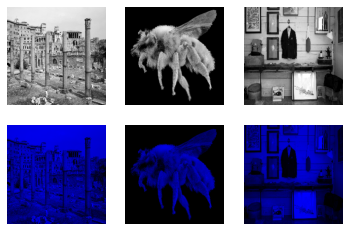

In [14]:
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	re = np.squeeze(src_images[i])
	pyplot.imshow(re.astype('uint8'),'gray')
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off');
	tar = np.concatenate([tar_images[i],src_images[i]],axis = 2)
	pyplot.imshow(np.array(tar).astype('uint8'))
pyplot.show()

In [15]:
src_images[i].shape

(256, 256, 1)

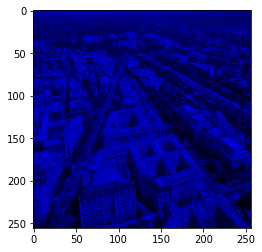

In [16]:
tt =np.concatenate([tar_images[i+ 10],src_images[i+10]],axis = 2)
plt.imshow(np.array(tt).astype('uint8'),'gray')

In [17]:
#testting purpose
# img = tar_images[1]
# img.shape
# img = np.array(img)
# hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# hsv_pixels = img_to_array(hsv_image)
# hsv_pixels.shape

In [18]:
'''def hsv_preprocess_data(X2):
	# load compressed arrays
	# unpack arrays
	# scale from [0,255] to [-1,1]
	
	X2_H = (X2[:,:,0] - 180) / 180
	X2_H = np.expand_dims(X2_H,axis = 2)
	X2_S = (X2[:,:,1] -127.5) / 127.5
	X2_S = np.expand_dims(X2_S,axis = 2)
	X2 = np.concatenate([X2_H,X2_S],axis = 2)
	print(" H S HS,",X2_H.shape,X2_S.shape,X2.shape)
	# X2 = cv2.merge([X2_H,X2_S],cn = 4);print("X1 H S HS,",X1.shape,X2_H.shape,X2_S.shape,X2.shape)
	return  X2'''

'def hsv_preprocess_data(X2):\n\t# load compressed arrays\n\t# unpack arrays\n\t# scale from [0,255] to [-1,1]\n\t\n\tX2_H = (X2[:,:,0] - 180) / 180\n\tX2_H = np.expand_dims(X2_H,axis = 2)\n\tX2_S = (X2[:,:,1] -127.5) / 127.5\n\tX2_S = np.expand_dims(X2_S,axis = 2)\n\tX2 = np.concatenate([X2_H,X2_S],axis = 2)\n\tprint(" H S HS,",X2_H.shape,X2_S.shape,X2.shape)\n\t# X2 = cv2.merge([X2_H,X2_S],cn = 4);print("X1 H S HS,",X1.shape,X2_H.shape,X2_S.shape,X2.shape)\n\treturn  X2'

In [19]:
'''def hsv_post_process(image, src_image = None):
    if(image.shape[2] == 1):
        image = (image + 1) / 2.0
        return(image)
    image = (image + 1) / 2.0
    h = image[:,:,0]
    s = image[:,:,1]

    # h = h * 180 + 180
    # s = s * 127.5 + 127.5
    h = np.expand_dims(h, axis = 2)
    s = np.expand_dims(s, axis =2)
    print("h s",h.shape,s.shape)
    hs = np.concatenate([h,s],axis = 2)
    print("hs ", hs.shape)
    hsv = np.concatenate([hs,src_image],axis = 2)
    hsv = np.array(hsv, dtype=np.uint8)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr'''

'def hsv_post_process(image, src_image = None):\n    if(image.shape[2] == 1):\n        image = (image + 1) / 2.0\n        return(image)\n    image = (image + 1) / 2.0\n    h = image[:,:,0]\n    s = image[:,:,1]\n\n    # h = h * 180 + 180\n    # s = s * 127.5 + 127.5\n    h = np.expand_dims(h, axis = 2)\n    s = np.expand_dims(s, axis =2)\n    print("h s",h.shape,s.shape)\n    hs = np.concatenate([h,s],axis = 2)\n    print("hs ", hs.shape)\n    hsv = np.concatenate([hs,src_image],axis = 2)\n    hsv = np.array(hsv, dtype=np.uint8)\n    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)\n    return bgr'

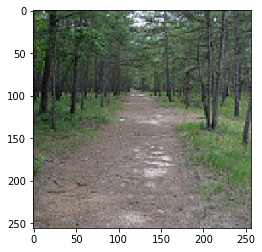

In [20]:
from tensorflow import image
path = '../input/dataunknown/data/20056.jpg'
rgb_image = load_img(path, target_size= (256,256))
rgb_image = img_to_array(rgb_image)
# rgb_image = cv2.imread(path)
# print(rgb_image)
# print(rgb_image.shape)
# hsv_pixels = cv2.cvtColor(np.float32(rgb_image), cv2.COLOR_BGR2HSV)
hsv_pixels = image.rgb_to_hsv(rgb_image)

# print(hsv_pixels)
# hsv_pixels = img_to_array(hhh)
# hs = hsv_preprocess_data(hsv_pixels[:,:,:2])

# s = hsv_pixels[:,:,1]
# s = (s - 127.5)/127.5
v = hsv_pixels[:,:,2]
# plt.imshow(v,'gray')

# v = (v - 127.5) /127.5
# h,s,v = cv2.split(hhh)
# h =  np.expand_dims(h, axis=2)
# s =  np.expand_dims(s, axis=2)
v =  np.expand_dims(v, axis=2)
# print(v.shape)
# gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
hs = hsv_pixels[:,:,:2]
# print(h.shape,s.shape,v.shape)
# hs = np.array(hs, dtype=np.uint8)
# print(hs)
# v = np.array (v, dtype=np.float32)

# hsv = hsv_post_process(hs,v)
# v = hsv_post_process(v)
# hsv = cv2.merge((hs,v))
# print(hsv.shape)
# hsv = np.array(hsv, dtype=np.uint8)


####output###############
hsv = np.concatenate([hs,v],axis = 2)
# hsv = np.array(hsv).astype('uint8')
rgb = image.hsv_to_rgb(hsv)
# rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
# print(rgb)
rgb = np.array(rgb).astype('uint8')

plt.imshow(rgb,'gray')

In [21]:
# plt.imshow(hsv_img[:,:,2].astype('uint8'),'gray')

In [22]:

#from pix2pix_model import define_discriminator, define_generator, define_gan, train
# define input shape based on the loaded dataset
input_image_shape = src_images.shape[1:]
output_image_shape = tar_images.shape[1:]
print("Input image shape ",input_image_shape)
print("Output image shape ",output_image_shape)

# define the models
d_model = define_discriminator(input_image_shape,output_image_shape)
g_model = define_generator(input_image_shape,output_image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, input_image_shape)

#Define data
# load and prepare training images
dataset = [src_images, tar_images]


Input image shape  (256, 256, 1)
Output image shape  (256, 256, 2)


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
# dataset = preprocess_data(data)

In [24]:
# dataset = data

In [25]:


from datetime import datetime 
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1) 

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)




2022-07-09 12:37:37.259234: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-09 12:37:38.478847: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


>1, d1[0.262] d2[0.932] g[74.859]
>2, d1[0.264] d2[1.046] g[66.247]
>3, d1[0.262] d2[0.623] g[47.524]
>4, d1[0.303] d2[0.576] g[60.362]
>5, d1[0.358] d2[0.485] g[39.788]
>6, d1[0.391] d2[0.454] g[35.218]
>7, d1[0.413] d2[0.467] g[25.326]
>8, d1[0.443] d2[0.512] g[37.680]
>9, d1[0.481] d2[0.406] g[28.754]
>10, d1[0.438] d2[0.435] g[34.713]
>11, d1[0.412] d2[0.414] g[31.763]
>12, d1[0.422] d2[0.451] g[56.842]
>13, d1[0.403] d2[0.397] g[35.924]
>14, d1[0.396] d2[0.429] g[33.889]
>15, d1[0.394] d2[0.397] g[27.556]
>16, d1[0.400] d2[0.410] g[27.682]
>17, d1[0.400] d2[0.408] g[43.590]
>18, d1[0.419] d2[0.412] g[30.224]
>19, d1[0.413] d2[0.386] g[37.115]
>20, d1[0.431] d2[0.440] g[42.635]
>21, d1[0.387] d2[0.404] g[29.786]
>22, d1[0.402] d2[0.407] g[22.460]
>23, d1[0.396] d2[0.395] g[46.229]
>24, d1[0.402] d2[0.415] g[30.906]
>25, d1[0.387] d2[0.407] g[45.992]
>26, d1[0.377] d2[0.397] g[28.910]
>27, d1[0.393] d2[0.386] g[42.360]
>28, d1[0.384] d2[0.385] g[30.813]
>29, d1[0.387] d2[0.391] g[38

2022-07-09 12:38:05.724783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>143, d1[0.366] d2[0.389] g[32.992]
>144, d1[0.367] d2[0.378] g[32.485]


2022-07-09 12:38:06.497594: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 12:38:06.529572: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>145, d1[0.358] d2[0.383] g[28.098]
>146, d1[0.379] d2[0.376] g[47.300]
>147, d1[0.350] d2[0.392] g[42.997]
>148, d1[0.367] d2[0.375] g[39.732]
>149, d1[0.374] d2[0.371] g[40.554]
>150, d1[0.379] d2[0.372] g[34.051]
>151, d1[0.366] d2[0.383] g[46.823]
>152, d1[0.369] d2[0.379] g[32.956]
>153, d1[0.357] d2[0.383] g[35.998]
>154, d1[0.358] d2[0.378] g[37.823]
>155, d1[0.385] d2[0.371] g[40.142]
>156, d1[0.371] d2[0.378] g[31.830]
>157, d1[0.374] d2[0.377] g[39.204]
>158, d1[0.365] d2[0.379] g[29.818]
>159, d1[0.349] d2[0.383] g[35.414]
>160, d1[0.371] d2[0.376] g[26.662]
>161, d1[0.356] d2[0.384] g[32.997]
>162, d1[0.390] d2[0.368] g[48.478]
>163, d1[0.359] d2[0.381] g[38.810]
>164, d1[0.376] d2[0.373] g[28.344]
>165, d1[0.365] d2[0.382] g[20.845]
>166, d1[0.338] d2[0.393] g[40.142]
>167, d1[0.375] d2[0.376] g[24.013]
>168, d1[0.362] d2[0.387] g[20.244]
>169, d1[0.348] d2[0.390] g[37.056]
>170, d1[0.370] d2[0.380] g[29.964]
>171, d1[0.367] d2[0.379] g[26.815]
>172, d1[0.362] d2[0.380] g[

2022-07-09 12:41:56.960838: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1898, d1[0.354] d2[0.364] g[24.806]
>1899, d1[0.360] d2[0.359] g[32.059]
>1900, d1[0.338] d2[0.384] g[28.531]
>1901, d1[0.353] d2[0.365] g[16.914]
>1902, d1[0.341] d2[0.376] g[22.548]
>1903, d1[0.333] d2[0.385] g[19.256]
>1904, d1[0.370] d2[0.350] g[13.366]
>1905, d1[0.348] d2[0.372] g[37.464]
>1906, d1[0.375] d2[0.350] g[18.122]
>1907, d1[0.374] d2[0.349] g[17.749]
>1908, d1[0.370] d2[0.350] g[15.230]
>1909, d1[0.350] d2[0.368] g[26.544]
>1910, d1[0.329] d2[0.391] g[20.924]
>1911, d1[0.377] d2[0.348] g[24.995]
>1912, d1[0.354] d2[0.362] g[24.322]
>1913, d1[0.346] d2[0.370] g[24.804]
>1914, d1[0.360] d2[0.359] g[24.374]
>1915, d1[0.350] d2[0.367] g[32.604]
>1916, d1[0.358] d2[0.368] g[22.336]
>1917, d1[0.352] d2[0.365] g[29.022]
>1918, d1[0.371] d2[0.362] g[33.299]
>1919, d1[0.349] d2[0.369] g[21.870]
>1920, d1[0.374] d2[0.353] g[18.042]
>1921, d1[0.355] d2[0.365] g[15.813]
>1922, d1[0.352] d2[0.366] g[18.612]
>1923, d1[0.360] d2[0.362] g[22.984]
>1924, d1[0.352] d2[0.365] g[14.654]
>

2022-07-09 12:45:09.084568: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3361, d1[0.382] d2[0.346] g[30.484]
>3362, d1[0.329] d2[0.378] g[18.064]
>3363, d1[0.350] d2[0.329] g[22.510]
>3364, d1[0.324] d2[0.335] g[26.607]
>3365, d1[0.310] d2[0.344] g[26.798]
>3366, d1[0.339] d2[0.347] g[28.376]
>3367, d1[0.356] d2[0.348] g[19.035]
>3368, d1[0.359] d2[0.363] g[34.529]
>3369, d1[0.388] d2[0.357] g[18.421]
>3370, d1[0.372] d2[0.359] g[16.766]
>3371, d1[0.336] d2[0.372] g[18.985]
>3372, d1[0.355] d2[0.364] g[20.739]
>3373, d1[0.309] d2[0.359] g[22.101]
>3374, d1[0.333] d2[0.346] g[15.530]
>3375, d1[0.371] d2[0.324] g[27.526]
>3376, d1[0.315] d2[0.348] g[25.528]
>3377, d1[0.350] d2[0.348] g[25.583]
>3378, d1[0.362] d2[0.344] g[35.409]
>3379, d1[0.340] d2[0.361] g[20.499]
>3380, d1[0.352] d2[0.345] g[19.702]
>3381, d1[0.397] d2[0.344] g[24.509]
>3382, d1[0.360] d2[0.348] g[15.518]
>3383, d1[0.365] d2[0.325] g[28.503]
>3384, d1[0.347] d2[0.346] g[34.238]
>3385, d1[0.345] d2[0.358] g[29.067]
>3386, d1[0.312] d2[0.353] g[27.756]
>3387, d1[0.321] d2[0.344] g[23.549]
>

2022-07-09 12:45:58.808853: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3746, d1[0.392] d2[0.363] g[12.836]
>3747, d1[0.211] d2[0.335] g[23.167]
>3748, d1[0.399] d2[0.316] g[26.792]
>3749, d1[0.436] d2[0.280] g[25.406]
>3750, d1[0.222] d2[0.290] g[23.121]
>3751, d1[0.291] d2[0.235] g[22.796]
>3752, d1[0.394] d2[0.238] g[22.232]
>3753, d1[0.264] d2[0.347] g[24.952]
>3754, d1[0.150] d2[0.283] g[31.968]
>3755, d1[0.353] d2[0.276] g[22.528]
>3756, d1[0.322] d2[0.220] g[22.578]
>3757, d1[0.298] d2[0.287] g[19.409]
>3758, d1[0.331] d2[0.322] g[20.832]
>3759, d1[0.354] d2[0.497] g[33.337]
>3760, d1[0.321] d2[0.303] g[17.658]
>3761, d1[0.270] d2[0.346] g[17.661]
>3762, d1[0.335] d2[0.341] g[19.693]
>3763, d1[0.190] d2[0.357] g[17.279]
>3764, d1[0.284] d2[0.227] g[24.170]
>3765, d1[0.290] d2[0.311] g[15.872]
>3766, d1[0.354] d2[0.294] g[20.315]
>3767, d1[0.114] d2[0.335] g[29.814]
>3768, d1[0.471] d2[0.231] g[13.458]
>3769, d1[0.284] d2[0.259] g[16.264]
>3770, d1[0.109] d2[0.225] g[55.921]
>3771, d1[0.435] d2[0.252] g[20.584]
>3772, d1[0.254] d2[0.295] g[16.158]
>

2022-07-09 12:50:33.802314: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5902, d1[0.109] d2[0.153] g[27.808]
>5903, d1[0.357] d2[0.191] g[34.325]
>5904, d1[0.072] d2[0.150] g[26.554]
>5905, d1[0.376] d2[0.133] g[30.892]
>5906, d1[0.599] d2[0.652] g[18.838]
>5907, d1[0.250] d2[0.252] g[22.651]
>5908, d1[0.143] d2[0.184] g[22.573]
>5909, d1[0.076] d2[0.341] g[21.226]
>5910, d1[0.168] d2[0.151] g[22.164]
>5911, d1[0.435] d2[0.235] g[21.256]
>5912, d1[0.058] d2[0.302] g[21.332]
>5913, d1[0.320] d2[0.136] g[20.688]
>5914, d1[0.038] d2[0.218] g[22.684]
>5915, d1[0.415] d2[0.173] g[30.143]
>5916, d1[0.156] d2[0.294] g[33.778]
>5917, d1[0.070] d2[0.304] g[27.416]
>5918, d1[0.082] d2[0.792] g[10.229]
>5919, d1[0.725] d2[0.229] g[22.115]
>5920, d1[0.095] d2[0.363] g[23.405]
>5921, d1[0.155] d2[0.190] g[22.395]
>5922, d1[0.292] d2[0.132] g[18.185]
>5923, d1[0.769] d2[0.226] g[17.030]
>5924, d1[0.198] d2[0.301] g[27.064]
>5925, d1[0.519] d2[0.217] g[17.919]
>5926, d1[0.197] d2[0.362] g[22.494]
>5927, d1[0.411] d2[0.150] g[21.191]
>5928, d1[0.448] d2[0.346] g[21.984]
>

2022-07-09 12:50:44.795488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5988, d1[0.072] d2[0.271] g[21.647]
>5989, d1[0.101] d2[0.105] g[22.562]
>5990, d1[0.105] d2[0.149] g[23.723]
>5991, d1[0.430] d2[0.233] g[15.934]
>5992, d1[0.287] d2[0.599] g[27.988]
>5993, d1[0.109] d2[0.149] g[22.782]
>5994, d1[0.626] d2[0.180] g[15.670]
>5995, d1[0.354] d2[0.498] g[21.252]
>5996, d1[0.060] d2[0.259] g[29.273]
>5997, d1[0.079] d2[0.128] g[26.954]
>5998, d1[0.064] d2[0.133] g[32.103]
>5999, d1[0.149] d2[0.181] g[23.207]
>6000, d1[0.105] d2[0.127] g[26.761]
>6001, d1[0.348] d2[0.166] g[21.012]
>6002, d1[0.061] d2[0.293] g[25.545]
>6003, d1[0.075] d2[0.393] g[22.726]
>6004, d1[0.071] d2[0.149] g[22.084]
>6005, d1[0.183] d2[0.142] g[26.080]
>6006, d1[0.251] d2[0.124] g[22.096]
>6007, d1[0.073] d2[0.169] g[34.528]
>6008, d1[0.605] d2[0.163] g[14.993]
>6009, d1[0.021] d2[0.514] g[28.129]
>6010, d1[0.237] d2[0.115] g[27.276]
>6011, d1[0.179] d2[0.246] g[25.275]
>6012, d1[0.633] d2[0.171] g[38.639]
>6013, d1[0.031] d2[0.706] g[15.271]
>6014, d1[0.458] d2[0.212] g[23.720]
>

2022-07-09 12:51:07.248334: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 12:51:07.275481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6163, d1[0.019] d2[0.560] g[30.344]


2022-07-09 12:51:07.508572: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 12:51:07.536574: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6164, d1[0.072] d2[0.351] g[18.334]
>6165, d1[0.335] d2[0.219] g[15.665]
>6166, d1[0.681] d2[0.165] g[19.376]
>6167, d1[0.101] d2[0.133] g[25.106]
>6168, d1[0.214] d2[0.298] g[19.590]
>6169, d1[0.198] d2[0.276] g[20.725]
>6170, d1[0.144] d2[0.200] g[24.827]
>6171, d1[0.351] d2[0.511] g[21.780]
>6172, d1[0.524] d2[0.308] g[16.902]
>6173, d1[0.187] d2[0.114] g[29.666]
>6174, d1[0.121] d2[0.180] g[17.565]
>6175, d1[0.501] d2[0.186] g[28.661]
>6176, d1[0.196] d2[0.233] g[33.248]
>6177, d1[0.147] d2[0.246] g[26.724]
>6178, d1[0.065] d2[0.594] g[20.360]
>6179, d1[0.020] d2[0.620] g[23.540]
>6180, d1[0.334] d2[0.097] g[28.154]
>6181, d1[0.654] d2[0.130] g[16.811]
>6182, d1[0.094] d2[0.176] g[22.532]
>6183, d1[0.277] d2[0.275] g[22.941]
>6184, d1[0.574] d2[0.249] g[21.670]
>6185, d1[0.442] d2[0.295] g[19.903]
>6186, d1[0.368] d2[0.310] g[21.555]
>6187, d1[0.239] d2[0.305] g[37.839]
>6188, d1[0.055] d2[0.267] g[28.568]
>6189, d1[0.470] d2[0.183] g[20.946]
>6190, d1[0.230] d2[0.388] g[20.638]
>

2022-07-09 12:51:38.845059: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6410, d1[0.343] d2[0.167] g[16.764]
>6411, d1[0.373] d2[0.237] g[22.802]
>6412, d1[0.268] d2[1.046] g[16.300]
>6413, d1[0.127] d2[0.202] g[26.012]
>6414, d1[0.045] d2[0.141] g[25.319]
>6415, d1[0.145] d2[0.119] g[16.895]
>6416, d1[0.334] d2[0.117] g[21.513]
>6417, d1[0.106] d2[0.151] g[28.842]
>6418, d1[0.502] d2[0.252] g[15.663]
>6419, d1[0.069] d2[0.189] g[21.720]
>6420, d1[0.121] d2[0.233] g[20.511]
>6421, d1[0.594] d2[0.170] g[24.762]
>6422, d1[0.012] d2[0.335] g[30.334]
>6423, d1[0.112] d2[0.145] g[21.011]
>6424, d1[0.267] d2[0.137] g[15.973]
>6425, d1[0.182] d2[0.197] g[21.740]
>6426, d1[0.201] d2[0.277] g[23.942]
>6427, d1[0.133] d2[0.127] g[22.531]
>6428, d1[0.303] d2[0.232] g[12.844]
>6429, d1[0.419] d2[0.458] g[11.514]
>6430, d1[0.030] d2[0.144] g[30.037]
>6431, d1[0.347] d2[0.209] g[20.349]
>6432, d1[0.256] d2[0.153] g[22.177]
>6433, d1[0.391] d2[0.323] g[9.711]
>6434, d1[0.073] d2[0.573] g[25.189]
>6435, d1[0.129] d2[0.235] g[18.147]
>6436, d1[0.800] d2[0.209] g[23.613]
>6

2022-07-09 12:53:30.019484: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7296, d1[0.440] d2[0.100] g[33.996]
>7297, d1[0.406] d2[0.217] g[17.840]
>7298, d1[0.202] d2[0.156] g[30.779]
>7299, d1[0.562] d2[0.158] g[17.275]
>7300, d1[0.343] d2[0.868] g[29.798]
>7301, d1[0.126] d2[0.254] g[19.361]
>7302, d1[0.317] d2[0.222] g[17.266]
>7303, d1[0.160] d2[0.331] g[20.199]
>7304, d1[0.095] d2[0.291] g[24.917]
>7305, d1[0.626] d2[0.161] g[14.671]
>7306, d1[0.062] d2[0.214] g[30.185]
>7307, d1[0.175] d2[0.205] g[15.720]
>7308, d1[0.169] d2[0.107] g[24.610]
>7309, d1[0.122] d2[0.146] g[28.252]
>7310, d1[0.156] d2[0.317] g[15.620]
>7311, d1[0.401] d2[0.238] g[17.362]
>7312, d1[0.092] d2[0.332] g[22.990]
>7313, d1[0.112] d2[0.143] g[32.243]
>7314, d1[0.081] d2[0.199] g[21.544]
>7315, d1[0.176] d2[0.189] g[25.445]
>7316, d1[0.634] d2[0.225] g[16.509]
>7317, d1[0.604] d2[0.227] g[17.928]
>7318, d1[0.056] d2[0.897] g[23.400]
>7319, d1[0.401] d2[0.180] g[17.144]
>7320, d1[0.136] d2[0.178] g[16.940]
>7321, d1[0.104] d2[0.163] g[27.512]
>7322, d1[0.228] d2[0.151] g[14.754]
>

2022-07-09 12:54:02.977709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7556, d1[0.266] d2[0.251] g[24.419]
>7557, d1[0.344] d2[0.272] g[26.547]
>7558, d1[0.088] d2[0.172] g[31.233]
>7559, d1[0.157] d2[0.234] g[30.465]
>7560, d1[0.301] d2[0.366] g[17.792]
>7561, d1[0.382] d2[0.236] g[22.214]
>7562, d1[0.232] d2[0.271] g[18.510]
>7563, d1[0.101] d2[0.239] g[20.784]
>7564, d1[0.035] d2[0.087] g[23.024]
>7565, d1[0.035] d2[0.316] g[33.707]
>7566, d1[0.505] d2[0.196] g[14.758]
>7567, d1[0.217] d2[0.418] g[13.222]
>7568, d1[0.325] d2[0.209] g[11.533]
>7569, d1[0.187] d2[0.325] g[20.485]
>7570, d1[0.667] d2[0.241] g[17.008]
>7571, d1[0.222] d2[0.573] g[18.413]
>7572, d1[0.603] d2[0.213] g[22.065]
>7573, d1[0.539] d2[0.271] g[19.853]
>7574, d1[0.110] d2[0.153] g[18.910]
>7575, d1[0.031] d2[0.321] g[31.913]
>7576, d1[0.560] d2[0.289] g[18.559]
>7577, d1[0.398] d2[0.156] g[22.774]
>7578, d1[0.080] d2[0.562] g[23.524]
>7579, d1[0.126] d2[0.143] g[23.522]
>7580, d1[0.414] d2[0.147] g[16.112]
>7581, d1[0.125] d2[0.227] g[21.503]
>7582, d1[0.451] d2[0.198] g[17.273]
>

2022-07-09 12:54:24.907651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7730, d1[0.016] d2[0.482] g[29.536]
>7731, d1[0.582] d2[0.247] g[18.466]
>7732, d1[0.154] d2[0.143] g[24.784]
>7733, d1[0.139] d2[0.225] g[27.971]
>7734, d1[0.418] d2[0.327] g[13.977]
>7735, d1[0.384] d2[0.322] g[21.660]
>7736, d1[0.107] d2[0.717] g[20.663]
>7737, d1[0.369] d2[0.127] g[15.086]
>7738, d1[0.209] d2[0.130] g[20.658]
>7739, d1[0.113] d2[0.356] g[24.761]
>7740, d1[0.171] d2[0.109] g[27.050]
>7741, d1[0.045] d2[0.183] g[27.779]
>7742, d1[0.287] d2[0.117] g[21.003]
>7743, d1[0.118] d2[0.349] g[27.721]
>7744, d1[0.603] d2[0.290] g[16.300]
>7745, d1[0.034] d2[0.175] g[31.503]
>7746, d1[0.570] d2[0.253] g[19.506]
>7747, d1[0.022] d2[1.073] g[17.905]
>7748, d1[0.355] d2[0.527] g[29.535]
>7749, d1[0.262] d2[0.150] g[37.229]
>7750, d1[0.107] d2[0.210] g[28.465]
>7751, d1[0.254] d2[0.150] g[20.085]
>7752, d1[0.372] d2[0.205] g[31.033]
>7753, d1[0.220] d2[0.213] g[20.937]
>7754, d1[0.104] d2[0.242] g[21.972]
>7755, d1[0.031] d2[0.270] g[29.528]
>7756, d1[0.116] d2[0.108] g[26.842]
>

2022-07-09 12:54:48.851473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7920, d1[0.156] d2[0.194] g[23.359]
>7921, d1[0.122] d2[0.292] g[25.300]
>7922, d1[0.420] d2[0.203] g[24.212]
>7923, d1[0.393] d2[0.660] g[20.714]
>7924, d1[0.373] d2[0.450] g[31.279]
>7925, d1[0.047] d2[0.430] g[31.036]
>7926, d1[0.680] d2[0.310] g[14.187]
>7927, d1[0.151] d2[0.292] g[23.305]
>7928, d1[0.441] d2[0.158] g[12.087]
>7929, d1[0.480] d2[0.334] g[14.828]
>7930, d1[0.214] d2[0.389] g[21.374]
>7931, d1[0.346] d2[0.267] g[17.532]
>7932, d1[0.280] d2[0.178] g[24.559]
>7933, d1[0.193] d2[0.176] g[23.017]
>7934, d1[0.056] d2[0.210] g[16.161]
>7935, d1[0.013] d2[0.551] g[26.615]
>7936, d1[0.646] d2[0.125] g[20.350]
>7937, d1[0.098] d2[0.165] g[29.080]
>7938, d1[0.070] d2[0.169] g[22.619]
>7939, d1[0.293] d2[0.254] g[18.164]
>7940, d1[0.421] d2[0.428] g[17.281]
>7941, d1[0.144] d2[0.176] g[22.864]
>7942, d1[0.232] d2[0.236] g[24.090]
>7943, d1[0.490] d2[0.313] g[34.124]
>7944, d1[0.222] d2[0.158] g[20.168]
>7945, d1[0.087] d2[0.266] g[25.749]
>7946, d1[0.417] d2[0.300] g[12.309]
>

2022-07-09 12:55:30.086878: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8246, d1[0.045] d2[0.173] g[22.183]
>8247, d1[0.151] d2[0.109] g[14.205]
>8248, d1[0.511] d2[0.998] g[12.309]
>8249, d1[0.052] d2[0.259] g[18.604]
>8250, d1[0.378] d2[0.247] g[20.971]
>8251, d1[0.154] d2[0.209] g[26.107]
>8252, d1[0.349] d2[0.157] g[20.240]
>8253, d1[0.216] d2[0.211] g[23.034]
>8254, d1[0.341] d2[0.158] g[16.701]
>8255, d1[0.252] d2[0.330] g[23.066]
>8256, d1[0.206] d2[0.249] g[13.390]
>8257, d1[0.157] d2[0.200] g[20.031]
>8258, d1[0.190] d2[0.140] g[29.796]
>8259, d1[0.076] d2[0.174] g[31.426]
>8260, d1[0.123] d2[0.845] g[19.390]
>8261, d1[0.261] d2[0.134] g[19.491]
>8262, d1[0.118] d2[0.323] g[21.375]
>8263, d1[0.245] d2[0.179] g[21.336]
>8264, d1[0.372] d2[0.153] g[18.004]
>8265, d1[0.393] d2[0.440] g[17.697]
>8266, d1[0.038] d2[0.307] g[27.700]
>8267, d1[0.086] d2[0.113] g[17.490]
>8268, d1[0.361] d2[0.124] g[21.118]
>8269, d1[0.637] d2[0.391] g[10.187]
>8270, d1[0.124] d2[0.276] g[18.883]
>8271, d1[0.077] d2[0.184] g[22.737]
>8272, d1[0.255] d2[0.110] g[16.743]
>

2022-07-09 12:57:20.785243: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9118, d1[0.428] d2[0.673] g[21.413]
>9119, d1[0.088] d2[0.209] g[25.085]
>9120, d1[0.217] d2[0.145] g[26.286]
>9121, d1[0.084] d2[0.162] g[29.021]
>9122, d1[0.130] d2[0.205] g[18.361]
>9123, d1[0.174] d2[0.119] g[23.110]
>9124, d1[0.384] d2[0.203] g[25.927]
>9125, d1[0.189] d2[0.388] g[17.551]
>9126, d1[0.293] d2[0.254] g[17.973]
>9127, d1[0.058] d2[0.226] g[28.270]
>9128, d1[0.103] d2[0.190] g[21.014]
>9129, d1[0.284] d2[0.224] g[19.730]
>9130, d1[0.233] d2[0.138] g[13.533]
>9131, d1[0.103] d2[0.134] g[23.531]
>9132, d1[0.073] d2[0.291] g[21.336]
>9133, d1[0.077] d2[0.176] g[20.720]
>9134, d1[0.034] d2[0.908] g[8.256]
>9135, d1[0.092] d2[0.248] g[36.174]
>9136, d1[0.047] d2[0.236] g[29.231]
>9137, d1[0.655] d2[0.167] g[22.338]
>9138, d1[0.191] d2[0.830] g[21.065]
>9139, d1[0.271] d2[0.120] g[26.681]
>9140, d1[0.133] d2[0.095] g[24.019]
>9141, d1[0.310] d2[0.177] g[23.894]
>9142, d1[0.101] d2[0.441] g[23.115]
>9143, d1[0.455] d2[0.207] g[21.342]
>9144, d1[0.672] d2[0.251] g[24.117]
>9

2022-07-09 12:57:53.869717: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9377, d1[0.328] d2[0.155] g[16.739]
>9378, d1[0.049] d2[0.177] g[27.271]
>9379, d1[0.175] d2[0.089] g[22.398]
>9380, d1[0.097] d2[0.150] g[23.587]
>9381, d1[0.109] d2[0.101] g[21.960]
>9382, d1[0.307] d2[0.254] g[25.746]
>9383, d1[0.035] d2[0.224] g[22.185]
>9384, d1[0.176] d2[0.237] g[18.996]
>9385, d1[0.071] d2[0.130] g[17.624]
>9386, d1[0.055] d2[0.137] g[20.896]
>9387, d1[0.126] d2[0.315] g[13.929]
>9388, d1[0.089] d2[0.158] g[20.067]
>9389, d1[0.302] d2[0.148] g[21.879]
>9390, d1[0.266] d2[0.270] g[22.334]
>9391, d1[0.189] d2[0.152] g[21.349]
>9392, d1[0.194] d2[0.635] g[16.137]
>9393, d1[0.114] d2[0.256] g[18.579]
>9394, d1[0.342] d2[0.661] g[16.286]
>9395, d1[0.106] d2[0.072] g[22.964]
>9396, d1[0.343] d2[0.103] g[18.472]
>9397, d1[0.067] d2[0.213] g[24.892]
>9398, d1[0.206] d2[0.187] g[29.344]
>9399, d1[0.162] d2[0.251] g[26.157]
>9400, d1[0.184] d2[0.138] g[22.980]
>9401, d1[0.036] d2[0.112] g[22.961]
>9402, d1[0.023] d2[0.101] g[26.895]
>9403, d1[0.060] d2[0.227] g[45.194]
>

2022-07-09 12:58:05.062651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 12:58:05.090041: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9465, d1[0.093] d2[0.273] g[19.116]


2022-07-09 12:58:05.314584: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 12:58:05.341370: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9466, d1[0.124] d2[0.106] g[26.657]


2022-07-09 12:58:05.542126: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 12:58:05.570495: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9467, d1[0.652] d2[0.227] g[15.770]
>9468, d1[0.239] d2[0.251] g[20.739]
>9469, d1[0.259] d2[0.359] g[19.988]
>9470, d1[0.043] d2[0.250] g[26.421]
>9471, d1[0.271] d2[0.167] g[22.758]
>9472, d1[0.607] d2[0.248] g[19.975]
>9473, d1[0.550] d2[0.247] g[12.978]
>9474, d1[0.095] d2[0.289] g[22.710]
>9475, d1[0.055] d2[0.122] g[23.566]
>9476, d1[0.235] d2[0.205] g[25.488]
>9477, d1[0.119] d2[0.151] g[21.488]
>9478, d1[0.167] d2[0.400] g[21.808]
>9479, d1[0.122] d2[0.211] g[19.195]
>9480, d1[0.131] d2[0.183] g[15.495]
>9481, d1[0.129] d2[0.096] g[18.529]
>9482, d1[0.318] d2[0.539] g[18.799]
>9483, d1[0.560] d2[0.381] g[14.630]
>9484, d1[0.030] d2[0.550] g[29.516]
>9485, d1[0.204] d2[0.132] g[23.057]
>9486, d1[0.428] d2[0.680] g[18.177]
>9487, d1[0.100] d2[0.124] g[25.163]
>9488, d1[0.546] d2[0.150] g[20.423]
>9489, d1[0.604] d2[0.176] g[25.522]
>9490, d1[0.305] d2[0.466] g[19.958]
>9491, d1[0.113] d2[0.309] g[12.794]
>9492, d1[0.520] d2[0.151] g[14.503]
>9493, d1[0.466] d2[0.289] g[10.016]
>

2022-07-09 12:58:16.224506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9551, d1[0.282] d2[0.283] g[18.166]
>9552, d1[0.214] d2[0.163] g[19.426]
>9553, d1[0.158] d2[0.268] g[19.815]
>9554, d1[0.135] d2[0.401] g[19.160]
>9555, d1[0.802] d2[0.139] g[14.496]
>9556, d1[0.260] d2[0.309] g[18.705]
>9557, d1[0.053] d2[0.206] g[29.107]
>9558, d1[0.061] d2[0.194] g[32.100]
>9559, d1[0.315] d2[0.208] g[23.651]
>9560, d1[0.115] d2[0.238] g[19.722]
>9561, d1[0.120] d2[0.181] g[22.611]
>9562, d1[0.225] d2[0.195] g[20.184]
>9563, d1[0.200] d2[0.238] g[22.967]
>9564, d1[0.291] d2[0.151] g[21.366]
>9565, d1[0.239] d2[0.276] g[14.056]
>9566, d1[0.287] d2[0.279] g[13.234]
>9567, d1[0.099] d2[0.379] g[19.890]
>9568, d1[0.625] d2[0.238] g[12.223]
>9569, d1[0.189] d2[0.267] g[26.959]
>9570, d1[0.222] d2[0.217] g[26.866]
>9571, d1[0.406] d2[0.171] g[9.560]
>9572, d1[0.235] d2[0.349] g[13.761]
>9573, d1[0.361] d2[0.522] g[18.039]
>9574, d1[0.026] d2[0.179] g[24.619]
>9575, d1[0.141] d2[0.143] g[19.614]
>9576, d1[0.250] d2[0.242] g[19.184]
>9577, d1[0.086] d2[0.133] g[22.618]
>9

2022-07-09 12:58:37.999471: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9721, d1[0.821] d2[0.265] g[25.750]
>9722, d1[0.163] d2[0.202] g[24.147]
>9723, d1[0.423] d2[1.014] g[25.603]
>9724, d1[0.139] d2[0.177] g[25.008]
>9725, d1[0.113] d2[0.237] g[18.644]
>9726, d1[0.097] d2[0.135] g[26.329]
>9727, d1[0.223] d2[0.167] g[26.941]
>9728, d1[0.519] d2[0.256] g[12.574]
>9729, d1[0.047] d2[0.399] g[26.684]
>9730, d1[0.225] d2[0.286] g[15.838]
>9731, d1[0.126] d2[0.268] g[20.466]
>9732, d1[0.241] d2[0.113] g[24.177]
>9733, d1[0.118] d2[0.158] g[21.484]
>9734, d1[0.422] d2[0.270] g[21.496]
>9735, d1[0.180] d2[0.345] g[19.065]
>9736, d1[0.192] d2[0.186] g[25.950]
>9737, d1[0.150] d2[0.134] g[21.154]
>9738, d1[0.055] d2[0.190] g[28.778]
>9739, d1[0.356] d2[0.453] g[18.238]
>9740, d1[0.274] d2[0.193] g[24.515]
>9741, d1[0.449] d2[0.342] g[19.967]
>9742, d1[0.077] d2[0.327] g[30.876]
>9743, d1[0.108] d2[0.099] g[20.384]
>9744, d1[0.092] d2[0.201] g[32.876]
>9745, d1[0.366] d2[0.137] g[21.401]
>9746, d1[0.059] d2[0.187] g[30.673]
>9747, d1[0.594] d2[0.186] g[12.613]
>

2022-07-09 12:58:52.927479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9840, d1[0.061] d2[0.117] g[22.579]
>9841, d1[0.054] d2[0.182] g[26.907]
>9842, d1[0.088] d2[0.209] g[22.374]
>9843, d1[0.097] d2[0.148] g[26.699]
>9844, d1[0.389] d2[0.141] g[18.444]
>9845, d1[0.112] d2[0.123] g[17.832]
>9846, d1[0.131] d2[0.218] g[19.657]
>9847, d1[0.052] d2[0.132] g[24.517]
>9848, d1[0.745] d2[0.304] g[9.102]
>9849, d1[0.034] d2[0.179] g[35.942]
>9850, d1[0.042] d2[0.116] g[20.997]
>9851, d1[0.016] d2[0.177] g[33.263]
>9852, d1[0.420] d2[0.278] g[14.355]
>9853, d1[0.291] d2[0.176] g[25.793]
>9854, d1[0.084] d2[0.103] g[21.071]
>9855, d1[0.122] d2[0.181] g[31.743]
>9856, d1[0.025] d2[0.346] g[35.707]
>9857, d1[0.239] d2[0.130] g[19.275]
>9858, d1[0.078] d2[0.251] g[16.531]
>9859, d1[0.066] d2[0.162] g[24.955]
>9860, d1[0.052] d2[0.145] g[23.609]
>9861, d1[0.350] d2[0.158] g[30.053]
>9862, d1[0.272] d2[0.293] g[19.458]
>9863, d1[0.682] d2[0.461] g[41.670]
>9864, d1[0.268] d2[0.391] g[22.339]
>9865, d1[0.174] d2[0.171] g[23.176]
>9866, d1[0.195] d2[0.347] g[19.755]
>9

2022-07-09 12:58:59.866536: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9894, d1[0.367] d2[0.251] g[19.654]
>9895, d1[0.194] d2[0.378] g[15.950]
>9896, d1[0.322] d2[0.288] g[17.582]
>9897, d1[0.076] d2[0.134] g[33.546]
>9898, d1[0.444] d2[0.157] g[20.076]
>9899, d1[0.111] d2[0.721] g[22.055]
>9900, d1[0.338] d2[0.185] g[24.264]
>9901, d1[0.399] d2[0.156] g[35.059]
>9902, d1[0.239] d2[0.192] g[20.612]
>9903, d1[0.126] d2[0.299] g[22.556]
>9904, d1[0.095] d2[0.240] g[26.338]
>9905, d1[0.579] d2[0.116] g[13.793]
>9906, d1[0.505] d2[0.178] g[12.797]
>9907, d1[0.134] d2[0.317] g[22.479]
>9908, d1[0.218] d2[0.251] g[21.734]
>9909, d1[0.277] d2[0.190] g[24.852]
>9910, d1[0.087] d2[0.145] g[19.663]
>9911, d1[0.086] d2[0.180] g[16.656]
>9912, d1[0.074] d2[0.221] g[23.830]
>9913, d1[0.164] d2[0.153] g[26.206]
>9914, d1[0.302] d2[0.396] g[17.331]
>9915, d1[0.050] d2[0.201] g[29.754]
>9916, d1[0.081] d2[0.142] g[23.472]
>9917, d1[0.168] d2[0.115] g[16.264]
>9918, d1[0.077] d2[0.101] g[22.140]
>9919, d1[0.326] d2[0.096] g[19.304]
>9920, d1[0.153] d2[0.167] g[19.682]
>

2022-07-09 12:59:09.330244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 12:59:09.348715: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9970, d1[0.340] d2[0.153] g[15.741]
>9971, d1[0.025] d2[0.394] g[23.543]
>9972, d1[0.016] d2[0.213] g[27.025]
>9973, d1[0.180] d2[0.103] g[18.679]
>9974, d1[0.110] d2[0.119] g[25.052]
>9975, d1[0.204] d2[0.179] g[13.578]
>9976, d1[0.227] d2[0.143] g[14.237]
>9977, d1[0.011] d2[0.615] g[27.023]
>9978, d1[0.076] d2[0.115] g[22.945]
>9979, d1[0.127] d2[0.244] g[15.854]
>9980, d1[0.146] d2[0.090] g[27.111]
>9981, d1[0.084] d2[0.162] g[20.545]
>9982, d1[0.408] d2[0.122] g[19.790]
>9983, d1[0.122] d2[0.595] g[21.009]
>9984, d1[0.125] d2[0.178] g[19.401]
>9985, d1[0.356] d2[0.523] g[22.818]
>9986, d1[0.283] d2[0.098] g[15.859]
>9987, d1[0.262] d2[0.164] g[53.604]
>9988, d1[0.059] d2[0.243] g[16.679]
>9989, d1[0.192] d2[0.129] g[19.729]
>9990, d1[0.262] d2[0.327] g[19.375]
>9991, d1[0.078] d2[0.221] g[22.214]
>9992, d1[0.147] d2[0.251] g[16.007]
>9993, d1[0.152] d2[0.115] g[27.571]
>9994, d1[0.446] d2[0.195] g[21.103]
>9995, d1[0.236] d2[0.331] g[20.771]
>9996, d1[0.662] d2[0.601] g[16.427]
>

2022-07-09 13:00:45.224654: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10727, d1[0.271] d2[0.331] g[16.091]
>10728, d1[0.431] d2[0.298] g[22.901]
>10729, d1[0.194] d2[0.160] g[25.210]
>10730, d1[0.172] d2[0.359] g[23.616]
>10731, d1[0.260] d2[0.177] g[21.158]
>10732, d1[0.071] d2[0.121] g[28.775]
>10733, d1[0.852] d2[0.462] g[16.175]
>10734, d1[0.226] d2[0.340] g[17.338]
>10735, d1[0.598] d2[0.271] g[12.790]
>10736, d1[0.114] d2[0.307] g[37.898]
>10737, d1[0.689] d2[0.400] g[12.024]
>10738, d1[0.114] d2[0.180] g[27.562]
>10739, d1[0.330] d2[0.307] g[18.136]
>10740, d1[0.170] d2[0.127] g[22.037]
>10741, d1[0.249] d2[0.167] g[28.425]
>10742, d1[0.283] d2[0.297] g[15.019]
>10743, d1[0.199] d2[0.184] g[16.330]
>10744, d1[0.231] d2[0.213] g[16.894]
>10745, d1[0.195] d2[0.210] g[17.125]
>10746, d1[0.066] d2[0.168] g[23.184]
>10747, d1[0.106] d2[0.266] g[26.971]
>10748, d1[0.085] d2[0.136] g[19.422]
>10749, d1[0.141] d2[0.132] g[22.257]
>10750, d1[0.047] d2[0.174] g[22.178]
>10751, d1[0.075] d2[0.245] g[25.144]
>10752, d1[0.414] d2[0.127] g[16.213]
>10753, d1[0

2022-07-09 13:01:11.932420: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10936, d1[0.160] d2[0.309] g[20.891]
>10937, d1[0.196] d2[0.210] g[21.475]
>10938, d1[0.078] d2[0.173] g[38.397]
>10939, d1[0.794] d2[0.225] g[13.411]
>10940, d1[0.311] d2[0.428] g[19.142]
>10941, d1[0.098] d2[0.258] g[23.401]
>10942, d1[0.196] d2[0.256] g[20.885]
>10943, d1[0.254] d2[0.192] g[21.593]
>10944, d1[0.198] d2[0.142] g[21.076]
>10945, d1[0.106] d2[0.186] g[22.636]
>10946, d1[0.119] d2[0.173] g[17.246]
>10947, d1[0.224] d2[0.378] g[17.295]
>10948, d1[0.140] d2[0.114] g[14.697]
>10949, d1[0.099] d2[0.235] g[19.825]
>10950, d1[0.032] d2[0.256] g[29.031]
>10951, d1[0.377] d2[0.154] g[16.051]
>10952, d1[0.026] d2[0.384] g[26.425]
>10953, d1[0.088] d2[0.352] g[25.421]
>10954, d1[0.726] d2[0.206] g[21.974]
>10955, d1[0.443] d2[0.199] g[17.674]
>10956, d1[0.130] d2[0.116] g[21.549]
>10957, d1[0.378] d2[0.180] g[17.809]
>10958, d1[0.103] d2[0.218] g[21.714]
>10959, d1[0.131] d2[0.110] g[23.098]
>10960, d1[0.315] d2[0.331] g[13.719]
>10961, d1[0.202] d2[0.127] g[18.385]
>10962, d1[0

2022-07-09 13:03:34.734078: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12061, d1[0.090] d2[0.206] g[22.931]
>12062, d1[0.168] d2[0.213] g[24.052]
>12063, d1[0.045] d2[0.203] g[23.369]
>12064, d1[0.133] d2[0.158] g[23.223]
>12065, d1[0.220] d2[0.220] g[21.939]
>12066, d1[0.090] d2[0.169] g[21.498]
>12067, d1[0.048] d2[0.228] g[44.427]
>12068, d1[0.269] d2[0.252] g[16.174]
>12069, d1[0.067] d2[0.428] g[20.344]
>12070, d1[0.096] d2[0.187] g[23.763]
>12071, d1[0.229] d2[0.065] g[20.573]
>12072, d1[0.074] d2[0.112] g[30.971]
>12073, d1[0.201] d2[0.146] g[42.891]
>12074, d1[0.015] d2[1.112] g[21.224]
>12075, d1[0.256] d2[0.074] g[25.799]
>12076, d1[0.353] d2[0.171] g[26.784]
>12077, d1[0.775] d2[0.224] g[20.473]
>12078, d1[0.066] d2[0.129] g[23.425]
>12079, d1[0.118] d2[0.254] g[25.434]
>12080, d1[0.218] d2[0.211] g[23.048]
>12081, d1[0.247] d2[0.244] g[17.824]
>12082, d1[0.121] d2[0.111] g[21.844]
>12083, d1[0.152] d2[0.129] g[22.719]
>12084, d1[0.097] d2[0.496] g[22.211]
>12085, d1[0.374] d2[0.368] g[14.773]
>12086, d1[0.213] d2[0.184] g[18.855]
>12087, d1[0

2022-07-09 13:03:46.034495: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12151, d1[0.141] d2[0.156] g[22.782]
>12152, d1[0.377] d2[0.630] g[19.979]
>12153, d1[0.300] d2[0.241] g[19.853]
>12154, d1[0.165] d2[0.321] g[28.115]
>12155, d1[0.250] d2[0.187] g[35.305]
>12156, d1[0.042] d2[0.185] g[31.649]
>12157, d1[0.083] d2[0.190] g[23.226]
>12158, d1[0.554] d2[0.201] g[16.636]
>12159, d1[0.236] d2[0.209] g[20.194]
>12160, d1[0.241] d2[0.268] g[16.617]
>12161, d1[0.102] d2[0.183] g[22.292]
>12162, d1[0.015] d2[0.161] g[32.781]
>12163, d1[0.283] d2[0.240] g[22.843]
>12164, d1[0.057] d2[0.553] g[21.561]
>12165, d1[0.315] d2[0.393] g[14.903]
>12166, d1[0.086] d2[0.148] g[19.440]
>12167, d1[0.222] d2[0.152] g[24.640]
>12168, d1[0.098] d2[0.297] g[18.947]
>12169, d1[0.134] d2[0.084] g[22.958]
>12170, d1[0.448] d2[0.248] g[15.953]
>12171, d1[0.119] d2[0.382] g[22.765]
>12172, d1[0.381] d2[0.182] g[17.962]
>12173, d1[0.413] d2[0.217] g[12.180]
>12174, d1[0.232] d2[0.266] g[23.427]
>12175, d1[0.367] d2[0.287] g[16.978]
>12176, d1[0.107] d2[0.354] g[23.140]
>12177, d1[0

2022-07-09 13:04:30.314487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12504, d1[0.213] d2[0.566] g[18.069]
>12505, d1[0.379] d2[0.136] g[26.782]
>12506, d1[0.230] d2[0.171] g[19.757]
>12507, d1[0.119] d2[0.615] g[17.955]
>12508, d1[0.275] d2[0.247] g[19.347]
>12509, d1[0.243] d2[0.135] g[18.317]
>12510, d1[0.142] d2[0.213] g[23.639]
>12511, d1[0.679] d2[1.001] g[12.946]
>12512, d1[0.058] d2[0.153] g[30.154]
>12513, d1[0.517] d2[0.147] g[17.026]
>12514, d1[0.171] d2[0.148] g[32.148]
>12515, d1[0.222] d2[0.118] g[34.193]
>12516, d1[0.070] d2[0.138] g[18.609]
>12517, d1[0.114] d2[0.172] g[24.975]
>12518, d1[0.091] d2[0.220] g[27.740]
>12519, d1[0.090] d2[0.159] g[20.209]
>12520, d1[0.192] d2[0.157] g[19.194]
>12521, d1[0.410] d2[0.717] g[17.517]
>12522, d1[0.166] d2[0.109] g[21.952]
>12523, d1[0.042] d2[0.333] g[28.939]
>12524, d1[0.158] d2[0.139] g[23.524]
>12525, d1[1.135] d2[0.197] g[8.769]
>12526, d1[0.094] d2[0.277] g[23.691]
>12527, d1[0.187] d2[0.183] g[15.844]
>12528, d1[0.491] d2[0.232] g[17.987]
>12529, d1[0.609] d2[0.312] g[18.630]
>12530, d1[0.

2022-07-09 13:05:01.835472: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12755, d1[0.398] d2[0.275] g[17.577]
>12756, d1[0.677] d2[0.222] g[14.109]
>12757, d1[0.046] d2[0.336] g[29.472]
>12758, d1[0.065] d2[0.147] g[18.961]
>12759, d1[0.454] d2[0.364] g[23.299]
>12760, d1[0.160] d2[0.570] g[9.430]
>12761, d1[0.319] d2[0.321] g[14.762]
>12762, d1[0.665] d2[0.126] g[29.395]


2022-07-09 13:05:03.385804: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12763, d1[0.223] d2[0.286] g[21.866]


2022-07-09 13:05:03.659523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12764, d1[0.072] d2[0.149] g[28.805]
>12765, d1[0.222] d2[0.228] g[26.707]
>12766, d1[0.159] d2[0.198] g[20.948]
>12767, d1[0.305] d2[0.697] g[14.006]
>12768, d1[0.166] d2[0.385] g[22.643]
>12769, d1[0.577] d2[0.310] g[12.679]
>12770, d1[0.235] d2[0.204] g[22.296]
>12771, d1[0.431] d2[0.230] g[17.153]
>12772, d1[0.219] d2[0.182] g[17.877]
>12773, d1[0.139] d2[0.249] g[22.739]
>12774, d1[0.291] d2[0.201] g[21.972]
>12775, d1[0.106] d2[0.512] g[22.759]
>12776, d1[0.418] d2[0.189] g[13.291]
>12777, d1[0.146] d2[0.144] g[22.642]
>12778, d1[0.157] d2[0.268] g[18.255]
>12779, d1[0.067] d2[0.136] g[32.935]
>12780, d1[0.058] d2[0.182] g[28.689]
>12781, d1[0.419] d2[0.215] g[17.680]
>12782, d1[0.486] d2[0.158] g[18.347]
>12783, d1[0.155] d2[0.379] g[16.515]
>12784, d1[0.346] d2[0.229] g[16.719]
>12785, d1[0.446] d2[1.093] g[13.042]
>12786, d1[0.231] d2[0.260] g[13.801]
>12787, d1[0.212] d2[0.385] g[18.847]
>12788, d1[0.487] d2[0.285] g[15.067]
>12789, d1[0.295] d2[0.233] g[17.917]
>12790, d1[0

2022-07-09 13:05:42.975349: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>13076, d1[0.061] d2[0.200] g[23.940]
>13077, d1[0.171] d2[0.177] g[18.079]
>13078, d1[0.118] d2[0.238] g[15.963]
>13079, d1[0.144] d2[0.114] g[27.423]
>13080, d1[0.594] d2[0.317] g[14.179]
>13081, d1[0.133] d2[0.228] g[23.783]
>13082, d1[0.380] d2[0.170] g[19.155]
>13083, d1[0.025] d2[0.339] g[15.032]
>13084, d1[0.168] d2[0.171] g[16.627]
>13085, d1[0.209] d2[0.244] g[19.011]
>13086, d1[0.030] d2[0.444] g[25.315]
>13087, d1[0.216] d2[0.141] g[28.748]
>13088, d1[0.096] d2[0.142] g[25.385]
>13089, d1[0.222] d2[0.199] g[20.558]
>13090, d1[0.260] d2[0.252] g[14.845]
>13091, d1[0.442] d2[0.236] g[27.063]
>13092, d1[0.120] d2[0.172] g[23.387]
>13093, d1[0.219] d2[0.143] g[18.394]
>13094, d1[0.149] d2[0.146] g[18.862]
>13095, d1[0.106] d2[0.254] g[23.082]
>13096, d1[0.338] d2[0.364] g[13.808]
>13097, d1[0.083] d2[0.228] g[27.851]
>13098, d1[0.346] d2[0.343] g[19.518]
>13099, d1[0.052] d2[0.250] g[17.856]
>13100, d1[0.487] d2[0.202] g[20.989]
>13101, d1[0.192] d2[0.219] g[18.926]
>13102, d1[0

2022-07-09 13:06:19.836521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 13:06:19.859492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>13365, d1[0.202] d2[0.158] g[22.109]
>13366, d1[0.261] d2[0.211] g[17.125]
>13367, d1[0.042] d2[0.116] g[18.666]
>13368, d1[0.396] d2[0.165] g[15.779]
>13369, d1[0.129] d2[0.228] g[14.762]
>13370, d1[0.525] d2[0.374] g[9.510]
>13371, d1[0.072] d2[0.211] g[19.659]
>13372, d1[0.490] d2[0.217] g[18.792]
>13373, d1[0.127] d2[0.256] g[19.549]
>13374, d1[0.060] d2[0.146] g[23.395]
>13375, d1[0.076] d2[0.161] g[18.435]
>13376, d1[0.267] d2[0.216] g[16.814]
>13377, d1[0.060] d2[0.145] g[17.436]
>13378, d1[0.059] d2[0.526] g[18.617]
>13379, d1[0.032] d2[0.149] g[31.586]
>13380, d1[0.321] d2[0.122] g[12.140]
>13381, d1[0.134] d2[0.116] g[18.569]
>13382, d1[0.181] d2[0.232] g[21.232]
>13383, d1[0.130] d2[0.232] g[18.404]
>13384, d1[0.168] d2[0.180] g[23.009]
>13385, d1[0.124] d2[0.172] g[19.107]
>13386, d1[0.468] d2[0.182] g[17.962]
>13387, d1[0.298] d2[0.494] g[15.876]
>13388, d1[0.049] d2[0.130] g[21.214]
>13389, d1[0.174] d2[0.235] g[19.717]
>13390, d1[0.170] d2[0.196] g[15.260]
>13391, d1[0.

2022-07-09 13:06:31.065968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>13455, d1[0.122] d2[0.129] g[19.417]
>13456, d1[0.104] d2[0.242] g[18.621]
>13457, d1[0.093] d2[0.298] g[17.924]
>13458, d1[0.139] d2[0.187] g[31.149]
>13459, d1[0.451] d2[0.148] g[19.756]
>13460, d1[0.269] d2[0.137] g[15.763]
>13461, d1[0.128] d2[0.648] g[14.381]
>13462, d1[0.104] d2[0.121] g[26.936]
>13463, d1[0.110] d2[0.171] g[21.364]
>13464, d1[0.022] d2[0.264] g[33.217]
>13465, d1[0.206] d2[0.137] g[17.705]
>13466, d1[0.658] d2[0.165] g[15.213]
>13467, d1[0.142] d2[0.136] g[14.400]
>13468, d1[0.251] d2[0.282] g[20.618]
>13469, d1[0.042] d2[0.200] g[31.145]
>13470, d1[0.164] d2[0.519] g[22.271]
>13471, d1[0.098] d2[0.112] g[21.804]
>13472, d1[0.164] d2[0.109] g[17.044]
>13473, d1[0.093] d2[0.465] g[15.311]
>13474, d1[0.405] d2[0.295] g[16.130]
>13475, d1[0.270] d2[0.196] g[16.771]
>13476, d1[0.437] d2[0.235] g[12.061]
>13477, d1[0.195] d2[0.155] g[21.391]
>13478, d1[0.099] d2[0.145] g[15.885]
>13479, d1[0.115] d2[0.156] g[21.354]
>13480, d1[0.432] d2[0.182] g[20.743]
>13481, d1[0

2022-07-09 13:06:39.288969: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>13519, d1[0.117] d2[0.327] g[15.385]
>13520, d1[0.051] d2[0.238] g[22.269]
>13521, d1[0.156] d2[0.186] g[16.072]
>13522, d1[0.117] d2[0.219] g[24.364]
>13523, d1[0.178] d2[0.229] g[31.002]
>13524, d1[0.140] d2[0.285] g[16.409]
>13525, d1[0.043] d2[0.204] g[29.926]
>13526, d1[0.242] d2[0.273] g[22.752]
>13527, d1[0.614] d2[0.221] g[12.268]
>13528, d1[0.191] d2[0.152] g[31.805]
>13529, d1[0.552] d2[0.199] g[13.112]
>13530, d1[0.036] d2[0.778] g[21.189]
>13531, d1[0.243] d2[0.236] g[23.679]
>13532, d1[0.311] d2[0.156] g[22.280]
>13533, d1[0.175] d2[0.572] g[16.518]
>13534, d1[0.352] d2[0.144] g[21.059]
>13535, d1[0.440] d2[0.168] g[16.691]
>13536, d1[0.132] d2[0.209] g[26.133]
>13537, d1[0.258] d2[0.301] g[19.899]
>13538, d1[0.567] d2[0.216] g[11.183]
>13539, d1[0.230] d2[0.361] g[20.030]
>13540, d1[0.117] d2[0.203] g[21.744]
>13541, d1[0.277] d2[0.154] g[16.097]
>13542, d1[0.263] d2[0.365] g[11.816]
>13543, d1[0.123] d2[0.277] g[18.851]
>13544, d1[0.022] d2[0.308] g[22.053]
>13545, d1[0

2022-07-09 13:09:15.823531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>14741, d1[0.519] d2[0.512] g[13.783]
>14742, d1[0.337] d2[0.242] g[16.413]
>14743, d1[0.181] d2[0.150] g[25.625]
>14744, d1[0.336] d2[0.124] g[20.300]
>14745, d1[0.163] d2[0.173] g[24.569]
>14746, d1[0.489] d2[0.370] g[15.541]
>14747, d1[0.121] d2[0.300] g[17.550]
>14748, d1[0.161] d2[0.197] g[22.103]
>14749, d1[0.221] d2[0.247] g[18.343]
>14750, d1[0.260] d2[0.175] g[20.341]
>14751, d1[0.182] d2[0.220] g[19.402]
>14752, d1[0.183] d2[0.244] g[15.145]
>14753, d1[0.071] d2[0.172] g[20.915]
>14754, d1[0.116] d2[0.434] g[21.578]
>14755, d1[0.030] d2[0.201] g[40.485]
>14756, d1[0.247] d2[0.097] g[21.794]
>14757, d1[0.341] d2[0.311] g[14.923]
>14758, d1[0.519] d2[0.319] g[11.526]
>14759, d1[0.663] d2[0.406] g[16.105]
>14760, d1[0.292] d2[0.493] g[12.884]
>14761, d1[0.221] d2[0.228] g[19.736]
>14762, d1[0.022] d2[0.881] g[8.609]
>14763, d1[0.344] d2[0.248] g[19.640]
>14764, d1[0.233] d2[0.204] g[25.974]
>14765, d1[0.090] d2[0.372] g[21.091]
>14766, d1[0.229] d2[0.153] g[21.814]
>14767, d1[0.

2022-07-09 13:10:00.257202: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>15089, d1[0.126] d2[0.160] g[21.317]
>15090, d1[0.645] d2[0.162] g[11.103]
>15091, d1[0.221] d2[0.252] g[12.444]
>15092, d1[0.025] d2[0.259] g[30.611]
>15093, d1[0.119] d2[0.269] g[19.317]
>15094, d1[0.388] d2[0.159] g[22.091]
>15095, d1[0.167] d2[0.242] g[19.933]
>15096, d1[0.192] d2[0.283] g[18.673]
>15097, d1[0.179] d2[1.133] g[20.365]
>15098, d1[0.181] d2[0.169] g[20.658]
>15099, d1[0.610] d2[0.181] g[13.492]
>15100, d1[0.091] d2[0.398] g[20.139]
>15101, d1[0.183] d2[0.349] g[22.897]
>15102, d1[0.766] d2[0.124] g[12.604]
>15103, d1[0.272] d2[0.319] g[19.372]
>15104, d1[0.419] d2[0.456] g[17.839]
>15105, d1[0.028] d2[0.170] g[36.971]
>15106, d1[0.326] d2[0.140] g[24.899]
>15107, d1[0.095] d2[0.220] g[22.521]
>15108, d1[0.260] d2[0.276] g[23.703]
>15109, d1[0.051] d2[0.591] g[29.537]
>15110, d1[0.285] d2[0.120] g[19.417]
>15111, d1[0.231] d2[0.208] g[21.486]
>15112, d1[0.189] d2[0.115] g[34.278]
>15113, d1[0.186] d2[0.174] g[16.320]
>15114, d1[0.298] d2[0.173] g[15.258]
>15115, d1[0

2022-07-09 13:10:43.913480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>15433, d1[0.110] d2[0.113] g[24.508]
>15434, d1[0.359] d2[0.260] g[18.467]
>15435, d1[0.270] d2[0.216] g[18.633]
>15436, d1[0.526] d2[0.242] g[17.207]
>15437, d1[0.112] d2[0.238] g[14.026]
>15438, d1[0.280] d2[0.355] g[16.605]
>15439, d1[0.099] d2[0.263] g[18.226]
>15440, d1[0.062] d2[0.399] g[24.044]
>15441, d1[0.385] d2[0.297] g[9.504]
>15442, d1[0.094] d2[0.243] g[20.268]
>15443, d1[0.159] d2[0.239] g[17.528]
>15444, d1[0.326] d2[0.153] g[19.545]
>15445, d1[0.219] d2[0.386] g[20.345]
>15446, d1[0.210] d2[0.151] g[17.043]
>15447, d1[0.130] d2[0.365] g[33.685]
>15448, d1[0.138] d2[0.138] g[18.738]
>15449, d1[0.161] d2[0.410] g[23.246]
>15450, d1[0.071] d2[0.132] g[28.860]
>15451, d1[0.113] d2[0.098] g[26.875]
>15452, d1[0.434] d2[0.190] g[13.534]
>15453, d1[0.137] d2[0.345] g[17.409]
>15454, d1[0.612] d2[0.219] g[13.731]
>15455, d1[0.244] d2[0.257] g[17.459]
>15456, d1[0.042] d2[0.374] g[19.337]
>15457, d1[0.202] d2[0.494] g[14.889]
>15458, d1[0.270] d2[0.128] g[28.127]
>15459, d1[0.

2022-07-09 13:11:28.093741: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>15786, d1[0.343] d2[0.213] g[14.300]
>15787, d1[0.056] d2[0.212] g[21.208]
>15788, d1[0.127] d2[0.123] g[18.439]
>15789, d1[0.240] d2[0.245] g[16.879]
>15790, d1[0.080] d2[0.141] g[23.159]
>15791, d1[0.161] d2[0.239] g[16.292]
>15792, d1[0.055] d2[0.378] g[18.316]
>15793, d1[0.564] d2[0.480] g[16.289]
>15794, d1[0.102] d2[0.132] g[27.178]
>15795, d1[0.267] d2[0.146] g[16.357]
>15796, d1[0.534] d2[0.290] g[12.714]
>15797, d1[0.058] d2[0.327] g[25.717]
>15798, d1[0.367] d2[0.196] g[19.474]
>15799, d1[0.131] d2[0.225] g[18.377]
>15800, d1[0.286] d2[0.247] g[26.201]
>15801, d1[0.050] d2[0.275] g[21.796]
>15802, d1[0.198] d2[0.158] g[18.504]
>15803, d1[0.333] d2[0.243] g[15.709]
>15804, d1[0.269] d2[0.277] g[13.862]
>15805, d1[0.097] d2[0.221] g[21.679]
>15806, d1[0.107] d2[0.286] g[23.870]
>15807, d1[0.179] d2[0.304] g[23.986]
>15808, d1[0.238] d2[0.145] g[18.300]
>15809, d1[0.072] d2[0.172] g[25.081]
>15810, d1[0.127] d2[0.161] g[20.867]
>15811, d1[0.214] d2[0.116] g[15.536]
>15812, d1[0

2022-07-09 13:11:58.277507: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16022, d1[0.315] d2[0.284] g[21.145]
>16023, d1[0.294] d2[0.608] g[13.850]
>16024, d1[0.169] d2[0.155] g[18.347]
>16025, d1[0.319] d2[0.249] g[14.857]
>16026, d1[0.242] d2[0.232] g[19.366]
>16027, d1[0.144] d2[0.221] g[21.224]
>16028, d1[0.271] d2[0.160] g[17.335]
>16029, d1[0.154] d2[0.265] g[18.892]
>16030, d1[0.092] d2[0.250] g[20.277]
>16031, d1[0.415] d2[0.292] g[12.254]
>16032, d1[0.208] d2[0.196] g[15.494]
>16033, d1[0.095] d2[0.114] g[33.018]
>16034, d1[0.282] d2[0.404] g[14.373]
>16035, d1[0.231] d2[0.417] g[15.561]
>16036, d1[0.145] d2[0.109] g[19.606]
>16037, d1[0.329] d2[0.189] g[16.402]
>16038, d1[0.567] d2[0.259] g[9.931]
>16039, d1[0.054] d2[0.226] g[18.759]
>16040, d1[0.330] d2[0.399] g[16.805]
>16041, d1[0.154] d2[0.138] g[18.662]


2022-07-09 13:12:00.934165: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16042, d1[0.330] d2[0.197] g[17.945]
>16043, d1[0.069] d2[0.303] g[16.179]
>16044, d1[0.374] d2[0.410] g[12.870]
>16045, d1[0.082] d2[0.164] g[21.669]
>16046, d1[0.502] d2[0.349] g[14.002]
>16047, d1[0.051] d2[0.123] g[22.571]
>16048, d1[0.090] d2[0.244] g[19.493]
>16049, d1[0.331] d2[0.260] g[14.456]
>16050, d1[0.240] d2[0.211] g[21.358]
>16051, d1[0.050] d2[0.117] g[20.875]
>16052, d1[0.047] d2[0.136] g[23.400]
>16053, d1[0.270] d2[0.587] g[13.208]
>16054, d1[0.473] d2[0.321] g[15.351]
>16055, d1[0.104] d2[0.128] g[17.892]
>16056, d1[0.184] d2[0.175] g[24.633]
>16057, d1[0.735] d2[0.305] g[9.135]
>16058, d1[0.340] d2[0.396] g[14.946]
>16059, d1[0.376] d2[0.202] g[20.431]
>16060, d1[0.053] d2[0.225] g[23.744]
>16061, d1[0.035] d2[0.214] g[23.243]
>16062, d1[0.281] d2[0.172] g[14.964]
>16063, d1[0.517] d2[0.223] g[16.896]
>16064, d1[0.033] d2[0.118] g[18.966]
>16065, d1[0.038] d2[0.307] g[26.990]
>16066, d1[0.087] d2[0.216] g[19.646]
>16067, d1[0.144] d2[0.178] g[22.940]
>16068, d1[0.

2022-07-09 13:12:35.102825: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16313, d1[0.085] d2[0.204] g[30.169]
>16314, d1[0.158] d2[0.212] g[23.199]
>16315, d1[0.283] d2[0.195] g[20.042]
>16316, d1[0.160] d2[0.262] g[27.038]
>16317, d1[0.293] d2[0.216] g[15.982]
>16318, d1[0.028] d2[0.316] g[31.640]
>16319, d1[0.241] d2[0.410] g[13.773]
>16320, d1[0.121] d2[0.110] g[19.138]
>16321, d1[0.117] d2[0.191] g[15.232]
>16322, d1[0.715] d2[0.139] g[11.327]
>16323, d1[0.032] d2[0.288] g[34.100]
>16324, d1[0.171] d2[0.138] g[15.322]
>16325, d1[0.624] d2[0.179] g[15.227]
>16326, d1[0.100] d2[0.262] g[15.566]
>16327, d1[0.173] d2[0.265] g[19.732]
>16328, d1[0.271] d2[0.580] g[19.604]
>16329, d1[0.301] d2[0.237] g[16.688]
>16330, d1[0.132] d2[0.249] g[16.895]
>16331, d1[0.153] d2[0.151] g[25.495]
>16332, d1[0.176] d2[0.187] g[26.506]
>16333, d1[0.114] d2[0.207] g[23.566]
>16334, d1[0.120] d2[0.364] g[19.906]
>16335, d1[0.215] d2[0.124] g[25.573]
>16336, d1[0.135] d2[0.943] g[7.193]
>16337, d1[0.489] d2[0.254] g[17.335]
>16338, d1[0.458] d2[0.302] g[12.275]
>16339, d1[0.

2022-07-09 13:14:23.857746: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17175, d1[0.061] d2[0.145] g[20.616]
>17176, d1[0.542] d2[0.164] g[11.285]
>17177, d1[0.062] d2[0.173] g[18.151]
>17178, d1[0.151] d2[0.333] g[21.975]
>17179, d1[0.349] d2[0.153] g[13.463]
>17180, d1[0.229] d2[0.459] g[20.600]
>17181, d1[0.134] d2[0.161] g[20.204]
>17182, d1[0.091] d2[0.431] g[21.919]
>17183, d1[0.639] d2[0.200] g[11.837]
>17184, d1[0.348] d2[0.260] g[17.156]
>17185, d1[0.295] d2[0.533] g[9.035]
>17186, d1[0.578] d2[0.196] g[10.485]
>17187, d1[0.040] d2[0.317] g[27.444]
>17188, d1[0.162] d2[0.570] g[17.867]
>17189, d1[0.375] d2[0.140] g[13.854]
>17190, d1[0.121] d2[0.277] g[19.322]
>17191, d1[0.386] d2[0.171] g[11.637]
>17192, d1[0.179] d2[0.236] g[17.777]
>17193, d1[0.297] d2[0.192] g[14.613]
>17194, d1[0.118] d2[0.212] g[19.492]
>17195, d1[0.417] d2[0.305] g[16.689]
>17196, d1[0.483] d2[0.265] g[9.723]
>17197, d1[0.481] d2[0.207] g[11.448]
>17198, d1[0.057] d2[0.494] g[20.521]
>17199, d1[0.136] d2[0.245] g[24.811]
>17200, d1[0.062] d2[0.564] g[20.580]
>17201, d1[0.0

2022-07-09 13:15:07.838213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 13:15:07.857372: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17520, d1[0.033] d2[0.277] g[23.128]
>17521, d1[0.180] d2[0.163] g[17.322]
>17522, d1[0.794] d2[0.145] g[10.124]
>17523, d1[0.081] d2[0.226] g[28.985]
>17524, d1[0.494] d2[0.233] g[12.152]
>17525, d1[0.046] d2[0.178] g[17.965]
>17526, d1[0.208] d2[0.222] g[17.328]
>17527, d1[0.200] d2[0.301] g[17.835]
>17528, d1[0.160] d2[0.301] g[20.529]
>17529, d1[0.210] d2[0.260] g[17.206]
>17530, d1[0.068] d2[0.286] g[15.350]
>17531, d1[0.636] d2[0.315] g[15.155]
>17532, d1[0.292] d2[0.437] g[14.876]
>17533, d1[0.341] d2[0.343] g[12.704]
>17534, d1[0.131] d2[0.221] g[20.298]
>17535, d1[0.140] d2[0.211] g[14.868]
>17536, d1[0.160] d2[0.293] g[19.375]
>17537, d1[0.189] d2[0.117] g[20.859]
>17538, d1[0.223] d2[0.147] g[16.487]
>17539, d1[0.148] d2[0.427] g[18.560]
>17540, d1[0.465] d2[0.340] g[14.650]
>17541, d1[0.288] d2[0.203] g[13.279]
>17542, d1[0.040] d2[0.451] g[22.905]
>17543, d1[0.048] d2[0.150] g[18.362]
>17544, d1[0.142] d2[0.329] g[16.266]
>17545, d1[0.215] d2[0.559] g[13.844]
>17546, d1[0

2022-07-09 13:15:34.822284: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17729, d1[0.254] d2[0.203] g[21.363]
>17730, d1[0.225] d2[0.224] g[15.537]
>17731, d1[0.095] d2[0.273] g[30.618]
>17732, d1[0.074] d2[0.247] g[20.168]
>17733, d1[0.380] d2[0.216] g[14.542]
>17734, d1[0.110] d2[0.281] g[17.581]
>17735, d1[0.706] d2[0.154] g[10.934]
>17736, d1[0.358] d2[0.247] g[14.054]
>17737, d1[0.053] d2[0.177] g[30.611]
>17738, d1[0.749] d2[0.256] g[15.725]
>17739, d1[0.100] d2[0.218] g[20.151]
>17740, d1[0.309] d2[0.261] g[16.865]
>17741, d1[0.127] d2[0.381] g[25.101]
>17742, d1[0.108] d2[0.290] g[34.315]
>17743, d1[0.746] d2[0.182] g[11.842]
>17744, d1[0.240] d2[0.198] g[18.778]
>17745, d1[0.254] d2[0.332] g[16.317]
>17746, d1[0.238] d2[0.254] g[16.276]
>17747, d1[0.104] d2[0.241] g[22.267]
>17748, d1[0.188] d2[0.214] g[20.184]
>17749, d1[0.334] d2[0.206] g[16.391]
>17750, d1[0.165] d2[0.286] g[13.621]
>17751, d1[0.204] d2[0.385] g[18.139]
>17752, d1[0.107] d2[0.196] g[22.032]
>17753, d1[0.498] d2[0.225] g[12.134]
>17754, d1[0.125] d2[0.227] g[18.211]
>17755, d1[0

2022-07-09 13:17:08.775240: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>18479, d1[0.069] d2[0.177] g[21.405]
>18480, d1[0.090] d2[0.185] g[21.032]
>18481, d1[0.185] d2[0.172] g[17.018]
>18482, d1[0.075] d2[0.178] g[22.219]
>18483, d1[0.260] d2[0.186] g[16.446]
>18484, d1[0.142] d2[0.850] g[17.029]
>18485, d1[0.386] d2[0.248] g[19.824]
>18486, d1[0.039] d2[0.205] g[31.007]
>18487, d1[0.221] d2[0.182] g[18.425]
>18488, d1[0.501] d2[0.354] g[12.789]
>18489, d1[0.445] d2[0.424] g[9.064]
>18490, d1[0.178] d2[0.799] g[10.611]
>18491, d1[0.624] d2[0.212] g[13.104]
>18492, d1[0.351] d2[0.286] g[15.614]
>18493, d1[0.209] d2[0.263] g[14.420]
>18494, d1[0.518] d2[0.194] g[14.095]
>18495, d1[0.081] d2[0.335] g[17.147]
>18496, d1[0.253] d2[0.243] g[12.872]
>18497, d1[0.212] d2[0.186] g[16.234]
>18498, d1[0.141] d2[0.171] g[17.601]
>18499, d1[0.291] d2[0.360] g[12.847]
>18500, d1[0.051] d2[0.208] g[27.756]
>18501, d1[0.088] d2[0.243] g[19.311]
>18502, d1[0.193] d2[0.211] g[18.798]
>18503, d1[0.153] d2[0.185] g[19.554]
>18504, d1[0.068] d2[0.156] g[24.781]
>18505, d1[0.

2022-07-09 13:18:36.949284: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>19180, d1[0.395] d2[0.155] g[15.578]
>19181, d1[0.152] d2[0.157] g[18.876]
>19182, d1[0.336] d2[0.291] g[25.541]
>19183, d1[0.121] d2[0.232] g[15.455]
>19184, d1[0.045] d2[0.402] g[25.468]
>19185, d1[0.459] d2[0.177] g[15.275]
>19186, d1[0.110] d2[0.574] g[17.869]
>19187, d1[0.137] d2[0.146] g[28.948]
>19188, d1[0.218] d2[0.204] g[17.483]
>19189, d1[0.150] d2[0.138] g[26.964]
>19190, d1[0.348] d2[0.214] g[19.709]
>19191, d1[0.159] d2[0.568] g[12.278]
>19192, d1[0.109] d2[0.192] g[26.055]
>19193, d1[0.378] d2[0.182] g[11.521]
>19194, d1[0.393] d2[0.284] g[10.306]
>19195, d1[0.136] d2[0.196] g[20.083]
>19196, d1[0.108] d2[0.308] g[14.081]
>19197, d1[0.136] d2[0.241] g[19.113]
>19198, d1[0.082] d2[0.148] g[26.860]
>19199, d1[0.154] d2[0.211] g[22.636]
>19200, d1[0.523] d2[0.162] g[9.496]
>Saved: ./chkpoint_hsv/model_019200.h5
>19201, d1[0.227] d2[0.721] g[17.390]
>19202, d1[0.055] d2[0.236] g[28.732]
>19203, d1[0.252] d2[0.192] g[20.466]
>19204, d1[0.390] d2[0.263] g[9.639]
>19205, d1[0.

2022-07-09 13:19:44.398392: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>19703, d1[0.099] d2[0.210] g[13.547]
>19704, d1[0.611] d2[0.240] g[16.885]
>19705, d1[0.103] d2[0.248] g[17.143]
>19706, d1[0.089] d2[0.172] g[21.655]
>19707, d1[0.222] d2[0.252] g[15.657]
>19708, d1[0.124] d2[0.238] g[14.893]
>19709, d1[0.117] d2[0.287] g[23.912]
>19710, d1[0.192] d2[0.151] g[19.019]
>19711, d1[0.398] d2[0.234] g[15.831]
>19712, d1[0.101] d2[0.313] g[20.778]
>19713, d1[0.312] d2[0.259] g[16.981]
>19714, d1[0.105] d2[0.221] g[19.743]
>19715, d1[0.170] d2[0.220] g[15.096]
>19716, d1[0.116] d2[0.195] g[18.195]
>19717, d1[0.073] d2[0.203] g[17.696]
>19718, d1[0.065] d2[0.236] g[23.567]
>19719, d1[0.487] d2[0.567] g[15.641]
>19720, d1[0.159] d2[0.198] g[16.782]
>19721, d1[0.270] d2[0.469] g[12.809]
>19722, d1[0.344] d2[0.204] g[19.881]
>19723, d1[0.312] d2[0.592] g[17.308]
>19724, d1[0.153] d2[0.265] g[14.194]
>19725, d1[0.592] d2[0.168] g[12.441]
>19726, d1[0.092] d2[0.142] g[22.028]
>19727, d1[0.358] d2[0.430] g[16.806]
>19728, d1[0.087] d2[0.192] g[23.578]
>19729, d1[0

2022-07-09 13:19:54.082488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>19779, d1[0.343] d2[0.252] g[16.488]
>19780, d1[0.053] d2[0.217] g[20.779]
>19781, d1[0.310] d2[0.193] g[13.247]
>19782, d1[0.484] d2[0.361] g[8.821]
>19783, d1[0.124] d2[0.302] g[13.024]
>19784, d1[0.343] d2[0.208] g[15.555]
>19785, d1[0.569] d2[0.547] g[10.264]
>19786, d1[0.084] d2[0.244] g[18.295]
>19787, d1[0.312] d2[0.386] g[15.816]
>19788, d1[0.426] d2[0.279] g[16.351]
>19789, d1[0.216] d2[0.327] g[13.599]
>19790, d1[0.094] d2[0.179] g[17.023]
>19791, d1[0.335] d2[0.215] g[11.446]
>19792, d1[0.047] d2[0.530] g[20.683]
>19793, d1[0.084] d2[0.605] g[20.667]
>19794, d1[0.157] d2[0.249] g[17.063]
>19795, d1[0.380] d2[0.152] g[15.521]
>19796, d1[0.260] d2[0.320] g[12.709]
>19797, d1[0.358] d2[0.209] g[15.868]
>19798, d1[0.124] d2[0.234] g[18.511]
>19799, d1[0.413] d2[0.222] g[16.645]
>19800, d1[0.094] d2[0.365] g[14.634]
>19801, d1[0.108] d2[0.172] g[24.339]
>19802, d1[0.231] d2[0.166] g[16.029]
>19803, d1[0.421] d2[0.260] g[14.565]
>19804, d1[0.223] d2[0.278] g[13.059]
>19805, d1[0.

2022-07-09 13:20:47.989687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>20204, d1[0.341] d2[0.238] g[19.817]
>20205, d1[0.565] d2[0.223] g[10.616]
>20206, d1[0.183] d2[0.330] g[15.378]
>20207, d1[0.205] d2[0.221] g[15.227]
>20208, d1[0.164] d2[0.292] g[15.841]
>20209, d1[0.078] d2[0.179] g[22.781]
>20210, d1[0.085] d2[0.190] g[23.742]
>20211, d1[0.149] d2[0.175] g[13.798]
>20212, d1[0.627] d2[0.217] g[12.070]
>20213, d1[0.247] d2[0.233] g[16.107]
>20214, d1[0.113] d2[0.234] g[17.443]
>20215, d1[0.223] d2[0.225] g[15.065]
>20216, d1[0.050] d2[0.351] g[16.716]
>20217, d1[0.092] d2[0.163] g[22.939]
>20218, d1[0.432] d2[0.250] g[17.335]
>20219, d1[0.157] d2[0.205] g[30.628]
>20220, d1[0.214] d2[0.383] g[13.506]
>20221, d1[0.214] d2[0.225] g[19.371]
>20222, d1[0.111] d2[0.741] g[6.611]
>20223, d1[0.092] d2[0.381] g[20.724]
>20224, d1[0.248] d2[0.207] g[21.973]
>20225, d1[0.184] d2[0.232] g[22.464]
>20226, d1[0.267] d2[0.156] g[17.610]
>20227, d1[0.090] d2[0.185] g[23.160]
>20228, d1[0.422] d2[0.200] g[28.634]
>20229, d1[0.151] d2[0.256] g[18.545]
>20230, d1[0.

2022-07-09 13:21:11.051396: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>20383, d1[0.293] d2[0.279] g[15.384]
>20384, d1[0.433] d2[0.316] g[11.426]
>20385, d1[0.088] d2[0.205] g[20.076]
>20386, d1[0.488] d2[0.299] g[15.003]
>20387, d1[0.131] d2[0.213] g[20.699]
>20388, d1[0.598] d2[0.248] g[9.717]
>20389, d1[0.397] d2[0.363] g[14.233]
>20390, d1[0.051] d2[0.230] g[21.969]
>20391, d1[0.441] d2[0.306] g[9.517]
>20392, d1[0.053] d2[0.235] g[24.809]
>20393, d1[0.071] d2[0.171] g[20.383]
>20394, d1[0.311] d2[0.243] g[12.826]
>20395, d1[0.190] d2[0.169] g[12.968]
>20396, d1[0.529] d2[0.285] g[16.481]
>20397, d1[0.123] d2[0.261] g[14.454]
>20398, d1[0.054] d2[0.279] g[24.721]
>20399, d1[0.149] d2[0.297] g[13.556]
>20400, d1[0.422] d2[0.282] g[9.938]
>20401, d1[0.059] d2[0.215] g[27.639]
>20402, d1[0.078] d2[0.295] g[20.102]
>20403, d1[0.296] d2[0.160] g[15.151]
>20404, d1[0.607] d2[0.261] g[12.054]
>20405, d1[0.195] d2[0.226] g[17.977]
>20406, d1[0.129] d2[0.527] g[15.570]
>20407, d1[0.180] d2[0.222] g[12.980]
>20408, d1[0.287] d2[0.239] g[10.937]
>20409, d1[0.05

2022-07-09 13:22:16.762254: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>20902, d1[0.062] d2[0.224] g[22.040]
>20903, d1[0.068] d2[0.229] g[18.729]
>20904, d1[0.311] d2[0.187] g[15.980]
>20905, d1[0.412] d2[0.326] g[13.102]
>20906, d1[0.144] d2[0.200] g[18.297]
>20907, d1[0.063] d2[0.288] g[22.253]
>20908, d1[0.173] d2[0.142] g[26.894]
>20909, d1[0.222] d2[0.208] g[16.129]
>20910, d1[0.074] d2[0.229] g[19.412]
>20911, d1[0.275] d2[0.414] g[21.425]
>20912, d1[0.177] d2[0.145] g[23.502]
>20913, d1[0.177] d2[0.188] g[25.398]
>20914, d1[0.234] d2[0.181] g[20.430]
>20915, d1[0.064] d2[0.503] g[22.302]
>20916, d1[0.132] d2[0.134] g[21.253]
>20917, d1[0.597] d2[0.152] g[12.243]
>20918, d1[0.107] d2[0.139] g[20.851]
>20919, d1[0.377] d2[0.240] g[13.736]
>20920, d1[0.277] d2[0.158] g[26.835]
>20921, d1[0.102] d2[0.198] g[14.889]
>20922, d1[0.054] d2[0.152] g[24.847]
>20923, d1[0.520] d2[0.255] g[7.901]
>20924, d1[0.219] d2[0.324] g[18.048]
>20925, d1[0.080] d2[0.215] g[19.780]
>20926, d1[0.076] d2[0.164] g[19.876]
>20927, d1[0.064] d2[0.236] g[20.232]
>20928, d1[0.

2022-07-09 13:22:33.551477: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>21032, d1[0.107] d2[0.295] g[23.587]
>21033, d1[0.291] d2[0.208] g[16.734]
>21034, d1[0.080] d2[0.183] g[23.249]
>21035, d1[0.503] d2[0.199] g[17.528]
>21036, d1[0.128] d2[0.200] g[20.832]
>21037, d1[0.365] d2[0.586] g[9.985]
>21038, d1[0.656] d2[0.358] g[9.917]
>21039, d1[0.288] d2[0.246] g[12.438]
>21040, d1[0.086] d2[0.155] g[22.792]
>21041, d1[0.069] d2[0.138] g[20.786]
>21042, d1[0.131] d2[0.137] g[16.479]
>21043, d1[0.087] d2[0.286] g[18.159]
>21044, d1[0.274] d2[0.158] g[14.036]
>21045, d1[0.315] d2[0.559] g[15.824]
>21046, d1[0.120] d2[0.173] g[17.099]
>21047, d1[0.363] d2[0.164] g[16.175]
>21048, d1[0.233] d2[0.256] g[10.412]
>21049, d1[0.260] d2[0.280] g[11.723]
>21050, d1[0.056] d2[0.443] g[24.281]
>21051, d1[0.363] d2[0.309] g[18.178]
>21052, d1[0.097] d2[0.169] g[19.705]
>21053, d1[0.095] d2[0.133] g[17.481]
>21054, d1[0.163] d2[0.221] g[36.743]
>21055, d1[0.118] d2[0.143] g[15.356]
>21056, d1[0.237] d2[0.336] g[18.586]
>21057, d1[0.256] d2[0.163] g[16.561]
>21058, d1[0.1

2022-07-09 13:23:34.859483: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>21516, d1[0.061] d2[0.145] g[21.112]
>21517, d1[0.145] d2[0.214] g[18.563]
>21518, d1[0.089] d2[0.147] g[22.954]
>21519, d1[0.144] d2[0.153] g[12.880]
>21520, d1[0.454] d2[0.286] g[10.573]
>21521, d1[0.091] d2[0.305] g[13.162]
>21522, d1[0.146] d2[0.210] g[15.458]
>21523, d1[0.075] d2[0.203] g[19.663]
>21524, d1[0.077] d2[0.228] g[21.534]
>21525, d1[0.212] d2[0.286] g[16.282]
>21526, d1[0.064] d2[0.139] g[27.914]
>21527, d1[0.255] d2[0.144] g[15.261]
>21528, d1[0.155] d2[0.281] g[35.991]
>21529, d1[0.654] d2[0.237] g[11.056]
>21530, d1[0.060] d2[0.233] g[21.928]
>21531, d1[0.296] d2[0.428] g[15.732]
>21532, d1[0.415] d2[0.211] g[13.444]
>21533, d1[0.101] d2[0.206] g[17.339]
>21534, d1[0.178] d2[0.223] g[16.328]
>21535, d1[0.078] d2[0.188] g[23.969]
>21536, d1[0.123] d2[0.201] g[22.551]
>21537, d1[0.153] d2[0.162] g[21.461]
>21538, d1[0.327] d2[0.476] g[14.815]
>21539, d1[0.468] d2[0.344] g[13.826]
>21540, d1[0.162] d2[0.202] g[18.711]
>21541, d1[0.573] d2[0.220] g[11.400]
>21542, d1[0

2022-07-09 13:24:06.453487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>21758, d1[0.087] d2[0.161] g[17.273]
>21759, d1[0.183] d2[0.569] g[27.355]
>21760, d1[0.147] d2[0.166] g[15.332]
>21761, d1[0.103] d2[0.218] g[20.171]
>21762, d1[0.123] d2[0.160] g[23.275]
>21763, d1[0.180] d2[0.235] g[17.067]
>21764, d1[0.074] d2[0.201] g[16.504]
>21765, d1[0.120] d2[0.199] g[17.967]
>21766, d1[0.187] d2[0.308] g[15.406]
>21767, d1[0.575] d2[0.202] g[9.391]
>21768, d1[0.060] d2[0.245] g[21.566]
>21769, d1[0.447] d2[0.209] g[17.446]
>21770, d1[0.377] d2[0.239] g[13.203]
>21771, d1[0.068] d2[0.177] g[23.214]
>21772, d1[0.086] d2[0.162] g[19.778]
>21773, d1[0.146] d2[0.177] g[13.252]
>21774, d1[0.113] d2[0.329] g[13.914]
>21775, d1[0.069] d2[0.238] g[13.538]
>21776, d1[0.461] d2[0.191] g[14.199]
>21777, d1[0.133] d2[0.200] g[12.180]
>21778, d1[0.098] d2[0.175] g[16.452]
>21779, d1[0.143] d2[0.300] g[14.719]
>21780, d1[0.133] d2[0.217] g[29.982]
>21781, d1[0.660] d2[0.185] g[8.810]
>21782, d1[0.194] d2[0.584] g[15.830]
>21783, d1[0.193] d2[0.180] g[16.425]
>21784, d1[0.1

2022-07-09 13:25:56.806629: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22611, d1[0.052] d2[0.248] g[15.638]
>22612, d1[0.128] d2[0.752] g[12.452]
>22613, d1[0.329] d2[0.162] g[19.504]
>22614, d1[0.108] d2[0.210] g[21.080]
>22615, d1[0.210] d2[0.164] g[13.052]
>22616, d1[0.329] d2[0.217] g[12.028]
>22617, d1[0.059] d2[0.308] g[17.291]
>22618, d1[0.063] d2[0.146] g[19.336]
>22619, d1[0.118] d2[0.152] g[28.311]
>22620, d1[0.229] d2[0.554] g[11.953]
>22621, d1[0.079] d2[0.135] g[17.654]
>22622, d1[0.749] d2[0.139] g[19.826]
>22623, d1[0.247] d2[0.170] g[12.901]
>22624, d1[0.102] d2[0.217] g[14.793]
>22625, d1[0.652] d2[0.171] g[10.448]
>22626, d1[0.099] d2[0.241] g[12.584]
>22627, d1[0.459] d2[0.197] g[13.501]
>22628, d1[0.083] d2[0.252] g[16.660]
>22629, d1[0.073] d2[0.200] g[20.267]
>22630, d1[0.083] d2[0.151] g[12.811]
>22631, d1[0.053] d2[0.955] g[19.221]
>22632, d1[0.605] d2[0.163] g[11.683]
>22633, d1[0.385] d2[0.327] g[11.165]
>22634, d1[0.104] d2[0.166] g[16.657]
>22635, d1[0.077] d2[0.149] g[17.521]
>22636, d1[0.077] d2[0.144] g[17.473]
>22637, d1[0

2022-07-09 13:26:07.804827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22699, d1[0.646] d2[0.203] g[7.695]


2022-07-09 13:26:08.065487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 13:26:08.094487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22700, d1[0.075] d2[0.182] g[16.490]


2022-07-09 13:26:08.319910: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22701, d1[0.147] d2[0.223] g[16.318]
>22702, d1[0.151] d2[0.226] g[10.940]
>22703, d1[0.227] d2[0.240] g[16.553]
>22704, d1[0.067] d2[0.307] g[18.514]
>22705, d1[0.197] d2[0.191] g[12.205]
>22706, d1[0.098] d2[0.218] g[18.050]
>22707, d1[0.062] d2[0.154] g[23.460]
>22708, d1[0.087] d2[0.179] g[13.804]
>22709, d1[0.068] d2[0.142] g[14.636]
>22710, d1[0.517] d2[0.139] g[25.002]
>22711, d1[0.069] d2[0.192] g[21.506]
>22712, d1[0.060] d2[0.166] g[19.769]
>22713, d1[0.132] d2[0.140] g[10.562]
>22714, d1[0.108] d2[0.150] g[17.007]
>22715, d1[0.125] d2[0.356] g[17.877]
>22716, d1[0.631] d2[0.169] g[14.261]
>22717, d1[0.076] d2[0.222] g[15.499]
>22718, d1[0.173] d2[0.275] g[27.172]
>22719, d1[0.172] d2[0.206] g[15.818]
>22720, d1[0.055] d2[0.208] g[27.237]
>22721, d1[0.077] d2[0.137] g[20.654]
>22722, d1[0.520] d2[0.207] g[21.513]
>22723, d1[0.181] d2[0.203] g[12.360]
>22724, d1[0.060] d2[0.181] g[15.157]
>22725, d1[0.064] d2[0.368] g[11.818]
>22726, d1[0.134] d2[0.237] g[30.650]
>22727, d1[0

2022-07-09 13:27:14.297813: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 13:27:14.325389: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>23217, d1[0.072] d2[0.149] g[27.940]


2022-07-09 13:27:14.550685: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>23218, d1[0.700] d2[0.147] g[11.397]
>23219, d1[0.100] d2[0.204] g[16.490]
>23220, d1[0.086] d2[0.278] g[16.214]
>23221, d1[0.107] d2[0.168] g[17.184]
>23222, d1[0.082] d2[0.153] g[15.413]
>23223, d1[0.246] d2[0.284] g[21.688]
>23224, d1[0.054] d2[0.204] g[26.864]
>23225, d1[0.323] d2[0.202] g[18.447]
>23226, d1[0.168] d2[0.215] g[14.489]
>23227, d1[0.043] d2[0.139] g[18.421]
>23228, d1[0.053] d2[0.164] g[34.302]
>23229, d1[0.496] d2[0.199] g[8.356]
>23230, d1[0.064] d2[0.229] g[13.004]
>23231, d1[0.106] d2[0.348] g[10.227]
>23232, d1[0.066] d2[0.174] g[20.672]
>23233, d1[0.174] d2[0.154] g[18.345]
>23234, d1[0.057] d2[0.239] g[19.080]
>23235, d1[0.274] d2[0.253] g[19.708]
>23236, d1[0.068] d2[0.166] g[17.622]
>23237, d1[0.059] d2[0.217] g[14.712]
>23238, d1[0.548] d2[0.216] g[10.295]
>23239, d1[0.148] d2[0.667] g[15.883]
>23240, d1[0.098] d2[0.139] g[15.357]
>23241, d1[0.435] d2[0.176] g[14.526]
>23242, d1[0.549] d2[0.432] g[14.516]
>23243, d1[0.259] d2[0.211] g[21.328]
>23244, d1[0.

2022-07-09 13:28:30.809228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>23813, d1[0.249] d2[0.623] g[11.812]
>23814, d1[0.105] d2[0.203] g[13.971]
>23815, d1[0.421] d2[0.195] g[12.170]
>23816, d1[0.199] d2[0.229] g[17.020]
>23817, d1[0.512] d2[0.345] g[10.022]
>23818, d1[0.091] d2[0.237] g[14.212]
>23819, d1[0.357] d2[0.772] g[8.895]
>23820, d1[0.059] d2[0.554] g[17.525]
>23821, d1[0.097] d2[0.141] g[27.294]
>23822, d1[0.373] d2[0.150] g[13.008]
>23823, d1[0.373] d2[0.304] g[10.498]
>23824, d1[0.090] d2[0.318] g[16.519]
>23825, d1[0.392] d2[0.226] g[15.695]
>23826, d1[0.175] d2[0.676] g[6.519]
>23827, d1[0.099] d2[0.219] g[23.908]
>23828, d1[0.207] d2[0.181] g[17.121]
>23829, d1[0.068] d2[0.174] g[21.733]
>23830, d1[0.313] d2[0.384] g[9.903]
>23831, d1[0.059] d2[0.158] g[16.283]
>23832, d1[0.314] d2[0.142] g[13.969]
>23833, d1[0.058] d2[0.147] g[17.469]
>23834, d1[0.130] d2[0.168] g[22.649]
>23835, d1[0.366] d2[0.396] g[15.081]
>23836, d1[0.221] d2[0.581] g[14.744]
>23837, d1[0.191] d2[0.142] g[16.250]
>23838, d1[0.079] d2[0.157] g[17.808]
>23839, d1[0.34

2022-07-09 13:28:54.160152: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>23990, d1[0.715] d2[0.185] g[10.433]
>23991, d1[0.515] d2[0.187] g[15.427]
>23992, d1[0.128] d2[0.360] g[17.279]
>23993, d1[0.083] d2[0.207] g[14.969]
>23994, d1[0.389] d2[0.175] g[17.454]
>23995, d1[0.120] d2[0.231] g[14.464]
>23996, d1[0.368] d2[0.450] g[12.216]
>23997, d1[0.169] d2[0.172] g[13.527]
>23998, d1[0.043] d2[0.236] g[21.656]
>23999, d1[0.064] d2[0.171] g[23.188]
>24000, d1[0.193] d2[0.153] g[15.369]
>Saved: ./chkpoint_hsv/model_024000.h5
>24001, d1[0.674] d2[0.212] g[13.833]
>24002, d1[0.116] d2[0.548] g[13.734]
>24003, d1[0.056] d2[0.298] g[22.596]
>24004, d1[0.332] d2[0.223] g[9.573]
>24005, d1[0.053] d2[0.204] g[26.586]
>24006, d1[0.467] d2[0.202] g[12.313]
>24007, d1[0.183] d2[0.357] g[14.372]
>24008, d1[0.054] d2[0.174] g[21.194]
>24009, d1[0.283] d2[0.295] g[19.069]
>24010, d1[0.059] d2[0.155] g[25.603]
>24011, d1[0.290] d2[0.260] g[13.421]
>24012, d1[0.086] d2[0.162] g[15.505]
>24013, d1[0.385] d2[0.453] g[8.949]
>24014, d1[0.134] d2[0.232] g[17.862]
>24015, d1[0.

2022-07-09 13:28:59.194668: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>24026, d1[0.155] d2[0.205] g[23.550]
>24027, d1[0.056] d2[0.212] g[21.576]
>24028, d1[0.076] d2[0.152] g[18.021]
>24029, d1[0.259] d2[0.154] g[14.491]
>24030, d1[0.129] d2[0.513] g[15.078]
>24031, d1[0.057] d2[0.174] g[16.856]
>24032, d1[0.169] d2[0.147] g[16.923]
>24033, d1[0.631] d2[0.227] g[7.661]
>24034, d1[0.183] d2[0.237] g[17.830]
>24035, d1[0.077] d2[0.309] g[15.070]
>24036, d1[0.545] d2[0.322] g[15.322]
>24037, d1[0.490] d2[0.225] g[9.629]
>24038, d1[0.392] d2[0.375] g[9.118]
>24039, d1[0.082] d2[0.181] g[12.416]
>24040, d1[0.554] d2[0.230] g[9.542]
>24041, d1[0.065] d2[0.243] g[19.146]
>24042, d1[0.469] d2[0.425] g[13.294]
>24043, d1[0.054] d2[0.181] g[22.687]
>24044, d1[0.081] d2[0.180] g[20.096]
>24045, d1[0.247] d2[0.236] g[16.373]
>24046, d1[0.092] d2[0.294] g[14.310]
>24047, d1[0.486] d2[0.226] g[10.527]
>24048, d1[0.494] d2[0.207] g[12.746]
>24049, d1[0.061] d2[0.415] g[12.692]
>24050, d1[0.099] d2[0.180] g[18.755]
>24051, d1[0.327] d2[0.168] g[12.223]
>24052, d1[0.070

2022-07-09 13:29:18.680479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>24173, d1[0.392] d2[0.161] g[12.714]
>24174, d1[0.066] d2[0.306] g[21.810]
>24175, d1[0.099] d2[0.130] g[18.009]
>24176, d1[0.074] d2[0.243] g[22.387]
>24177, d1[0.695] d2[0.159] g[10.502]
>24178, d1[0.252] d2[0.153] g[16.042]
>24179, d1[0.047] d2[0.177] g[19.927]
>24180, d1[0.513] d2[0.248] g[16.333]
>24181, d1[0.097] d2[0.192] g[13.238]
>24182, d1[0.060] d2[0.150] g[15.697]
>24183, d1[0.134] d2[0.213] g[15.386]
>24184, d1[0.691] d2[0.186] g[10.575]
>24185, d1[0.123] d2[0.263] g[17.320]
>24186, d1[0.083] d2[0.188] g[17.472]
>24187, d1[0.381] d2[0.275] g[16.591]
>24188, d1[0.095] d2[0.242] g[18.279]
>24189, d1[0.240] d2[0.217] g[16.254]
>24190, d1[0.082] d2[0.187] g[16.143]
>24191, d1[0.396] d2[0.264] g[12.745]
>24192, d1[0.046] d2[0.372] g[21.172]
>24193, d1[0.061] d2[0.192] g[14.986]
>24194, d1[0.256] d2[0.193] g[15.274]
>24195, d1[0.092] d2[0.451] g[16.157]
>24196, d1[0.076] d2[0.154] g[17.832]
>24197, d1[0.057] d2[0.135] g[19.166]
>24198, d1[0.076] d2[0.182] g[21.669]
>24199, d1[0

2022-07-09 13:31:16.120564: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>25092, d1[0.147] d2[0.242] g[13.822]
>25093, d1[0.074] d2[0.157] g[18.370]
>25094, d1[0.177] d2[0.603] g[6.538]
>25095, d1[0.696] d2[0.181] g[10.841]
>25096, d1[0.184] d2[0.243] g[15.599]
>25097, d1[0.129] d2[0.195] g[18.015]
>25098, d1[0.460] d2[0.310] g[9.831]
>25099, d1[0.229] d2[0.284] g[12.658]
>25100, d1[0.075] d2[0.165] g[15.073]
>25101, d1[0.258] d2[0.286] g[13.692]
>25102, d1[0.234] d2[0.410] g[9.738]
>25103, d1[0.101] d2[0.164] g[18.225]
>25104, d1[0.066] d2[0.157] g[19.794]
>25105, d1[0.086] d2[0.159] g[16.904]
>25106, d1[0.093] d2[0.139] g[13.322]
>25107, d1[0.697] d2[0.181] g[7.932]
>25108, d1[0.151] d2[0.169] g[18.676]
>25109, d1[0.368] d2[0.329] g[12.003]
>25110, d1[0.072] d2[0.168] g[20.689]
>25111, d1[0.130] d2[0.179] g[13.207]
>25112, d1[0.134] d2[0.185] g[11.569]
>25113, d1[0.078] d2[0.221] g[10.306]
>25114, d1[0.337] d2[0.591] g[8.147]
>25115, d1[0.236] d2[0.227] g[11.610]
>25116, d1[0.537] d2[0.228] g[11.269]
>25117, d1[0.154] d2[0.217] g[17.541]
>25118, d1[0.087]

2022-07-09 13:33:17.247464: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26039, d1[0.103] d2[0.305] g[19.589]
>26040, d1[0.376] d2[0.182] g[15.868]
>26041, d1[0.113] d2[0.199] g[18.060]
>26042, d1[0.253] d2[0.218] g[12.948]
>26043, d1[0.074] d2[0.141] g[15.203]
>26044, d1[0.069] d2[0.156] g[17.372]
>26045, d1[0.188] d2[0.383] g[12.888]
>26046, d1[0.070] d2[0.335] g[15.019]
>26047, d1[0.355] d2[0.183] g[10.698]
>26048, d1[0.192] d2[0.150] g[18.807]
>26049, d1[0.303] d2[0.232] g[10.125]
>26050, d1[0.076] d2[0.198] g[12.958]
>26051, d1[0.645] d2[0.201] g[14.142]
>26052, d1[0.069] d2[0.251] g[17.789]
>26053, d1[0.070] d2[0.174] g[22.821]
>26054, d1[0.470] d2[0.174] g[10.839]
>26055, d1[0.105] d2[0.189] g[23.431]
>26056, d1[0.411] d2[0.323] g[9.951]
>26057, d1[0.092] d2[0.511] g[13.801]
>26058, d1[0.139] d2[0.254] g[12.103]
>26059, d1[0.080] d2[0.155] g[18.762]
>26060, d1[0.082] d2[0.134] g[19.644]
>26061, d1[0.503] d2[0.246] g[10.109]
>26062, d1[0.076] d2[0.732] g[18.958]
>26063, d1[0.170] d2[0.137] g[16.825]
>26064, d1[0.141] d2[0.146] g[17.105]
>26065, d1[0.

2022-07-09 13:34:58.273104: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26830, d1[0.121] d2[0.142] g[20.329]
>26831, d1[0.593] d2[0.163] g[10.170]


2022-07-09 13:34:58.829841: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26832, d1[0.651] d2[0.183] g[7.065]
>26833, d1[0.457] d2[0.287] g[7.980]
>26834, d1[0.104] d2[0.234] g[11.204]
>26835, d1[0.348] d2[0.223] g[11.209]
>26836, d1[0.174] d2[0.265] g[13.983]
>26837, d1[0.063] d2[0.407] g[15.510]
>26838, d1[0.191] d2[0.184] g[10.612]
>26839, d1[0.060] d2[0.216] g[20.491]
>26840, d1[0.375] d2[0.222] g[12.479]
>26841, d1[0.059] d2[0.271] g[13.399]
>26842, d1[0.123] d2[0.169] g[11.444]
>26843, d1[0.099] d2[0.168] g[15.689]
>26844, d1[0.089] d2[0.326] g[18.026]
>26845, d1[0.150] d2[0.179] g[9.939]
>26846, d1[0.074] d2[0.187] g[16.620]
>26847, d1[0.085] d2[0.154] g[17.433]
>26848, d1[0.656] d2[0.168] g[10.788]
>26849, d1[0.194] d2[0.182] g[11.837]
>26850, d1[0.063] d2[0.251] g[13.878]
>26851, d1[0.054] d2[0.177] g[15.506]
>26852, d1[0.394] d2[0.194] g[12.439]
>26853, d1[0.057] d2[0.193] g[11.042]
>26854, d1[0.063] d2[0.185] g[16.216]
>26855, d1[0.076] d2[0.228] g[11.896]
>26856, d1[0.108] d2[0.373] g[12.439]
>26857, d1[0.211] d2[0.190] g[15.657]
>26858, d1[0.49

2022-07-09 13:35:29.199549: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27068, d1[0.099] d2[0.163] g[18.795]
>27069, d1[0.627] d2[0.160] g[8.980]
>27070, d1[0.059] d2[0.176] g[20.985]
>27071, d1[0.060] d2[0.237] g[13.298]
>27072, d1[0.068] d2[0.153] g[15.864]
>27073, d1[0.078] d2[0.162] g[13.246]
>27074, d1[0.182] d2[0.148] g[15.441]
>27075, d1[0.370] d2[0.351] g[12.103]
>27076, d1[0.314] d2[0.313] g[9.670]
>27077, d1[0.059] d2[0.190] g[25.844]
>27078, d1[0.062] d2[0.295] g[14.413]
>27079, d1[0.618] d2[0.185] g[11.946]
>27080, d1[0.497] d2[0.204] g[11.738]
>27081, d1[0.064] d2[0.223] g[22.451]
>27082, d1[0.055] d2[0.192] g[15.749]
>27083, d1[0.104] d2[0.189] g[19.518]
>27084, d1[0.483] d2[0.246] g[11.459]
>27085, d1[0.054] d2[0.244] g[18.454]
>27086, d1[0.052] d2[0.186] g[22.046]
>27087, d1[0.056] d2[0.166] g[20.176]
>27088, d1[0.160] d2[0.248] g[13.523]
>27089, d1[0.069] d2[0.184] g[16.289]
>27090, d1[0.073] d2[0.157] g[14.897]
>27091, d1[0.058] d2[0.341] g[27.508]
>27092, d1[0.120] d2[0.332] g[14.027]
>27093, d1[0.128] d2[0.157] g[20.616]
>27094, d1[0.1

2022-07-09 13:36:04.115111: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27338, d1[0.125] d2[0.170] g[13.234]
>27339, d1[0.065] d2[0.211] g[15.486]
>27340, d1[0.065] d2[0.162] g[22.073]
>27341, d1[0.159] d2[0.172] g[13.530]
>27342, d1[0.063] d2[0.222] g[17.478]
>27343, d1[0.469] d2[0.199] g[7.604]
>27344, d1[0.178] d2[0.256] g[10.502]
>27345, d1[0.099] d2[0.179] g[15.703]
>27346, d1[0.060] d2[0.236] g[25.324]
>27347, d1[0.090] d2[0.530] g[18.177]
>27348, d1[0.551] d2[0.164] g[8.300]
>27349, d1[0.136] d2[0.177] g[13.094]
>27350, d1[0.380] d2[0.269] g[12.405]
>27351, d1[0.161] d2[0.285] g[8.788]
>27352, d1[0.079] d2[0.245] g[22.731]
>27353, d1[0.067] d2[0.160] g[16.927]
>27354, d1[0.097] d2[0.147] g[14.432]
>27355, d1[0.116] d2[0.209] g[10.635]
>27356, d1[0.630] d2[0.200] g[16.851]
>27357, d1[0.437] d2[0.541] g[8.368]
>27358, d1[0.072] d2[0.180] g[23.067]
>27359, d1[0.104] d2[0.173] g[13.680]
>27360, d1[0.165] d2[0.194] g[12.485]
>27361, d1[0.374] d2[0.258] g[9.130]
>27362, d1[0.058] d2[0.231] g[13.238]
>27363, d1[0.122] d2[0.173] g[13.564]
>27364, d1[0.193]

2022-07-09 13:37:11.131772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27856, d1[0.063] d2[0.142] g[16.919]
>27857, d1[0.074] d2[0.145] g[15.602]
>27858, d1[0.092] d2[0.139] g[18.536]
>27859, d1[0.406] d2[0.362] g[14.613]
>27860, d1[0.065] d2[0.160] g[18.367]
>27861, d1[0.087] d2[0.155] g[12.192]
>27862, d1[0.095] d2[0.134] g[12.107]
>27863, d1[0.067] d2[0.142] g[13.728]
>27864, d1[0.573] d2[0.215] g[10.825]
>27865, d1[0.409] d2[0.450] g[11.087]
>27866, d1[0.363] d2[0.371] g[10.362]
>27867, d1[0.073] d2[0.182] g[10.899]
>27868, d1[0.062] d2[0.175] g[12.830]
>27869, d1[0.059] d2[0.173] g[25.469]
>27870, d1[0.360] d2[0.337] g[6.064]
>27871, d1[0.087] d2[0.150] g[16.112]
>27872, d1[0.061] d2[0.148] g[16.212]
>27873, d1[0.195] d2[0.156] g[10.995]
>27874, d1[0.060] d2[0.165] g[15.686]
>27875, d1[0.136] d2[0.219] g[12.477]
>27876, d1[0.061] d2[0.146] g[15.163]
>27877, d1[0.068] d2[0.156] g[14.640]
>27878, d1[0.062] d2[0.184] g[16.619]
>27879, d1[0.162] d2[0.246] g[14.116]
>27880, d1[0.059] d2[0.290] g[18.934]
>27881, d1[0.062] d2[0.138] g[17.046]
>27882, d1[0.

2022-07-09 13:37:18.951592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27918, d1[0.083] d2[0.128] g[13.776]
>27919, d1[0.559] d2[0.231] g[11.371]
>27920, d1[0.073] d2[0.138] g[17.300]
>27921, d1[0.066] d2[0.144] g[20.499]
>27922, d1[0.064] d2[0.128] g[22.225]
>27923, d1[0.066] d2[0.133] g[15.831]
>27924, d1[0.065] d2[0.129] g[15.736]
>27925, d1[0.064] d2[0.162] g[16.800]
>27926, d1[0.069] d2[0.131] g[26.187]
>27927, d1[0.466] d2[0.176] g[10.487]
>27928, d1[0.311] d2[0.436] g[10.430]
>27929, d1[0.058] d2[0.173] g[21.892]
>27930, d1[0.160] d2[0.142] g[12.380]
>27931, d1[0.104] d2[0.149] g[14.363]
>27932, d1[0.068] d2[0.297] g[17.294]
>27933, d1[0.068] d2[0.137] g[14.399]
>27934, d1[0.077] d2[0.173] g[17.048]
>27935, d1[0.224] d2[0.273] g[11.766]
>27936, d1[0.387] d2[0.144] g[12.631]
>27937, d1[0.353] d2[0.444] g[9.831]
>27938, d1[0.089] d2[0.251] g[13.505]
>27939, d1[0.067] d2[0.172] g[18.287]
>27940, d1[0.191] d2[0.238] g[11.797]
>27941, d1[0.069] d2[0.195] g[12.877]
>27942, d1[0.071] d2[0.130] g[17.508]
>27943, d1[0.354] d2[0.662] g[8.397]
>27944, d1[0.3

2022-07-09 13:37:51.918066: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>28179, d1[0.354] d2[0.181] g[13.725]
>28180, d1[0.074] d2[0.181] g[20.151]
>28181, d1[0.066] d2[0.145] g[16.202]
>28182, d1[0.071] d2[0.151] g[18.337]
>28183, d1[0.066] d2[0.137] g[20.850]
>28184, d1[0.083] d2[0.130] g[16.280]
>28185, d1[0.138] d2[0.142] g[12.520]
>28186, d1[0.432] d2[0.378] g[11.717]
>28187, d1[0.061] d2[0.186] g[18.583]
>28188, d1[0.180] d2[0.345] g[13.136]
>28189, d1[0.077] d2[0.132] g[14.717]
>28190, d1[0.456] d2[0.375] g[11.664]
>28191, d1[0.069] d2[0.136] g[24.217]
>28192, d1[0.098] d2[0.135] g[14.175]
>28193, d1[0.124] d2[0.136] g[12.143]
>28194, d1[0.640] d2[0.194] g[11.628]
>28195, d1[0.191] d2[0.249] g[14.291]
>28196, d1[0.069] d2[0.184] g[14.243]
>28197, d1[0.492] d2[0.603] g[7.574]
>28198, d1[0.387] d2[0.222] g[9.991]
>28199, d1[0.083] d2[0.204] g[16.974]
>28200, d1[0.149] d2[0.645] g[14.090]
>28201, d1[0.069] d2[0.156] g[21.316]
>28202, d1[0.130] d2[0.136] g[15.401]
>28203, d1[0.289] d2[0.156] g[20.491]
>28204, d1[0.082] d2[0.184] g[18.901]
>28205, d1[0.1

2022-07-09 13:38:36.220489: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>28519, d1[0.067] d2[0.186] g[13.365]
>28520, d1[0.174] d2[0.173] g[21.868]
>28521, d1[0.124] d2[0.197] g[11.385]
>28522, d1[0.172] d2[0.202] g[13.400]
>28523, d1[0.079] d2[0.211] g[11.029]
>28524, d1[0.103] d2[0.221] g[12.402]
>28525, d1[0.073] d2[0.207] g[20.018]
>28526, d1[0.088] d2[0.198] g[19.464]
>28527, d1[0.161] d2[0.178] g[16.577]
>28528, d1[0.071] d2[0.189] g[16.688]
>28529, d1[0.175] d2[0.180] g[12.297]
>28530, d1[0.148] d2[0.264] g[13.129]
>28531, d1[0.070] d2[0.163] g[18.726]
>28532, d1[0.514] d2[0.394] g[10.271]
>28533, d1[0.080] d2[0.180] g[11.119]
>28534, d1[0.066] d2[0.172] g[21.687]
>28535, d1[0.259] d2[0.544] g[12.663]
>28536, d1[0.077] d2[0.152] g[20.733]
>28537, d1[0.708] d2[0.172] g[9.399]
>28538, d1[0.276] d2[0.238] g[11.510]
>28539, d1[0.069] d2[0.173] g[22.514]
>28540, d1[0.211] d2[0.250] g[18.277]
>28541, d1[0.427] d2[0.251] g[13.323]
>28542, d1[0.106] d2[0.196] g[12.503]
>28543, d1[0.063] d2[0.388] g[16.614]
>28544, d1[0.117] d2[0.173] g[17.614]
>28545, d1[0.

2022-07-09 13:39:19.922481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>28858, d1[0.157] d2[0.199] g[9.447]
>28859, d1[0.058] d2[0.165] g[15.432]
>28860, d1[0.102] d2[0.405] g[12.743]
>28861, d1[0.290] d2[0.303] g[10.816]
>28862, d1[0.062] d2[0.153] g[20.502]
>28863, d1[0.183] d2[0.139] g[20.976]
>28864, d1[0.084] d2[0.186] g[17.357]
>28865, d1[0.074] d2[0.149] g[22.034]
>28866, d1[0.075] d2[0.148] g[11.541]
>28867, d1[0.260] d2[0.157] g[12.819]
>28868, d1[0.155] d2[0.275] g[13.438]
>28869, d1[0.066] d2[0.221] g[18.580]
>28870, d1[0.069] d2[0.190] g[17.858]
>28871, d1[0.351] d2[0.319] g[13.838]
>28872, d1[0.070] d2[0.218] g[20.824]
>28873, d1[0.072] d2[0.150] g[13.629]
>28874, d1[0.175] d2[0.281] g[16.205]
>28875, d1[0.473] d2[0.391] g[10.695]
>28876, d1[0.552] d2[0.158] g[14.155]
>28877, d1[0.095] d2[0.183] g[14.622]
>28878, d1[0.065] d2[0.175] g[18.210]
>28879, d1[0.075] d2[0.176] g[16.879]
>28880, d1[0.434] d2[0.443] g[12.468]
>28881, d1[0.112] d2[0.138] g[13.476]
>28882, d1[0.134] d2[0.170] g[15.400]
>28883, d1[0.323] d2[0.366] g[11.528]
>28884, d1[0.

2022-07-09 13:39:53.266923: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>29117, d1[0.102] d2[0.158] g[18.844]
>29118, d1[0.097] d2[0.137] g[30.433]
>29119, d1[0.107] d2[0.142] g[16.320]
>29120, d1[0.636] d2[0.184] g[11.575]
>29121, d1[0.443] d2[0.329] g[10.289]
>29122, d1[0.072] d2[0.161] g[15.149]
>29123, d1[0.174] d2[0.473] g[14.221]
>29124, d1[0.088] d2[0.157] g[11.859]
>29125, d1[0.378] d2[0.222] g[12.048]
>29126, d1[0.152] d2[0.214] g[17.913]
>29127, d1[0.066] d2[0.717] g[26.203]
>29128, d1[0.301] d2[0.142] g[12.317]
>29129, d1[0.082] d2[0.146] g[20.671]
>29130, d1[0.210] d2[0.154] g[12.557]
>29131, d1[0.182] d2[0.225] g[12.961]
>29132, d1[0.093] d2[0.319] g[14.991]
>29133, d1[0.598] d2[0.159] g[10.131]
>29134, d1[0.217] d2[0.359] g[11.984]
>29135, d1[0.409] d2[0.476] g[13.270]
>29136, d1[0.507] d2[0.196] g[7.510]
>29137, d1[0.074] d2[0.240] g[14.534]
>29138, d1[0.302] d2[0.264] g[7.266]
>29139, d1[0.067] d2[0.328] g[16.584]
>29140, d1[0.300] d2[0.195] g[14.953]
>29141, d1[0.093] d2[0.202] g[17.248]
>29142, d1[0.095] d2[0.190] g[9.089]
>29143, d1[0.21

2022-07-09 13:42:25.511035: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>30300, d1[0.071] d2[0.464] g[12.225]
>30301, d1[0.105] d2[0.177] g[11.739]
>30302, d1[0.088] d2[0.191] g[12.823]
>30303, d1[0.474] d2[0.164] g[9.679]
>30304, d1[0.075] d2[0.200] g[15.631]
>30305, d1[0.152] d2[0.489] g[9.939]
>30306, d1[0.359] d2[0.219] g[8.862]
>30307, d1[0.074] d2[0.287] g[13.844]
>30308, d1[0.107] d2[0.539] g[19.156]
>30309, d1[0.186] d2[0.174] g[11.004]
>30310, d1[0.116] d2[0.164] g[18.240]
>30311, d1[0.201] d2[0.170] g[14.776]
>30312, d1[0.124] d2[0.185] g[14.526]
>30313, d1[0.135] d2[0.553] g[11.887]
>30314, d1[0.086] d2[0.179] g[15.180]
>30315, d1[0.087] d2[0.161] g[20.487]
>30316, d1[0.483] d2[0.268] g[10.175]
>30317, d1[0.305] d2[0.388] g[16.059]
>30318, d1[0.236] d2[0.299] g[13.630]
>30319, d1[0.172] d2[0.151] g[13.731]
>30320, d1[0.249] d2[0.254] g[15.939]
>30321, d1[0.066] d2[0.236] g[15.496]
>30322, d1[0.430] d2[0.277] g[9.372]
>30323, d1[0.454] d2[0.349] g[11.352]
>30324, d1[0.069] d2[0.304] g[14.669]
>30325, d1[0.531] d2[0.201] g[10.291]
>30326, d1[0.072

2022-07-09 13:42:57.095486: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>30540, d1[0.067] d2[0.264] g[14.648]
>30541, d1[0.416] d2[0.199] g[11.308]
>30542, d1[0.069] d2[0.242] g[19.087]
>30543, d1[0.469] d2[0.240] g[9.316]
>30544, d1[0.243] d2[0.309] g[10.515]
>30545, d1[0.214] d2[0.255] g[8.436]
>30546, d1[0.078] d2[0.203] g[15.313]
>30547, d1[0.072] d2[0.246] g[14.545]
>30548, d1[0.102] d2[0.191] g[12.053]
>30549, d1[0.068] d2[0.181] g[20.651]
>30550, d1[0.087] d2[0.171] g[12.411]
>30551, d1[0.071] d2[0.199] g[29.415]
>30552, d1[0.102] d2[0.166] g[15.172]
>30553, d1[0.170] d2[0.212] g[15.119]
>30554, d1[0.537] d2[0.295] g[6.331]
>30555, d1[0.409] d2[0.383] g[9.226]
>30556, d1[0.074] d2[0.229] g[14.786]
>30557, d1[0.139] d2[0.185] g[8.855]
>30558, d1[0.111] d2[0.174] g[13.599]
>30559, d1[0.127] d2[0.229] g[10.272]
>30560, d1[0.495] d2[0.357] g[7.973]
>30561, d1[0.064] d2[0.196] g[15.842]
>30562, d1[0.446] d2[0.373] g[10.994]
>30563, d1[0.129] d2[0.223] g[12.767]
>30564, d1[0.079] d2[0.174] g[20.131]
>30565, d1[0.149] d2[0.264] g[14.565]
>30566, d1[0.078] 

2022-07-09 13:44:17.217764: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31162, d1[0.101] d2[0.158] g[19.805]
>31163, d1[0.593] d2[0.194] g[12.412]
>31164, d1[0.591] d2[0.190] g[11.226]
>31165, d1[0.116] d2[0.196] g[17.991]
>31166, d1[0.141] d2[0.203] g[13.495]
>31167, d1[0.074] d2[0.341] g[20.167]
>31168, d1[0.081] d2[0.165] g[16.913]
>31169, d1[0.166] d2[0.167] g[13.565]
>31170, d1[0.213] d2[0.251] g[12.369]
>31171, d1[0.204] d2[0.226] g[14.824]
>31172, d1[0.111] d2[0.199] g[10.848]
>31173, d1[0.073] d2[0.280] g[16.250]
>31174, d1[0.067] d2[0.165] g[18.619]
>31175, d1[0.077] d2[0.167] g[12.835]
>31176, d1[0.082] d2[0.211] g[19.867]
>31177, d1[0.112] d2[0.162] g[18.235]
>31178, d1[0.197] d2[0.256] g[11.907]
>31179, d1[0.412] d2[0.179] g[11.172]
>31180, d1[0.101] d2[0.236] g[14.751]
>31181, d1[0.074] d2[0.210] g[14.779]
>31182, d1[0.116] d2[0.284] g[15.198]
>31183, d1[0.304] d2[0.388] g[11.176]
>31184, d1[0.649] d2[0.200] g[9.038]
>31185, d1[0.113] d2[0.196] g[16.702]
>31186, d1[0.115] d2[0.177] g[23.969]
>31187, d1[0.144] d2[0.189] g[11.532]
>31188, d1[0.

2022-07-09 13:44:48.504465: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31411, d1[0.363] d2[0.190] g[14.353]
>31412, d1[0.079] d2[0.228] g[14.604]
>31413, d1[0.076] d2[0.197] g[20.478]
>31414, d1[0.108] d2[0.207] g[14.419]
>31415, d1[0.159] d2[0.170] g[12.316]
>31416, d1[0.117] d2[0.185] g[12.024]
>31417, d1[0.073] d2[0.179] g[16.686]
>31418, d1[0.110] d2[0.174] g[13.527]
>31419, d1[0.486] d2[0.268] g[5.999]
>31420, d1[0.395] d2[0.424] g[9.694]


2022-07-09 13:44:50.139199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31421, d1[0.276] d2[0.251] g[9.575]
>31422, d1[0.069] d2[0.319] g[16.280]
>31423, d1[0.071] d2[0.183] g[16.065]
>31424, d1[0.226] d2[0.194] g[12.891]
>31425, d1[0.282] d2[0.515] g[9.502]
>31426, d1[0.074] d2[0.166] g[18.417]
>31427, d1[0.415] d2[0.216] g[8.099]
>31428, d1[0.087] d2[0.204] g[14.639]
>31429, d1[0.452] d2[0.239] g[10.260]
>31430, d1[0.102] d2[0.354] g[11.042]
>31431, d1[0.091] d2[0.188] g[12.720]
>31432, d1[0.104] d2[0.164] g[12.211]
>31433, d1[0.092] d2[0.159] g[19.993]
>31434, d1[0.115] d2[0.185] g[12.788]
>31435, d1[0.072] d2[0.258] g[14.456]
>31436, d1[0.261] d2[0.228] g[15.483]
>31437, d1[0.071] d2[0.168] g[20.783]
>31438, d1[0.103] d2[0.246] g[17.352]
>31439, d1[0.068] d2[0.616] g[16.447]
>31440, d1[0.500] d2[0.199] g[8.698]
>31441, d1[0.615] d2[0.182] g[11.535]
>31442, d1[0.509] d2[0.223] g[12.958]
>31443, d1[0.088] d2[0.412] g[18.072]
>31444, d1[0.451] d2[0.232] g[11.985]
>31445, d1[0.265] d2[0.214] g[14.900]
>31446, d1[0.430] d2[0.440] g[7.419]
>31447, d1[0.253]

2022-07-09 13:45:45.124576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31848, d1[0.083] d2[0.186] g[12.758]
>31849, d1[0.288] d2[0.572] g[9.100]
>31850, d1[0.424] d2[0.229] g[6.139]
>31851, d1[0.097] d2[0.318] g[12.069]
>31852, d1[0.078] d2[0.199] g[17.818]
>31853, d1[0.154] d2[0.170] g[18.855]
>31854, d1[0.414] d2[0.248] g[10.130]
>31855, d1[0.076] d2[0.188] g[16.758]
>31856, d1[0.074] d2[0.262] g[17.508]
>31857, d1[0.076] d2[0.174] g[19.919]
>31858, d1[0.514] d2[0.202] g[10.791]
>31859, d1[0.079] d2[0.212] g[18.991]
>31860, d1[0.091] d2[0.188] g[18.384]
>31861, d1[0.160] d2[0.196] g[15.991]
>31862, d1[0.173] d2[0.219] g[13.453]
>31863, d1[0.073] d2[0.235] g[21.137]
>31864, d1[0.287] d2[0.534] g[10.017]
>31865, d1[0.078] d2[0.164] g[18.749]
>31866, d1[0.100] d2[0.163] g[18.014]
>31867, d1[0.122] d2[0.183] g[12.747]
>31868, d1[0.082] d2[0.170] g[12.946]
>31869, d1[0.098] d2[0.157] g[16.157]
>31870, d1[0.336] d2[0.247] g[12.699]
>31871, d1[0.090] d2[0.170] g[11.854]
>31872, d1[0.224] d2[0.201] g[10.408]
>31873, d1[0.077] d2[0.386] g[19.444]
>31874, d1[0.0

2022-07-09 13:46:18.212470: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>32103, d1[0.132] d2[0.283] g[11.986]
>32104, d1[0.343] d2[0.204] g[8.325]
>32105, d1[0.130] d2[0.232] g[9.556]
>32106, d1[0.447] d2[0.406] g[16.379]
>32107, d1[0.087] d2[0.201] g[15.166]
>32108, d1[0.109] d2[0.196] g[17.379]
>32109, d1[0.114] d2[0.187] g[12.590]
>32110, d1[0.081] d2[0.194] g[18.475]
>32111, d1[0.461] d2[0.301] g[14.627]
>32112, d1[0.185] d2[0.223] g[12.041]
>32113, d1[0.383] d2[0.217] g[11.722]
>32114, d1[0.079] d2[0.195] g[18.031]
>32115, d1[0.105] d2[0.444] g[13.000]
>32116, d1[0.149] d2[0.213] g[13.597]
>32117, d1[0.190] d2[0.202] g[13.647]
>32118, d1[0.301] d2[0.320] g[11.100]
>32119, d1[0.098] d2[0.180] g[15.081]
>32120, d1[0.198] d2[0.191] g[14.911]
>32121, d1[0.093] d2[0.220] g[15.933]
>32122, d1[0.249] d2[0.302] g[8.757]
>32123, d1[0.120] d2[0.200] g[13.791]
>32124, d1[0.164] d2[0.192] g[12.712]
>32125, d1[0.121] d2[0.203] g[11.920]
>32126, d1[0.141] d2[0.174] g[11.798]
>32127, d1[0.130] d2[0.199] g[9.684]
>32128, d1[0.079] d2[0.914] g[24.770]
>32129, d1[0.098

2022-07-09 13:46:59.741428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>32426, d1[0.145] d2[0.206] g[12.237]
>32427, d1[0.660] d2[0.175] g[8.705]
>32428, d1[0.200] d2[0.354] g[11.456]
>32429, d1[0.208] d2[0.195] g[14.045]
>32430, d1[0.086] d2[0.211] g[26.054]
>32431, d1[0.411] d2[0.361] g[9.139]
>32432, d1[0.146] d2[0.170] g[11.184]
>32433, d1[0.096] d2[0.248] g[13.439]
>32434, d1[0.106] d2[0.173] g[14.600]
>32435, d1[0.111] d2[0.168] g[12.261]
>32436, d1[0.098] d2[0.214] g[10.937]
>32437, d1[0.128] d2[0.180] g[13.397]
>32438, d1[0.556] d2[0.224] g[11.207]
>32439, d1[0.110] d2[0.503] g[14.472]
>32440, d1[0.118] d2[0.170] g[15.298]
>32441, d1[0.151] d2[0.176] g[11.884]
>32442, d1[0.119] d2[0.154] g[11.326]
>32443, d1[0.113] d2[0.168] g[19.821]
>32444, d1[0.089] d2[0.169] g[16.833]
>32445, d1[0.117] d2[0.180] g[9.258]
>32446, d1[0.091] d2[0.180] g[17.062]
>32447, d1[0.159] d2[0.177] g[11.324]
>32448, d1[0.085] d2[0.242] g[11.751]
>32449, d1[0.179] d2[0.176] g[9.023]
>32450, d1[0.093] d2[0.170] g[16.526]
>32451, d1[0.113] d2[0.185] g[10.717]
>32452, d1[0.087

2022-07-09 13:47:12.759820: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>32526, d1[0.083] d2[0.191] g[17.350]
>32527, d1[0.372] d2[0.440] g[8.514]
>32528, d1[0.131] d2[0.207] g[12.772]
>32529, d1[0.141] d2[0.244] g[10.805]
>32530, d1[0.087] d2[0.196] g[26.486]
>32531, d1[0.172] d2[0.184] g[16.047]
>32532, d1[0.247] d2[0.585] g[12.704]
>32533, d1[0.540] d2[0.188] g[7.563]
>32534, d1[0.345] d2[0.240] g[8.683]
>32535, d1[0.124] d2[0.218] g[14.534]
>32536, d1[0.091] d2[0.246] g[15.833]
>32537, d1[0.087] d2[0.192] g[11.853]
>32538, d1[0.093] d2[0.191] g[12.174]
>32539, d1[0.533] d2[0.263] g[7.126]
>32540, d1[0.095] d2[0.180] g[10.855]
>32541, d1[0.212] d2[0.173] g[15.574]
>32542, d1[0.086] d2[0.277] g[8.878]
>32543, d1[0.105] d2[0.221] g[11.759]
>32544, d1[0.525] d2[0.297] g[11.093]
>32545, d1[0.084] d2[0.216] g[12.844]
>32546, d1[0.111] d2[0.180] g[17.406]
>32547, d1[0.342] d2[0.240] g[13.197]
>32548, d1[0.081] d2[0.195] g[14.570]
>32549, d1[0.078] d2[0.180] g[18.348]
>32550, d1[0.105] d2[0.201] g[17.971]
>32551, d1[0.100] d2[0.168] g[12.836]
>32552, d1[0.081]

2022-07-09 13:48:05.404593: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>32940, d1[0.107] d2[0.199] g[13.088]
>32941, d1[0.256] d2[0.302] g[12.777]
>32942, d1[0.093] d2[0.218] g[16.703]
>32943, d1[0.191] d2[0.199] g[11.246]
>32944, d1[0.134] d2[0.223] g[8.524]
>32945, d1[0.190] d2[0.340] g[8.980]
>32946, d1[0.434] d2[0.190] g[8.870]
>32947, d1[0.083] d2[0.210] g[19.659]
>32948, d1[0.100] d2[0.187] g[14.398]
>32949, d1[0.087] d2[0.302] g[12.777]
>32950, d1[0.096] d2[0.188] g[27.463]
>32951, d1[0.116] d2[0.186] g[16.175]
>32952, d1[0.607] d2[0.177] g[19.151]
>32953, d1[0.153] d2[0.260] g[14.482]
>32954, d1[0.083] d2[0.183] g[17.904]
>32955, d1[0.110] d2[0.180] g[13.503]
>32956, d1[0.150] d2[0.197] g[12.314]
>32957, d1[0.364] d2[0.334] g[7.127]
>32958, d1[0.261] d2[0.501] g[9.813]
>32959, d1[0.088] d2[0.179] g[18.788]
>32960, d1[0.145] d2[0.203] g[10.398]
>32961, d1[0.146] d2[0.195] g[11.815]
>32962, d1[0.092] d2[0.223] g[11.130]
>32963, d1[0.168] d2[0.180] g[8.952]
>32964, d1[0.131] d2[0.273] g[12.459]
>32965, d1[0.427] d2[0.220] g[9.649]
>32966, d1[0.090] d

2022-07-09 13:48:12.787474: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>32998, d1[0.110] d2[0.176] g[16.714]
>32999, d1[0.126] d2[0.162] g[11.104]
>33000, d1[0.110] d2[0.161] g[18.783]
>33001, d1[0.602] d2[0.508] g[7.786]
>33002, d1[0.585] d2[0.307] g[10.507]
>33003, d1[0.258] d2[0.246] g[11.921]
>33004, d1[0.118] d2[0.186] g[20.519]
>33005, d1[0.342] d2[0.205] g[12.224]
>33006, d1[0.108] d2[0.692] g[11.816]
>33007, d1[0.303] d2[0.295] g[11.275]
>33008, d1[0.210] d2[0.243] g[12.389]
>33009, d1[0.544] d2[0.198] g[12.196]
>33010, d1[0.153] d2[0.325] g[14.506]
>33011, d1[0.103] d2[0.253] g[13.788]
>33012, d1[0.154] d2[0.166] g[9.984]
>33013, d1[0.094] d2[0.231] g[18.934]
>33014, d1[0.174] d2[0.181] g[19.933]
>33015, d1[0.191] d2[0.277] g[11.671]
>33016, d1[0.433] d2[0.212] g[8.672]
>33017, d1[0.144] d2[0.210] g[12.040]
>33018, d1[0.126] d2[0.277] g[8.620]
>33019, d1[0.093] d2[0.289] g[19.273]
>33020, d1[0.477] d2[0.204] g[12.473]
>33021, d1[0.119] d2[0.177] g[13.536]
>33022, d1[0.121] d2[0.433] g[13.333]
>33023, d1[0.092] d2[0.177] g[23.390]
>33024, d1[0.105

2022-07-09 13:48:45.005478: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33246, d1[0.121] d2[0.190] g[11.286]
>33247, d1[0.620] d2[0.198] g[7.800]
>33248, d1[0.120] d2[0.192] g[12.106]
>33249, d1[0.093] d2[0.196] g[17.032]
>33250, d1[0.085] d2[0.573] g[14.101]
>33251, d1[0.363] d2[0.173] g[14.753]
>33252, d1[0.230] d2[0.207] g[10.736]
>33253, d1[0.114] d2[0.179] g[12.362]
>33254, d1[0.091] d2[0.178] g[19.509]
>33255, d1[0.279] d2[0.253] g[11.758]
>33256, d1[0.130] d2[0.237] g[21.422]
>33257, d1[0.167] d2[0.255] g[13.164]
>33258, d1[0.096] d2[0.191] g[14.451]
>33259, d1[0.192] d2[0.183] g[15.872]
>33260, d1[0.216] d2[0.212] g[14.290]
>33261, d1[0.089] d2[0.193] g[21.228]
>33262, d1[0.124] d2[0.217] g[12.805]
>33263, d1[0.102] d2[0.178] g[14.772]
>33264, d1[0.167] d2[0.408] g[12.661]
>33265, d1[0.150] d2[0.173] g[14.209]
>33266, d1[0.276] d2[0.255] g[8.564]
>33267, d1[0.211] d2[0.277] g[11.426]
>33268, d1[0.419] d2[0.336] g[10.504]
>33269, d1[0.185] d2[0.217] g[12.609]
>33270, d1[0.136] d2[0.220] g[8.469]
>33271, d1[0.510] d2[0.258] g[8.516]
>33272, d1[0.353

2022-07-09 13:49:15.909473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33488, d1[0.243] d2[0.176] g[11.638]
>33489, d1[0.121] d2[0.187] g[17.205]
>33490, d1[0.595] d2[0.358] g[6.051]
>33491, d1[0.154] d2[0.191] g[11.097]
>33492, d1[0.587] d2[0.198] g[8.231]
>33493, d1[0.412] d2[0.245] g[9.156]
>33494, d1[0.142] d2[0.196] g[14.136]
>33495, d1[0.123] d2[0.310] g[12.250]
>33496, d1[0.090] d2[0.182] g[14.875]
>33497, d1[0.098] d2[0.175] g[15.831]
>33498, d1[0.187] d2[0.170] g[13.614]
>33499, d1[0.095] d2[0.205] g[13.449]
>33500, d1[0.121] d2[0.168] g[12.039]
>33501, d1[0.108] d2[0.179] g[12.801]
>33502, d1[0.105] d2[0.177] g[12.967]
>33503, d1[0.091] d2[0.198] g[19.865]
>33504, d1[0.167] d2[0.168] g[11.112]
>33505, d1[0.193] d2[0.208] g[12.209]
>33506, d1[0.093] d2[0.236] g[16.401]
>33507, d1[0.130] d2[0.213] g[12.270]
>33508, d1[0.110] d2[0.183] g[17.362]
>33509, d1[0.629] d2[0.208] g[9.879]
>33510, d1[0.173] d2[0.241] g[11.507]
>33511, d1[0.460] d2[0.246] g[8.938]
>33512, d1[0.102] d2[0.684] g[15.344]
>33513, d1[0.142] d2[0.189] g[12.480]
>33514, d1[0.598]

2022-07-09 13:51:04.258295: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>34326, d1[0.102] d2[0.154] g[18.577]
>34327, d1[0.162] d2[0.156] g[16.148]
>34328, d1[0.107] d2[0.156] g[10.729]
>34329, d1[0.269] d2[0.238] g[14.302]
>34330, d1[0.143] d2[0.513] g[12.266]
>34331, d1[0.119] d2[0.147] g[13.997]
>34332, d1[0.140] d2[0.232] g[10.613]
>34333, d1[0.142] d2[0.152] g[17.311]
>34334, d1[0.113] d2[0.212] g[20.987]
>34335, d1[0.369] d2[0.202] g[9.981]
>34336, d1[0.155] d2[0.251] g[10.536]
>34337, d1[0.231] d2[0.184] g[8.737]
>34338, d1[0.108] d2[0.249] g[22.063]
>34339, d1[0.101] d2[0.170] g[15.964]
>34340, d1[0.495] d2[0.191] g[9.107]
>34341, d1[0.118] d2[0.187] g[10.170]
>34342, d1[0.099] d2[0.195] g[20.062]
>34343, d1[0.129] d2[0.192] g[21.531]
>34344, d1[0.116] d2[0.161] g[31.138]
>34345, d1[0.198] d2[0.166] g[12.178]
>34346, d1[0.106] d2[0.201] g[28.684]
>34347, d1[0.100] d2[0.168] g[14.741]
>34348, d1[0.106] d2[0.177] g[23.848]
>34349, d1[0.349] d2[0.256] g[10.832]
>34350, d1[0.101] d2[0.448] g[15.313]
>34351, d1[0.212] d2[0.222] g[8.564]
>34352, d1[0.567

2022-07-09 13:51:19.021366: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>34442, d1[0.502] d2[0.314] g[6.278]
>34443, d1[0.105] d2[0.200] g[12.074]
>34444, d1[0.100] d2[0.290] g[11.447]
>34445, d1[0.431] d2[0.298] g[8.986]
>34446, d1[0.113] d2[0.175] g[12.733]
>34447, d1[0.445] d2[0.350] g[7.190]
>34448, d1[0.191] d2[0.254] g[8.886]
>34449, d1[0.110] d2[0.193] g[16.606]
>34450, d1[0.092] d2[0.186] g[15.500]
>34451, d1[0.107] d2[0.368] g[18.893]
>34452, d1[0.107] d2[0.191] g[19.213]
>34453, d1[0.115] d2[0.171] g[15.792]
>34454, d1[0.619] d2[0.193] g[6.988]
>34455, d1[0.101] d2[0.186] g[15.729]
>34456, d1[0.237] d2[0.325] g[11.820]
>34457, d1[0.112] d2[0.178] g[14.138]
>34458, d1[0.442] d2[0.196] g[11.172]
>34459, d1[0.274] d2[0.607] g[11.196]
>34460, d1[0.115] d2[0.181] g[15.515]
>34461, d1[0.102] d2[0.223] g[12.605]
>34462, d1[0.113] d2[0.193] g[13.809]
>34463, d1[0.109] d2[0.171] g[16.167]
>34464, d1[0.144] d2[0.180] g[14.299]
>34465, d1[0.295] d2[0.251] g[14.584]
>34466, d1[0.589] d2[0.221] g[8.018]
>34467, d1[0.201] d2[0.524] g[9.595]
>34468, d1[0.159] d

2022-07-09 13:52:32.015611: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35006, d1[0.145] d2[0.157] g[14.497]
>35007, d1[0.189] d2[0.154] g[11.919]
>35008, d1[0.349] d2[0.455] g[5.788]
>35009, d1[0.120] d2[0.189] g[21.591]
>35010, d1[0.239] d2[0.167] g[13.783]
>35011, d1[0.123] d2[0.182] g[10.954]
>35012, d1[0.335] d2[0.357] g[14.513]
>35013, d1[0.106] d2[0.173] g[10.815]
>35014, d1[0.126] d2[0.194] g[13.630]
>35015, d1[0.220] d2[0.194] g[8.051]
>35016, d1[0.112] d2[0.236] g[11.990]
>35017, d1[0.142] d2[0.159] g[10.154]
>35018, d1[0.136] d2[0.176] g[11.244]
>35019, d1[0.179] d2[0.177] g[14.393]
>35020, d1[0.134] d2[0.388] g[11.063]
>35021, d1[0.111] d2[0.512] g[15.381]
>35022, d1[0.601] d2[0.181] g[6.420]
>35023, d1[0.474] d2[0.288] g[9.552]
>35024, d1[0.494] d2[0.229] g[14.871]
>35025, d1[0.371] d2[0.451] g[9.453]
>35026, d1[0.298] d2[0.280] g[11.673]
>35027, d1[0.137] d2[0.185] g[16.722]
>35028, d1[0.220] d2[0.194] g[12.473]
>35029, d1[0.134] d2[0.174] g[13.734]
>35030, d1[0.106] d2[0.197] g[14.206]
>35031, d1[0.152] d2[0.211] g[13.494]
>35032, d1[0.110]

2022-07-09 13:53:30.919494: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35468, d1[0.133] d2[0.177] g[14.756]
>35469, d1[0.131] d2[0.178] g[21.130]
>35470, d1[0.288] d2[0.204] g[7.264]
>35471, d1[0.116] d2[0.214] g[14.384]
>35472, d1[0.107] d2[0.188] g[11.772]
>35473, d1[0.150] d2[0.176] g[11.130]
>35474, d1[0.101] d2[0.233] g[16.614]
>35475, d1[0.121] d2[0.172] g[12.556]
>35476, d1[0.106] d2[0.181] g[12.188]
>35477, d1[0.229] d2[0.198] g[9.168]
>35478, d1[0.109] d2[0.187] g[8.751]
>35479, d1[0.458] d2[0.376] g[10.284]
>35480, d1[0.109] d2[0.166] g[13.110]
>35481, d1[0.113] d2[0.168] g[13.881]
>35482, d1[0.105] d2[0.170] g[18.871]
>35483, d1[0.097] d2[0.164] g[20.762]
>35484, d1[0.099] d2[0.157] g[13.508]
>35485, d1[0.146] d2[0.177] g[13.027]
>35486, d1[0.116] d2[0.173] g[8.202]
>35487, d1[0.099] d2[0.187] g[12.925]
>35488, d1[0.618] d2[0.283] g[6.385]
>35489, d1[0.127] d2[0.185] g[9.624]
>35490, d1[0.144] d2[0.187] g[9.273]
>35491, d1[0.093] d2[0.178] g[14.598]
>35492, d1[0.329] d2[0.689] g[11.442]
>35493, d1[0.096] d2[0.176] g[19.204]
>35494, d1[0.323] d

2022-07-09 13:54:22.018473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35877, d1[0.107] d2[0.164] g[13.834]
>35878, d1[0.174] d2[0.161] g[11.184]
>35879, d1[0.101] d2[0.164] g[12.639]
>35880, d1[0.091] d2[0.177] g[16.475]
>35881, d1[0.162] d2[0.282] g[13.473]
>35882, d1[0.108] d2[0.183] g[12.332]
>35883, d1[0.105] d2[0.160] g[13.696]
>35884, d1[0.126] d2[0.169] g[10.401]
>35885, d1[0.241] d2[0.168] g[9.570]
>35886, d1[0.102] d2[0.215] g[16.081]
>35887, d1[0.088] d2[0.169] g[18.292]
>35888, d1[0.090] d2[0.160] g[23.257]
>35889, d1[0.092] d2[0.152] g[13.563]
>35890, d1[0.424] d2[0.404] g[6.775]
>35891, d1[0.166] d2[0.351] g[12.648]
>35892, d1[0.090] d2[0.162] g[19.789]
>35893, d1[0.149] d2[0.167] g[20.642]
>35894, d1[0.095] d2[0.147] g[20.886]
>35895, d1[0.100] d2[0.156] g[15.442]
>35896, d1[0.531] d2[0.239] g[11.029]
>35897, d1[0.138] d2[0.179] g[13.911]
>35898, d1[0.092] d2[0.211] g[14.993]
>35899, d1[0.118] d2[0.184] g[15.715]
>35900, d1[0.153] d2[0.203] g[11.188]
>35901, d1[0.091] d2[0.212] g[17.378]
>35902, d1[0.093] d2[0.163] g[14.091]
>35903, d1[0.1

2022-07-09 13:54:33.863476: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35968, d1[0.202] d2[0.306] g[12.663]
>35969, d1[0.149] d2[0.187] g[11.230]
>35970, d1[0.112] d2[0.166] g[13.845]
>35971, d1[0.163] d2[0.237] g[12.056]
>35972, d1[0.158] d2[0.170] g[12.816]
>35973, d1[0.123] d2[0.156] g[11.994]
>35974, d1[0.119] d2[0.176] g[13.768]
>35975, d1[0.113] d2[0.242] g[13.434]
>35976, d1[0.102] d2[0.174] g[11.812]
>35977, d1[0.096] d2[0.176] g[16.667]
>35978, d1[0.117] d2[0.155] g[13.769]
>35979, d1[0.163] d2[0.181] g[10.605]
>35980, d1[0.097] d2[0.159] g[26.274]
>35981, d1[0.105] d2[0.147] g[14.888]
>35982, d1[0.104] d2[0.155] g[14.567]
>35983, d1[0.324] d2[0.345] g[5.857]
>35984, d1[0.187] d2[0.499] g[10.014]
>35985, d1[0.477] d2[0.217] g[8.314]
>35986, d1[0.102] d2[0.200] g[12.467]
>35987, d1[0.112] d2[0.154] g[13.875]
>35988, d1[0.107] d2[0.149] g[14.044]
>35989, d1[0.099] d2[0.781] g[17.505]
>35990, d1[0.183] d2[0.144] g[13.389]
>35991, d1[0.141] d2[0.210] g[12.260]
>35992, d1[0.214] d2[0.239] g[10.632]
>35993, d1[0.112] d2[0.151] g[10.592]
>35994, d1[0.1

2022-07-09 13:55:28.018488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36400, d1[0.088] d2[0.378] g[16.355]
>36401, d1[0.155] d2[0.154] g[12.496]
>36402, d1[0.100] d2[0.157] g[20.924]
>36403, d1[0.128] d2[0.224] g[11.799]
>36404, d1[0.104] d2[0.164] g[16.245]
>36405, d1[0.411] d2[0.286] g[5.607]
>36406, d1[0.115] d2[0.149] g[15.522]
>36407, d1[0.129] d2[0.167] g[13.822]
>36408, d1[0.091] d2[0.151] g[14.096]
>36409, d1[0.096] d2[0.147] g[12.808]
>36410, d1[0.229] d2[0.266] g[12.505]
>36411, d1[0.201] d2[0.780] g[4.499]
>36412, d1[0.109] d2[0.265] g[11.113]
>36413, d1[0.182] d2[0.172] g[11.058]
>36414, d1[0.117] d2[0.153] g[17.671]
>36415, d1[0.118] d2[0.179] g[12.174]
>36416, d1[0.145] d2[0.162] g[18.333]
>36417, d1[0.096] d2[0.151] g[10.218]
>36418, d1[0.109] d2[0.144] g[15.476]
>36419, d1[0.195] d2[0.161] g[11.682]
>36420, d1[0.098] d2[0.845] g[11.109]
>36421, d1[0.200] d2[0.206] g[9.590]
>36422, d1[0.113] d2[0.174] g[13.329]
>36423, d1[0.226] d2[0.348] g[11.115]
>36424, d1[0.714] d2[0.237] g[9.259]
>36425, d1[0.514] d2[0.171] g[9.432]
>36426, d1[0.131]

2022-07-09 13:56:12.738413: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36740, d1[0.110] d2[0.161] g[15.565]
>36741, d1[0.500] d2[0.261] g[7.537]
>36742, d1[0.126] d2[0.213] g[13.952]
>36743, d1[0.114] d2[0.292] g[12.169]
>36744, d1[0.284] d2[0.182] g[11.281]
>36745, d1[0.247] d2[0.192] g[7.978]
>36746, d1[0.110] d2[0.182] g[12.023]
>36747, d1[0.107] d2[0.182] g[11.134]
>36748, d1[0.583] d2[0.251] g[7.763]
>36749, d1[0.151] d2[0.563] g[11.970]
>36750, d1[0.126] d2[0.178] g[11.115]
>36751, d1[0.342] d2[0.269] g[11.210]
>36752, d1[0.116] d2[0.187] g[16.860]
>36753, d1[0.100] d2[0.664] g[15.782]
>36754, d1[0.132] d2[0.168] g[15.755]
>36755, d1[0.342] d2[0.358] g[9.336]
>36756, d1[0.473] d2[0.352] g[23.725]
>36757, d1[0.155] d2[0.181] g[13.884]
>36758, d1[0.124] d2[0.210] g[13.938]
>36759, d1[0.112] d2[0.194] g[17.989]
>36760, d1[0.127] d2[0.214] g[17.583]
>36761, d1[0.118] d2[0.170] g[16.084]
>36762, d1[0.242] d2[0.170] g[10.661]
>36763, d1[0.189] d2[0.172] g[12.390]
>36764, d1[0.104] d2[0.184] g[13.814]
>36765, d1[0.493] d2[0.224] g[9.591]
>36766, d1[0.126]

2022-07-09 13:56:44.079482: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36988, d1[0.110] d2[0.231] g[16.361]


2022-07-09 13:56:44.322523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 13:56:44.351506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36989, d1[0.123] d2[0.161] g[21.261]
>36990, d1[0.113] d2[0.167] g[19.541]
>36991, d1[0.512] d2[0.467] g[7.446]
>36992, d1[0.138] d2[0.174] g[13.277]


2022-07-09 13:56:45.620958: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36993, d1[0.529] d2[0.199] g[8.315]
>36994, d1[0.312] d2[0.705] g[3.576]
>36995, d1[0.154] d2[0.288] g[11.901]
>36996, d1[0.158] d2[0.519] g[11.428]


2022-07-09 13:56:46.153479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36997, d1[0.536] d2[0.244] g[9.711]
>36998, d1[0.178] d2[0.212] g[13.092]
>36999, d1[0.110] d2[0.248] g[18.963]
>37000, d1[0.187] d2[0.168] g[13.349]
>37001, d1[0.108] d2[0.214] g[13.358]
>37002, d1[0.136] d2[0.181] g[10.767]
>37003, d1[0.485] d2[0.189] g[8.784]
>37004, d1[0.108] d2[0.208] g[14.668]
>37005, d1[0.132] d2[0.170] g[15.531]
>37006, d1[0.109] d2[0.607] g[15.612]
>37007, d1[0.125] d2[0.162] g[17.172]
>37008, d1[0.485] d2[0.187] g[10.819]
>37009, d1[0.114] d2[0.173] g[17.138]
>37010, d1[0.204] d2[0.191] g[12.322]
>37011, d1[0.114] d2[0.230] g[12.231]
>37012, d1[0.107] d2[0.167] g[19.581]
>37013, d1[0.158] d2[0.160] g[12.941]
>37014, d1[0.109] d2[0.166] g[11.421]
>37015, d1[0.235] d2[0.191] g[8.181]
>37016, d1[0.121] d2[0.172] g[13.519]
>37017, d1[0.107] d2[0.165] g[11.083]
>37018, d1[0.127] d2[0.222] g[10.022]
>37019, d1[0.174] d2[0.170] g[9.913]
>37020, d1[0.116] d2[0.212] g[9.387]
>37021, d1[0.107] d2[0.177] g[11.115]
>37022, d1[0.175] d2[0.168] g[12.170]
>37023, d1[0.422]

2022-07-09 13:57:50.462234: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37502, d1[0.103] d2[0.222] g[9.002]


2022-07-09 13:57:50.701570: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37503, d1[0.094] d2[0.359] g[17.522]
>37504, d1[0.157] d2[0.163] g[11.729]
>37505, d1[0.187] d2[0.201] g[11.472]
>37506, d1[0.091] d2[0.431] g[16.369]


2022-07-09 13:57:51.555481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37507, d1[0.257] d2[0.165] g[15.755]
>37508, d1[0.116] d2[0.187] g[16.586]
>37509, d1[0.154] d2[0.170] g[17.960]
>37510, d1[0.116] d2[0.167] g[21.314]
>37511, d1[0.684] d2[0.173] g[8.594]
>37512, d1[0.131] d2[0.174] g[12.059]
>37513, d1[0.130] d2[0.175] g[11.065]
>37514, d1[0.524] d2[0.310] g[23.982]
>37515, d1[0.115] d2[0.175] g[11.819]
>37516, d1[0.093] d2[0.291] g[16.163]
>37517, d1[0.427] d2[0.214] g[8.860]
>37518, d1[0.118] d2[0.341] g[11.318]
>37519, d1[0.091] d2[0.188] g[17.601]
>37520, d1[0.112] d2[0.285] g[24.140]
>37521, d1[0.426] d2[0.191] g[10.454]
>37522, d1[0.187] d2[0.627] g[10.671]
>37523, d1[0.270] d2[0.218] g[12.563]
>37524, d1[0.507] d2[0.214] g[7.903]
>37525, d1[0.129] d2[0.206] g[12.959]
>37526, d1[0.118] d2[0.164] g[13.863]
>37527, d1[0.149] d2[0.164] g[15.102]
>37528, d1[0.108] d2[0.175] g[12.264]
>37529, d1[0.089] d2[0.169] g[23.136]
>37530, d1[0.116] d2[0.176] g[13.497]
>37531, d1[0.092] d2[0.177] g[17.408]
>37532, d1[0.098] d2[0.161] g[17.916]
>37533, d1[0.09

2022-07-09 13:58:23.419799: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37759, d1[0.126] d2[0.581] g[11.806]
>37760, d1[0.105] d2[0.168] g[14.183]
>37761, d1[0.548] d2[0.175] g[11.324]
>37762, d1[0.104] d2[0.189] g[12.436]
>37763, d1[0.109] d2[0.168] g[12.791]
>37764, d1[0.185] d2[0.270] g[12.974]
>37765, d1[0.206] d2[0.185] g[9.704]
>37766, d1[0.094] d2[0.216] g[13.513]
>37767, d1[0.137] d2[0.200] g[10.779]
>37768, d1[0.229] d2[0.345] g[10.209]
>37769, d1[0.099] d2[0.233] g[13.548]
>37770, d1[0.149] d2[0.202] g[11.016]
>37771, d1[0.161] d2[0.172] g[12.182]
>37772, d1[0.099] d2[0.172] g[16.664]
>37773, d1[0.098] d2[0.154] g[11.306]
>37774, d1[0.124] d2[0.181] g[13.623]
>37775, d1[0.233] d2[0.180] g[11.488]
>37776, d1[0.096] d2[0.206] g[10.327]
>37777, d1[0.092] d2[0.184] g[12.940]
>37778, d1[0.108] d2[0.170] g[12.291]
>37779, d1[0.139] d2[0.178] g[9.557]
>37780, d1[0.097] d2[0.199] g[13.781]
>37781, d1[0.109] d2[0.200] g[11.614]
>37782, d1[0.213] d2[0.166] g[11.586]
>37783, d1[0.127] d2[0.179] g[10.778]
>37784, d1[0.097] d2[0.215] g[10.098]
>37785, d1[0.0

2022-07-09 13:59:26.873477: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>38260, d1[0.460] d2[0.356] g[9.347]
>38261, d1[0.217] d2[0.224] g[9.147]
>38262, d1[0.203] d2[0.288] g[12.310]
>38263, d1[0.108] d2[0.197] g[16.103]
>38264, d1[0.107] d2[0.206] g[13.465]
>38265, d1[0.127] d2[0.167] g[31.902]
>38266, d1[0.619] d2[0.179] g[8.600]
>38267, d1[0.506] d2[0.273] g[8.167]
>38268, d1[0.140] d2[0.236] g[11.096]
>38269, d1[0.191] d2[0.291] g[10.484]
>38270, d1[0.395] d2[0.516] g[7.949]
>38271, d1[0.370] d2[0.418] g[9.639]
>38272, d1[0.104] d2[0.297] g[18.751]
>38273, d1[0.355] d2[0.203] g[13.858]
>38274, d1[0.372] d2[0.219] g[11.301]
>38275, d1[0.116] d2[0.191] g[12.224]
>38276, d1[0.101] d2[0.249] g[18.470]
>38277, d1[0.345] d2[0.357] g[7.352]
>38278, d1[0.144] d2[0.336] g[11.549]
>38279, d1[0.295] d2[0.320] g[10.380]
>38280, d1[0.150] d2[0.261] g[13.671]
>38281, d1[0.147] d2[0.169] g[18.681]
>38282, d1[0.154] d2[0.170] g[12.219]
>38283, d1[0.106] d2[0.271] g[21.479]
>38284, d1[0.239] d2[0.188] g[10.496]
>38285, d1[0.121] d2[0.167] g[18.476]
>38286, d1[0.266] d

2022-07-09 14:00:30.304479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>38761, d1[0.214] d2[0.228] g[12.921]
>38762, d1[0.158] d2[0.267] g[12.082]
>38763, d1[0.148] d2[0.197] g[15.558]
>38764, d1[0.167] d2[0.182] g[12.798]
>38765, d1[0.122] d2[0.192] g[12.419]
>38766, d1[0.125] d2[0.187] g[9.599]
>38767, d1[0.126] d2[0.173] g[17.980]
>38768, d1[0.111] d2[0.217] g[12.239]
>38769, d1[0.124] d2[0.246] g[17.805]
>38770, d1[0.592] d2[0.205] g[5.510]
>38771, d1[0.150] d2[0.179] g[12.116]
>38772, d1[0.128] d2[0.184] g[15.785]
>38773, d1[0.384] d2[0.421] g[9.347]
>38774, d1[0.186] d2[0.193] g[11.375]
>38775, d1[0.634] d2[0.206] g[5.865]
>38776, d1[0.173] d2[0.208] g[10.879]
>38777, d1[0.127] d2[0.276] g[12.500]
>38778, d1[0.602] d2[0.249] g[7.370]
>38779, d1[0.555] d2[0.240] g[7.732]
>38780, d1[0.113] d2[0.203] g[19.864]
>38781, d1[0.401] d2[0.324] g[7.422]
>38782, d1[0.123] d2[0.202] g[22.330]
>38783, d1[0.288] d2[0.437] g[11.014]
>38784, d1[0.295] d2[0.196] g[13.975]
>38785, d1[0.107] d2[0.290] g[18.441]
>38786, d1[0.202] d2[0.223] g[15.280]
>38787, d1[0.438] d

2022-07-09 14:01:08.993938: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>39061, d1[0.597] d2[0.174] g[7.835]
>39062, d1[0.120] d2[0.173] g[16.987]
>39063, d1[0.498] d2[0.381] g[2.615]
>39064, d1[0.124] d2[0.304] g[11.845]
>39065, d1[0.244] d2[0.200] g[12.053]
>39066, d1[0.366] d2[0.403] g[8.944]
>39067, d1[0.143] d2[0.263] g[11.857]
>39068, d1[0.177] d2[0.224] g[11.096]
>39069, d1[0.140] d2[0.252] g[14.160]
>39070, d1[0.355] d2[0.420] g[9.134]
>39071, d1[0.137] d2[0.281] g[13.686]
>39072, d1[0.167] d2[0.191] g[25.221]
>39073, d1[0.174] d2[0.493] g[14.614]
>39074, d1[0.147] d2[0.181] g[14.263]
>39075, d1[0.212] d2[0.203] g[12.965]
>39076, d1[0.155] d2[0.176] g[16.961]
>39077, d1[0.167] d2[0.173] g[10.809]
>39078, d1[0.307] d2[0.506] g[4.911]
>39079, d1[0.160] d2[0.495] g[11.537]
>39080, d1[0.164] d2[0.173] g[14.307]
>39081, d1[0.187] d2[0.180] g[16.132]
>39082, d1[0.163] d2[0.180] g[10.918]
>39083, d1[0.391] d2[0.455] g[9.953]
>39084, d1[0.244] d2[0.272] g[9.557]
>39085, d1[0.158] d2[0.189] g[14.597]
>39086, d1[0.238] d2[0.192] g[12.344]
>39087, d1[0.120] d

2022-07-09 14:01:30.864745: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>39239, d1[0.274] d2[0.367] g[8.090]
>39240, d1[0.223] d2[0.189] g[10.655]
>39241, d1[0.143] d2[0.183] g[10.353]
>39242, d1[0.149] d2[0.267] g[12.192]
>39243, d1[0.449] d2[0.279] g[9.874]
>39244, d1[0.158] d2[0.206] g[11.176]
>39245, d1[0.136] d2[0.447] g[11.988]
>39246, d1[0.194] d2[0.272] g[17.283]
>39247, d1[0.276] d2[0.191] g[15.263]
>39248, d1[0.135] d2[0.216] g[13.940]
>39249, d1[0.594] d2[0.250] g[11.330]
>39250, d1[0.234] d2[0.216] g[13.311]
>39251, d1[0.123] d2[0.216] g[13.140]
>39252, d1[0.112] d2[0.202] g[22.036]
>39253, d1[0.278] d2[0.229] g[12.435]
>39254, d1[0.133] d2[0.213] g[13.480]
>39255, d1[0.120] d2[0.269] g[14.602]
>39256, d1[0.123] d2[0.192] g[18.568]
>39257, d1[0.595] d2[0.224] g[9.156]
>39258, d1[0.128] d2[0.189] g[14.923]
>39259, d1[0.121] d2[0.192] g[14.695]
>39260, d1[0.265] d2[0.289] g[8.189]
>39261, d1[0.123] d2[0.301] g[17.378]
>39262, d1[0.122] d2[0.204] g[14.578]
>39263, d1[0.439] d2[0.279] g[12.555]
>39264, d1[0.445] d2[0.231] g[8.956]
>39265, d1[0.125]

2022-07-09 14:01:52.865779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>39411, d1[0.301] d2[0.238] g[11.573]
>39412, d1[0.118] d2[0.248] g[16.945]
>39413, d1[0.131] d2[0.186] g[17.212]
>39414, d1[0.587] d2[0.266] g[5.980]
>39415, d1[0.148] d2[0.184] g[11.599]
>39416, d1[0.238] d2[0.269] g[8.513]
>39417, d1[0.132] d2[0.198] g[12.369]
>39418, d1[0.353] d2[0.315] g[12.638]
>39419, d1[0.121] d2[0.257] g[14.841]
>39420, d1[0.207] d2[0.401] g[9.200]
>39421, d1[0.127] d2[0.230] g[13.528]
>39422, d1[0.404] d2[0.426] g[7.480]
>39423, d1[0.149] d2[0.192] g[14.883]
>39424, d1[0.135] d2[0.221] g[15.101]
>39425, d1[0.186] d2[0.221] g[12.291]
>39426, d1[0.395] d2[0.360] g[8.758]
>39427, d1[0.133] d2[0.249] g[15.025]
>39428, d1[0.513] d2[0.211] g[8.408]
>39429, d1[0.171] d2[0.290] g[14.216]
>39430, d1[0.225] d2[0.541] g[8.999]
>39431, d1[0.220] d2[0.193] g[11.066]
>39432, d1[0.232] d2[0.211] g[12.564]
>39433, d1[0.194] d2[0.290] g[12.382]
>39434, d1[0.126] d2[0.192] g[16.904]
>39435, d1[0.183] d2[0.215] g[11.567]
>39436, d1[0.136] d2[0.258] g[13.447]
>39437, d1[0.137] d

2022-07-09 14:03:10.848508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>40021, d1[0.157] d2[0.366] g[14.174]
>40022, d1[0.410] d2[0.221] g[12.079]
>40023, d1[0.344] d2[0.370] g[9.218]
>40024, d1[0.229] d2[0.234] g[14.181]
>40025, d1[0.186] d2[0.276] g[18.181]
>40026, d1[0.141] d2[0.200] g[16.552]
>40027, d1[0.134] d2[0.195] g[13.020]
>40028, d1[0.139] d2[0.208] g[13.016]
>40029, d1[0.483] d2[0.260] g[6.447]
>40030, d1[0.200] d2[0.235] g[9.933]
>40031, d1[0.126] d2[0.387] g[16.081]
>40032, d1[0.166] d2[0.197] g[13.566]
>40033, d1[0.299] d2[0.240] g[11.782]
>40034, d1[0.527] d2[0.271] g[8.442]
>40035, d1[0.307] d2[0.377] g[5.276]
>40036, d1[0.133] d2[0.210] g[16.193]
>40037, d1[0.152] d2[0.202] g[9.546]
>40038, d1[0.147] d2[0.205] g[11.271]
>40039, d1[0.152] d2[0.210] g[8.467]
>40040, d1[0.150] d2[0.263] g[13.777]
>40041, d1[0.357] d2[0.481] g[10.518]
>40042, d1[0.172] d2[0.212] g[14.114]
>40043, d1[0.358] d2[0.235] g[9.518]
>40044, d1[0.267] d2[0.622] g[9.283]
>40045, d1[0.203] d2[0.479] g[10.279]
>40046, d1[0.170] d2[0.192] g[18.625]
>40047, d1[0.153] d2[

2022-07-09 14:03:41.137687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>40259, d1[0.124] d2[0.205] g[19.642]
>40260, d1[0.216] d2[0.251] g[11.364]
>40261, d1[0.434] d2[0.365] g[10.519]
>40262, d1[0.126] d2[0.206] g[13.729]
>40263, d1[0.161] d2[0.251] g[10.141]
>40264, d1[0.183] d2[0.211] g[11.744]
>40265, d1[0.462] d2[0.261] g[8.627]
>40266, d1[0.165] d2[0.276] g[13.709]
>40267, d1[0.175] d2[0.235] g[8.454]
>40268, d1[0.307] d2[0.573] g[6.568]


2022-07-09 14:03:42.939108: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>40269, d1[0.140] d2[0.224] g[17.008]
>40270, d1[0.161] d2[0.188] g[9.410]
>40271, d1[0.570] d2[0.252] g[8.265]
>40272, d1[0.273] d2[0.560] g[8.067]
>40273, d1[0.338] d2[0.284] g[10.077]
>40274, d1[0.147] d2[0.223] g[12.400]
>40275, d1[0.344] d2[0.217] g[11.043]
>40276, d1[0.160] d2[0.394] g[10.380]
>40277, d1[0.345] d2[0.399] g[6.368]
>40278, d1[0.146] d2[0.384] g[9.920]
>40279, d1[0.161] d2[0.244] g[12.100]
>40280, d1[0.188] d2[0.185] g[15.757]
>40281, d1[0.173] d2[0.177] g[10.747]
>40282, d1[0.180] d2[0.185] g[10.416]
>40283, d1[0.145] d2[0.236] g[11.896]
>40284, d1[0.151] d2[0.189] g[13.617]
>40285, d1[0.173] d2[0.181] g[18.111]
>40286, d1[0.141] d2[0.187] g[14.414]
>40287, d1[0.234] d2[0.203] g[8.630]
>40288, d1[0.180] d2[0.345] g[13.402]
>40289, d1[0.134] d2[0.319] g[16.819]
>40290, d1[0.203] d2[0.448] g[10.473]
>40291, d1[0.536] d2[0.213] g[9.134]
>40292, d1[0.343] d2[0.197] g[10.018]
>40293, d1[0.151] d2[0.224] g[14.144]
>40294, d1[0.240] d2[0.204] g[13.067]
>40295, d1[0.154] d

2022-07-09 14:04:46.765042: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>40761, d1[0.228] d2[0.242] g[9.250]
>40762, d1[0.136] d2[0.207] g[13.558]
>40763, d1[0.163] d2[0.214] g[10.089]
>40764, d1[0.160] d2[0.208] g[11.857]
>40765, d1[0.130] d2[0.194] g[17.582]
>40766, d1[0.138] d2[0.220] g[10.211]
>40767, d1[0.138] d2[0.182] g[12.034]
>40768, d1[0.161] d2[0.195] g[11.368]
>40769, d1[0.131] d2[0.181] g[16.913]
>40770, d1[0.241] d2[0.594] g[14.382]
>40771, d1[0.126] d2[0.231] g[15.349]
>40772, d1[0.251] d2[0.184] g[12.206]
>40773, d1[0.164] d2[0.260] g[11.876]
>40774, d1[0.557] d2[0.275] g[6.379]
>40775, d1[0.311] d2[0.204] g[12.503]
>40776, d1[0.129] d2[0.239] g[16.168]
>40777, d1[0.160] d2[0.235] g[12.579]
>40778, d1[0.140] d2[0.194] g[12.643]
>40779, d1[0.133] d2[0.178] g[15.410]
>40780, d1[0.443] d2[0.348] g[9.753]
>40781, d1[0.191] d2[0.223] g[12.873]
>40782, d1[0.215] d2[0.188] g[11.842]
>40783, d1[0.500] d2[0.406] g[9.816]
>40784, d1[0.218] d2[0.212] g[11.023]
>40785, d1[0.120] d2[0.231] g[12.010]
>40786, d1[0.122] d2[0.195] g[17.465]
>40787, d1[0.157

2022-07-09 14:06:27.774411: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>41558, d1[0.247] d2[0.207] g[15.310]
>41559, d1[0.162] d2[0.177] g[14.930]
>41560, d1[0.159] d2[0.168] g[10.539]
>41561, d1[0.560] d2[0.262] g[7.800]
>41562, d1[0.402] d2[0.597] g[9.604]
>41563, d1[0.134] d2[0.226] g[14.411]
>41564, d1[0.126] d2[0.175] g[14.189]
>41565, d1[0.234] d2[0.292] g[15.774]
>41566, d1[0.194] d2[0.208] g[12.817]
>41567, d1[0.150] d2[0.164] g[12.953]
>41568, d1[0.592] d2[0.261] g[8.786]
>41569, d1[0.161] d2[0.272] g[11.158]
>41570, d1[0.129] d2[0.182] g[14.964]
>41571, d1[0.194] d2[0.199] g[12.693]
>41572, d1[0.428] d2[0.449] g[10.918]
>41573, d1[0.116] d2[0.242] g[20.914]
>41574, d1[0.129] d2[0.342] g[19.569]
>41575, d1[0.221] d2[0.174] g[13.572]
>41576, d1[0.570] d2[0.183] g[10.464]
>41577, d1[0.137] d2[0.185] g[22.322]
>41578, d1[0.120] d2[0.184] g[14.970]
>41579, d1[0.172] d2[0.185] g[16.761]
>41580, d1[0.201] d2[0.291] g[10.645]
>41581, d1[0.167] d2[0.178] g[9.998]
>41582, d1[0.622] d2[0.206] g[7.660]
>41583, d1[0.123] d2[0.488] g[18.158]
>41584, d1[0.120]

2022-07-09 14:06:53.743473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>41760, d1[0.118] d2[0.202] g[14.666]
>41761, d1[0.199] d2[0.174] g[11.424]
>41762, d1[0.115] d2[0.186] g[13.763]
>41763, d1[0.120] d2[0.212] g[13.521]
>41764, d1[0.111] d2[0.176] g[18.005]
>41765, d1[0.116] d2[0.397] g[15.427]
>41766, d1[0.145] d2[0.184] g[10.788]
>41767, d1[0.154] d2[0.176] g[13.714]
>41768, d1[0.547] d2[0.178] g[9.897]
>41769, d1[0.293] d2[0.221] g[12.151]
>41770, d1[0.115] d2[0.181] g[13.250]
>41771, d1[0.119] d2[0.232] g[14.293]
>41772, d1[0.111] d2[0.184] g[16.558]
>41773, d1[0.136] d2[0.185] g[12.755]
>41774, d1[0.131] d2[0.199] g[11.715]
>41775, d1[0.278] d2[0.388] g[9.252]
>41776, d1[0.225] d2[0.248] g[9.946]
>41777, d1[0.126] d2[0.199] g[14.626]
>41778, d1[0.357] d2[0.588] g[7.332]
>41779, d1[0.304] d2[0.214] g[10.244]
>41780, d1[0.223] d2[0.280] g[9.054]
>41781, d1[0.182] d2[0.358] g[13.683]
>41782, d1[0.118] d2[0.195] g[15.519]
>41783, d1[0.139] d2[0.198] g[12.003]
>41784, d1[0.156] d2[0.188] g[11.551]
>41785, d1[0.557] d2[0.206] g[8.698]
>41786, d1[0.350] 

2022-07-09 14:07:33.989615: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>42074, d1[0.134] d2[0.180] g[11.692]


2022-07-09 14:07:34.237855: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 14:07:34.265113: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>42075, d1[0.170] d2[0.172] g[16.608]
>42076, d1[0.239] d2[0.202] g[14.654]
>42077, d1[0.142] d2[0.205] g[16.169]
>42078, d1[0.582] d2[0.294] g[8.370]
>42079, d1[0.117] d2[0.189] g[14.158]
>42080, d1[0.126] d2[0.185] g[18.794]
>42081, d1[0.128] d2[0.174] g[12.126]
>42082, d1[0.618] d2[0.221] g[5.913]
>42083, d1[0.165] d2[0.240] g[11.588]
>42084, d1[0.123] d2[0.187] g[13.266]
>42085, d1[0.305] d2[0.248] g[8.793]
>42086, d1[0.132] d2[0.305] g[10.094]
>42087, d1[0.335] d2[0.222] g[11.468]
>42088, d1[0.198] d2[0.206] g[11.657]
>42089, d1[0.170] d2[0.376] g[7.294]
>42090, d1[0.156] d2[0.186] g[11.293]
>42091, d1[0.419] d2[0.209] g[10.042]
>42092, d1[0.556] d2[0.366] g[8.767]
>42093, d1[0.119] d2[0.217] g[26.287]
>42094, d1[0.116] d2[0.208] g[12.958]
>42095, d1[0.346] d2[0.264] g[9.367]
>42096, d1[0.118] d2[0.202] g[16.945]
>42097, d1[0.279] d2[0.334] g[12.480]
>42098, d1[0.382] d2[0.446] g[8.379]
>42099, d1[0.124] d2[0.219] g[10.402]
>42100, d1[0.123] d2[0.215] g[13.916]
>42101, d1[0.127] d

2022-07-09 14:07:44.857481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>42163, d1[0.258] d2[0.278] g[8.143]
>42164, d1[0.109] d2[0.221] g[14.613]
>42165, d1[0.622] d2[0.200] g[6.961]
>42166, d1[0.126] d2[0.229] g[11.354]
>42167, d1[0.506] d2[0.240] g[9.617]
>42168, d1[0.136] d2[0.219] g[11.181]
>42169, d1[0.107] d2[0.280] g[11.442]
>42170, d1[0.121] d2[0.187] g[12.417]
>42171, d1[0.138] d2[0.252] g[12.087]
>42172, d1[0.116] d2[0.191] g[15.832]
>42173, d1[0.118] d2[0.187] g[18.553]
>42174, d1[0.429] d2[0.344] g[11.049]
>42175, d1[0.246] d2[0.605] g[10.540]
>42176, d1[0.118] d2[0.202] g[13.162]
>42177, d1[0.136] d2[0.405] g[12.868]
>42178, d1[0.278] d2[0.185] g[11.215]
>42179, d1[0.159] d2[0.183] g[14.667]
>42180, d1[0.147] d2[0.178] g[13.175]
>42181, d1[0.292] d2[0.202] g[9.933]
>42182, d1[0.141] d2[0.241] g[15.488]
>42183, d1[0.191] d2[0.205] g[12.227]
>42184, d1[0.129] d2[0.256] g[11.149]
>42185, d1[0.244] d2[0.227] g[6.716]
>42186, d1[0.137] d2[0.568] g[14.378]
>42187, d1[0.380] d2[0.246] g[10.502]
>42188, d1[0.373] d2[0.231] g[9.971]
>42189, d1[0.141] 

2022-07-09 14:09:02.141018: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>42770, d1[0.117] d2[0.235] g[20.833]


2022-07-09 14:09:02.413220: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>42771, d1[0.113] d2[0.236] g[15.075]
>42772, d1[0.151] d2[0.308] g[11.252]
>42773, d1[0.123] d2[0.184] g[14.611]
>42774, d1[0.506] d2[0.177] g[8.649]
>42775, d1[0.568] d2[0.254] g[10.062]
>42776, d1[0.130] d2[0.321] g[11.181]
>42777, d1[0.120] d2[0.440] g[23.485]
>42778, d1[0.245] d2[0.182] g[23.359]
>42779, d1[0.470] d2[0.284] g[17.344]
>42780, d1[0.343] d2[0.199] g[14.430]
>42781, d1[0.174] d2[0.205] g[11.757]
>42782, d1[0.121] d2[0.339] g[17.458]
>42783, d1[0.129] d2[0.238] g[15.255]
>42784, d1[0.257] d2[0.247] g[13.363]
>42785, d1[0.458] d2[0.208] g[10.274]
>42786, d1[0.425] d2[0.367] g[5.957]
>42787, d1[0.135] d2[0.316] g[9.461]
>42788, d1[0.121] d2[0.394] g[18.333]
>42789, d1[0.562] d2[0.191] g[11.526]
>42790, d1[0.315] d2[0.299] g[13.187]
>42791, d1[0.180] d2[0.186] g[10.167]
>42792, d1[0.146] d2[0.201] g[11.752]
>42793, d1[0.160] d2[0.210] g[11.372]
>42794, d1[0.167] d2[0.192] g[17.474]
>42795, d1[0.154] d2[0.359] g[9.703]
>42796, d1[0.219] d2[0.276] g[17.261]
>42797, d1[0.158

2022-07-09 14:09:56.754353: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>43200, d1[0.412] d2[0.198] g[11.507]
>Saved: ./chkpoint_hsv/model_043200.h5
>43201, d1[0.168] d2[0.301] g[13.405]
>43202, d1[0.164] d2[0.163] g[15.517]
>43203, d1[0.134] d2[0.166] g[16.516]
>43204, d1[0.548] d2[0.233] g[8.774]
>43205, d1[0.291] d2[0.231] g[12.047]
>43206, d1[0.190] d2[0.561] g[8.633]
>43207, d1[0.111] d2[0.251] g[20.892]
>43208, d1[0.127] d2[0.171] g[16.716]
>43209, d1[0.495] d2[0.410] g[7.932]
>43210, d1[0.157] d2[0.156] g[12.841]
>43211, d1[0.238] d2[0.172] g[11.007]
>43212, d1[0.172] d2[0.211] g[15.816]
>43213, d1[0.147] d2[0.166] g[10.479]
>43214, d1[0.128] d2[0.168] g[16.263]
>43215, d1[0.200] d2[0.215] g[11.267]
>43216, d1[0.215] d2[0.283] g[10.957]
>43217, d1[0.208] d2[0.269] g[11.873]
>43218, d1[0.120] d2[0.174] g[12.190]
>43219, d1[0.178] d2[0.195] g[11.162]
>43220, d1[0.159] d2[0.222] g[14.096]
>43221, d1[0.173] d2[0.344] g[11.587]
>43222, d1[0.616] d2[0.189] g[8.142]
>43223, d1[0.304] d2[0.223] g[9.296]
>43224, d1[0.561] d2[0.236] g[9.908]
>43225, d1[0.133]

2022-07-09 14:10:06.712469: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>43274, d1[0.124] d2[0.228] g[12.006]
>43275, d1[0.186] d2[0.246] g[11.771]
>43276, d1[0.128] d2[0.305] g[15.552]
>43277, d1[0.566] d2[0.176] g[11.941]
>43278, d1[0.410] d2[0.260] g[8.981]


2022-07-09 14:10:07.750426: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 14:10:07.779820: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>43279, d1[0.176] d2[0.255] g[10.540]
>43280, d1[0.410] d2[0.196] g[9.631]
>43281, d1[0.165] d2[0.347] g[9.704]
>43282, d1[0.211] d2[0.283] g[16.394]
>43283, d1[0.156] d2[0.190] g[12.770]
>43284, d1[0.291] d2[0.329] g[15.235]
>43285, d1[0.261] d2[0.228] g[7.862]
>43286, d1[0.581] d2[0.300] g[4.426]
>43287, d1[0.115] d2[0.300] g[13.021]
>43288, d1[0.107] d2[0.175] g[19.919]
>43289, d1[0.114] d2[0.187] g[17.025]
>43290, d1[0.460] d2[0.198] g[8.966]
>43291, d1[0.107] d2[0.255] g[14.115]
>43292, d1[0.302] d2[0.296] g[11.131]
>43293, d1[0.203] d2[0.397] g[12.347]
>43294, d1[0.153] d2[0.180] g[10.821]
>43295, d1[0.114] d2[0.224] g[12.571]
>43296, d1[0.632] d2[0.196] g[7.799]
>43297, d1[0.253] d2[0.186] g[16.943]
>43298, d1[0.113] d2[0.187] g[12.235]
>43299, d1[0.245] d2[0.193] g[12.202]
>43300, d1[0.118] d2[0.192] g[13.098]
>43301, d1[0.107] d2[0.212] g[20.485]
>43302, d1[0.356] d2[0.599] g[6.303]
>43303, d1[0.163] d2[0.206] g[12.474]
>43304, d1[0.233] d2[0.292] g[9.322]
>43305, d1[0.177] d2

2022-07-09 14:11:43.516115: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>44031, d1[0.125] d2[0.366] g[13.779]
>44032, d1[0.132] d2[0.172] g[14.278]
>44033, d1[0.603] d2[0.192] g[7.919]
>44034, d1[0.544] d2[0.289] g[10.051]
>44035, d1[0.354] d2[0.214] g[11.518]
>44036, d1[0.343] d2[0.394] g[5.612]
>44037, d1[0.122] d2[0.216] g[13.832]
>44038, d1[0.111] d2[0.230] g[17.850]
>44039, d1[0.109] d2[0.179] g[13.385]
>44040, d1[0.115] d2[0.178] g[15.503]
>44041, d1[0.109] d2[0.209] g[15.641]
>44042, d1[0.150] d2[0.199] g[19.979]
>44043, d1[0.112] d2[0.183] g[11.948]
>44044, d1[0.115] d2[0.173] g[12.186]
>44045, d1[0.116] d2[0.169] g[14.782]
>44046, d1[0.289] d2[0.305] g[11.404]
>44047, d1[0.169] d2[0.198] g[11.635]
>44048, d1[0.226] d2[0.456] g[6.528]
>44049, d1[0.114] d2[0.202] g[17.376]
>44050, d1[0.153] d2[0.180] g[14.151]
>44051, d1[0.143] d2[0.170] g[10.389]
>44052, d1[0.131] d2[0.166] g[14.226]
>44053, d1[0.239] d2[0.213] g[10.323]
>44054, d1[0.301] d2[0.326] g[7.652]
>44055, d1[0.152] d2[0.192] g[8.791]
>44056, d1[0.121] d2[0.242] g[12.731]
>44057, d1[0.243]

2022-07-09 14:12:24.143761: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>44349, d1[0.267] d2[0.271] g[10.888]
>44350, d1[0.147] d2[0.217] g[12.911]
>44351, d1[0.142] d2[0.200] g[14.445]
>44352, d1[0.426] d2[0.265] g[8.704]
>44353, d1[0.125] d2[0.303] g[8.859]
>44354, d1[0.168] d2[0.177] g[12.578]
>44355, d1[0.104] d2[0.264] g[9.742]
>44356, d1[0.111] d2[0.194] g[15.525]
>44357, d1[0.296] d2[0.209] g[12.772]
>44358, d1[0.195] d2[0.343] g[6.520]
>44359, d1[0.194] d2[0.205] g[8.785]
>44360, d1[0.613] d2[0.238] g[8.712]
>44361, d1[0.308] d2[0.292] g[6.459]
>44362, d1[0.210] d2[0.220] g[10.782]
>44363, d1[0.113] d2[0.286] g[16.185]
>44364, d1[0.156] d2[0.188] g[10.315]
>44365, d1[0.602] d2[0.218] g[5.278]
>44366, d1[0.461] d2[0.267] g[6.323]
>44367, d1[0.137] d2[0.310] g[12.427]
>44368, d1[0.170] d2[0.210] g[12.083]
>44369, d1[0.141] d2[0.215] g[11.310]
>44370, d1[0.112] d2[0.232] g[11.689]
>44371, d1[0.158] d2[0.187] g[11.106]
>44372, d1[0.211] d2[0.220] g[11.403]
>44373, d1[0.129] d2[0.467] g[14.074]
>44374, d1[0.115] d2[0.178] g[18.584]
>44375, d1[0.283] d2[

2022-07-09 14:14:02.222198: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45119, d1[0.158] d2[0.159] g[17.536]
>45120, d1[0.626] d2[0.249] g[7.319]
>45121, d1[0.290] d2[0.163] g[17.003]
>45122, d1[0.170] d2[0.198] g[15.013]
>45123, d1[0.418] d2[0.447] g[9.534]
>45124, d1[0.397] d2[0.213] g[9.195]
>45125, d1[0.198] d2[0.460] g[10.144]
>45126, d1[0.381] d2[0.438] g[7.365]
>45127, d1[0.124] d2[0.234] g[15.126]
>45128, d1[0.128] d2[0.173] g[18.920]
>45129, d1[0.131] d2[0.159] g[18.296]
>45130, d1[0.603] d2[0.335] g[3.003]
>45131, d1[0.388] d2[0.176] g[12.598]
>45132, d1[0.217] d2[0.443] g[10.376]
>45133, d1[0.123] d2[0.197] g[20.421]
>45134, d1[0.148] d2[0.173] g[17.195]
>45135, d1[0.453] d2[0.199] g[8.153]
>45136, d1[0.235] d2[0.414] g[12.472]
>45137, d1[0.221] d2[0.202] g[15.754]
>45138, d1[0.327] d2[0.357] g[7.792]
>45139, d1[0.145] d2[0.204] g[17.280]
>45140, d1[0.133] d2[0.269] g[15.609]
>45141, d1[0.176] d2[0.178] g[10.101]
>45142, d1[0.157] d2[0.169] g[16.696]
>45143, d1[0.170] d2[0.165] g[16.454]
>45144, d1[0.158] d2[0.166] g[14.965]
>45145, d1[0.400] d

2022-07-09 14:14:10.151009: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45183, d1[0.506] d2[0.324] g[5.369]
>45184, d1[0.265] d2[0.428] g[9.779]
>45185, d1[0.203] d2[0.235] g[15.533]
>45186, d1[0.135] d2[0.187] g[13.378]
>45187, d1[0.142] d2[0.373] g[21.812]
>45188, d1[0.163] d2[0.310] g[14.321]
>45189, d1[0.194] d2[0.166] g[15.278]
>45190, d1[0.237] d2[0.168] g[12.310]
>45191, d1[0.152] d2[0.176] g[12.742]
>45192, d1[0.143] d2[0.165] g[16.002]
>45193, d1[0.174] d2[0.181] g[11.867]
>45194, d1[0.152] d2[0.175] g[12.229]
>45195, d1[0.265] d2[0.324] g[12.446]
>45196, d1[0.135] d2[0.410] g[14.621]
>45197, d1[0.497] d2[0.193] g[8.644]
>45198, d1[0.273] d2[0.206] g[10.289]
>45199, d1[0.130] d2[0.194] g[15.959]
>45200, d1[0.164] d2[0.475] g[10.425]
>45201, d1[0.162] d2[0.173] g[14.912]
>45202, d1[0.175] d2[0.205] g[9.193]
>45203, d1[0.559] d2[0.186] g[14.849]
>45204, d1[0.409] d2[0.292] g[7.427]
>45205, d1[0.126] d2[0.205] g[13.864]
>45206, d1[0.128] d2[0.181] g[18.210]
>45207, d1[0.188] d2[0.200] g[16.727]
>45208, d1[0.153] d2[0.191] g[14.597]
>45209, d1[0.121]

2022-07-09 14:14:31.802920: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45354, d1[0.178] d2[0.190] g[22.240]
>45355, d1[0.138] d2[0.174] g[16.469]
>45356, d1[0.443] d2[0.535] g[9.928]
>45357, d1[0.321] d2[0.553] g[6.966]
>45358, d1[0.179] d2[0.191] g[17.051]
>45359, d1[0.254] d2[0.189] g[16.080]
>45360, d1[0.398] d2[0.385] g[9.181]
>45361, d1[0.167] d2[0.236] g[14.059]
>45362, d1[0.315] d2[0.519] g[7.738]
>45363, d1[0.140] d2[0.232] g[12.757]
>45364, d1[0.181] d2[0.186] g[11.366]
>45365, d1[0.235] d2[0.280] g[12.704]
>45366, d1[0.305] d2[0.338] g[9.822]
>45367, d1[0.425] d2[0.313] g[5.692]
>45368, d1[0.309] d2[0.257] g[6.956]
>45369, d1[0.434] d2[0.235] g[7.952]
>45370, d1[0.454] d2[0.334] g[10.255]
>45371, d1[0.143] d2[0.294] g[10.986]
>45372, d1[0.154] d2[0.222] g[14.011]
>45373, d1[0.218] d2[0.194] g[11.250]
>45374, d1[0.137] d2[0.237] g[11.798]
>45375, d1[0.143] d2[0.222] g[24.775]
>45376, d1[0.207] d2[0.178] g[12.328]
>45377, d1[0.271] d2[0.223] g[17.027]
>45378, d1[0.126] d2[0.293] g[12.187]
>45379, d1[0.128] d2[0.218] g[22.864]
>45380, d1[0.462] d2

2022-07-09 14:15:04.866472: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45608, d1[0.135] d2[0.183] g[16.967]
>45609, d1[0.128] d2[0.260] g[14.077]
>45610, d1[0.443] d2[0.281] g[10.331]
>45611, d1[0.213] d2[0.199] g[9.414]
>45612, d1[0.125] d2[0.178] g[13.167]
>45613, d1[0.154] d2[0.185] g[13.915]
>45614, d1[0.176] d2[0.189] g[10.324]
>45615, d1[0.119] d2[0.237] g[15.701]
>45616, d1[0.169] d2[0.226] g[11.566]
>45617, d1[0.204] d2[0.247] g[10.767]
>45618, d1[0.472] d2[0.505] g[9.852]
>45619, d1[0.135] d2[0.178] g[17.292]
>45620, d1[0.207] d2[0.176] g[8.174]
>45621, d1[0.378] d2[0.389] g[9.232]
>45622, d1[0.555] d2[0.253] g[6.471]
>45623, d1[0.128] d2[0.193] g[14.536]
>45624, d1[0.181] d2[0.273] g[10.536]
>45625, d1[0.168] d2[0.183] g[10.147]
>45626, d1[0.216] d2[0.226] g[13.003]
>45627, d1[0.128] d2[0.190] g[17.424]
>45628, d1[0.429] d2[0.320] g[7.506]
>45629, d1[0.137] d2[0.298] g[12.979]
>45630, d1[0.126] d2[0.183] g[17.436]
>45631, d1[0.122] d2[0.182] g[20.088]
>45632, d1[0.123] d2[0.178] g[21.461]
>45633, d1[0.602] d2[0.195] g[7.051]
>45634, d1[0.189] d

2022-07-09 14:15:29.509500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45800, d1[0.158] d2[0.196] g[14.000]
>45801, d1[0.366] d2[0.275] g[7.485]
>45802, d1[0.126] d2[0.214] g[15.214]
>45803, d1[0.474] d2[0.299] g[5.482]
>45804, d1[0.264] d2[0.203] g[9.849]
>45805, d1[0.164] d2[0.332] g[13.161]
>45806, d1[0.129] d2[0.213] g[15.154]
>45807, d1[0.570] d2[0.339] g[9.928]
>45808, d1[0.170] d2[0.226] g[10.988]
>45809, d1[0.204] d2[0.203] g[11.742]
>45810, d1[0.216] d2[0.194] g[8.770]
>45811, d1[0.138] d2[0.340] g[12.607]
>45812, d1[0.138] d2[0.183] g[13.616]
>45813, d1[0.340] d2[0.384] g[7.813]
>45814, d1[0.199] d2[0.181] g[13.582]
>45815, d1[0.130] d2[0.280] g[16.952]
>45816, d1[0.609] d2[0.195] g[8.951]
>45817, d1[0.170] d2[0.358] g[13.322]
>45818, d1[0.266] d2[0.187] g[9.947]
>45819, d1[0.199] d2[0.191] g[10.651]
>45820, d1[0.238] d2[0.283] g[9.557]
>45821, d1[0.128] d2[0.230] g[12.563]
>45822, d1[0.200] d2[0.213] g[12.765]
>45823, d1[0.149] d2[0.265] g[10.826]
>45824, d1[0.210] d2[0.285] g[16.608]
>45825, d1[0.459] d2[0.210] g[11.886]
>45826, d1[0.152] d2[

2022-07-09 14:16:33.439309: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 14:16:33.464638: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>46308, d1[0.135] d2[0.205] g[12.741]
>46309, d1[0.632] d2[0.383] g[9.865]
>46310, d1[0.467] d2[0.217] g[10.133]
>46311, d1[0.139] d2[0.273] g[14.256]


2022-07-09 14:16:34.174474: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>46312, d1[0.324] d2[0.255] g[13.746]
>46313, d1[0.149] d2[0.191] g[13.473]
>46314, d1[0.147] d2[0.185] g[12.502]
>46315, d1[0.151] d2[0.183] g[14.802]
>46316, d1[0.133] d2[0.185] g[16.626]
>46317, d1[0.231] d2[0.216] g[10.965]
>46318, d1[0.602] d2[0.225] g[5.569]
>46319, d1[0.151] d2[0.198] g[10.721]
>46320, d1[0.303] d2[0.610] g[8.343]
>46321, d1[0.128] d2[0.252] g[14.495]
>46322, d1[0.142] d2[0.187] g[18.436]
>46323, d1[0.218] d2[0.246] g[10.293]
>46324, d1[0.292] d2[0.236] g[11.631]
>46325, d1[0.136] d2[0.182] g[12.736]
>46326, d1[0.250] d2[0.318] g[8.535]
>46327, d1[0.302] d2[0.231] g[11.135]
>46328, d1[0.140] d2[0.194] g[13.818]
>46329, d1[0.150] d2[0.200] g[10.714]
>46330, d1[0.129] d2[0.199] g[15.468]
>46331, d1[0.142] d2[0.202] g[12.122]
>46332, d1[0.267] d2[0.202] g[11.097]
>46333, d1[0.388] d2[0.420] g[10.735]
>46334, d1[0.128] d2[0.190] g[16.868]
>46335, d1[0.160] d2[0.220] g[10.163]
>46336, d1[0.135] d2[0.201] g[13.965]
>46337, d1[0.601] d2[0.237] g[3.857]
>46338, d1[0.172

2022-07-09 14:17:05.762630: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>46560, d1[0.225] d2[0.344] g[9.034]
>46561, d1[0.147] d2[0.185] g[16.011]


2022-07-09 14:17:06.311303: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 14:17:06.335808: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>46562, d1[0.240] d2[0.226] g[8.961]
>46563, d1[0.155] d2[0.633] g[9.746]
>46564, d1[0.490] d2[0.324] g[10.424]
>46565, d1[0.585] d2[0.220] g[5.786]
>46566, d1[0.197] d2[0.254] g[11.443]
>46567, d1[0.154] d2[0.214] g[14.498]
>46568, d1[0.237] d2[0.199] g[9.603]
>46569, d1[0.203] d2[0.207] g[11.303]
>46570, d1[0.130] d2[0.208] g[15.031]
>46571, d1[0.594] d2[0.242] g[7.802]
>46572, d1[0.170] d2[0.540] g[10.171]
>46573, d1[0.176] d2[0.192] g[15.937]
>46574, d1[0.267] d2[0.315] g[12.613]
>46575, d1[0.336] d2[0.188] g[10.063]
>46576, d1[0.170] d2[0.234] g[13.756]
>46577, d1[0.223] d2[0.251] g[12.245]
>46578, d1[0.161] d2[0.201] g[11.391]
>46579, d1[0.140] d2[0.316] g[14.987]
>46580, d1[0.344] d2[0.210] g[12.090]
>46581, d1[0.178] d2[0.271] g[9.088]
>46582, d1[0.503] d2[0.223] g[7.260]
>46583, d1[0.143] d2[0.393] g[13.190]
>46584, d1[0.195] d2[0.397] g[10.509]
>46585, d1[0.239] d2[0.205] g[13.893]
>46586, d1[0.584] d2[0.219] g[6.748]
>46587, d1[0.266] d2[0.260] g[11.585]
>46588, d1[0.304] d2

2022-07-09 14:17:15.586010: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>46637, d1[0.178] d2[0.284] g[12.703]
>46638, d1[0.417] d2[0.283] g[12.426]
>46639, d1[0.461] d2[0.220] g[12.549]
>46640, d1[0.141] d2[0.184] g[16.072]
>46641, d1[0.210] d2[0.205] g[11.112]
>46642, d1[0.135] d2[0.186] g[14.641]
>46643, d1[0.179] d2[0.200] g[12.309]
>46644, d1[0.132] d2[0.191] g[17.246]
>46645, d1[0.133] d2[0.188] g[13.086]
>46646, d1[0.151] d2[0.181] g[12.972]
>46647, d1[0.175] d2[0.361] g[15.488]
>46648, d1[0.132] d2[0.178] g[19.105]
>46649, d1[0.164] d2[0.190] g[15.988]
>46650, d1[0.150] d2[0.186] g[21.625]
>46651, d1[0.338] d2[0.197] g[9.244]
>46652, d1[0.150] d2[0.234] g[9.831]
>46653, d1[0.137] d2[0.209] g[12.806]
>46654, d1[0.157] d2[0.203] g[14.034]
>46655, d1[0.128] d2[0.191] g[12.971]
>46656, d1[0.450] d2[0.388] g[7.752]
>46657, d1[0.131] d2[0.194] g[20.835]
>46658, d1[0.178] d2[0.381] g[11.678]
>46659, d1[0.587] d2[0.227] g[7.742]
>46660, d1[0.428] d2[0.346] g[9.145]
>46661, d1[0.248] d2[0.201] g[11.732]
>46662, d1[0.133] d2[0.211] g[22.324]
>46663, d1[0.219]

2022-07-09 14:18:11.179481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>47075, d1[0.306] d2[0.215] g[10.599]
>47076, d1[0.334] d2[0.278] g[7.921]
>47077, d1[0.230] d2[0.343] g[9.334]
>47078, d1[0.168] d2[0.234] g[12.967]


2022-07-09 14:18:11.910983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>47079, d1[0.172] d2[0.231] g[9.148]
>47080, d1[0.350] d2[0.434] g[9.344]
>47081, d1[0.168] d2[0.371] g[10.427]
>47082, d1[0.155] d2[0.190] g[18.160]
>47083, d1[0.610] d2[0.220] g[6.710]
>47084, d1[0.181] d2[0.249] g[11.495]
>47085, d1[0.190] d2[0.203] g[17.392]
>47086, d1[0.472] d2[0.201] g[7.932]
>47087, d1[0.155] d2[0.215] g[13.612]
>47088, d1[0.168] d2[0.193] g[13.843]
>47089, d1[0.273] d2[0.393] g[14.077]
>47090, d1[0.152] d2[0.195] g[12.917]
>47091, d1[0.150] d2[0.211] g[13.992]
>47092, d1[0.166] d2[0.238] g[12.196]
>47093, d1[0.228] d2[0.239] g[8.628]
>47094, d1[0.146] d2[0.212] g[14.553]
>47095, d1[0.193] d2[0.186] g[11.439]
>47096, d1[0.136] d2[0.233] g[17.029]
>47097, d1[0.165] d2[0.177] g[11.475]
>47098, d1[0.164] d2[0.189] g[23.422]
>47099, d1[0.144] d2[0.177] g[13.579]
>47100, d1[0.493] d2[0.344] g[9.022]
>47101, d1[0.150] d2[0.192] g[21.599]
>47102, d1[0.139] d2[0.196] g[13.849]
>47103, d1[0.268] d2[0.236] g[7.679]
>47104, d1[0.156] d2[0.541] g[17.778]
>47105, d1[0.201] d

2022-07-09 14:19:15.216507: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>47580, d1[0.124] d2[0.183] g[13.731]
>47581, d1[0.137] d2[0.161] g[9.851]
>47582, d1[0.130] d2[0.187] g[15.496]
>47583, d1[0.286] d2[0.205] g[8.913]
>47584, d1[0.137] d2[0.507] g[7.969]
>47585, d1[0.153] d2[0.177] g[10.093]
>47586, d1[0.311] d2[0.283] g[11.093]
>47587, d1[0.148] d2[0.166] g[13.100]
>47588, d1[0.258] d2[0.365] g[7.156]
>47589, d1[0.545] d2[0.243] g[9.868]
>47590, d1[0.535] d2[0.301] g[8.048]
>47591, d1[0.132] d2[0.244] g[13.292]
>47592, d1[0.129] d2[0.200] g[10.491]
>47593, d1[0.246] d2[0.213] g[9.629]
>47594, d1[0.148] d2[0.201] g[23.443]
>47595, d1[0.158] d2[0.348] g[10.322]
>47596, d1[0.159] d2[0.198] g[9.254]
>47597, d1[0.156] d2[0.188] g[13.655]
>47598, d1[0.334] d2[0.422] g[12.851]
>47599, d1[0.139] d2[0.490] g[13.379]


2022-07-09 14:19:17.990471: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>47600, d1[0.186] d2[0.173] g[14.614]
>47601, d1[0.402] d2[0.189] g[8.903]
>47602, d1[0.454] d2[0.215] g[12.040]
>47603, d1[0.286] d2[0.498] g[8.606]
>47604, d1[0.205] d2[0.195] g[11.076]
>47605, d1[0.171] d2[0.211] g[10.579]
>47606, d1[0.129] d2[0.176] g[16.235]
>47607, d1[0.308] d2[0.275] g[7.974]
>47608, d1[0.157] d2[0.267] g[11.125]
>47609, d1[0.176] d2[0.279] g[11.691]
>47610, d1[0.163] d2[0.204] g[10.386]
>47611, d1[0.224] d2[0.196] g[9.145]
>47612, d1[0.158] d2[0.476] g[9.006]
>47613, d1[0.607] d2[0.202] g[6.435]
>47614, d1[0.130] d2[0.173] g[19.526]
>47615, d1[0.347] d2[0.346] g[6.806]
>47616, d1[0.143] d2[0.192] g[12.958]
>47617, d1[0.144] d2[0.186] g[15.970]
>47618, d1[0.397] d2[0.242] g[7.256]
>47619, d1[0.125] d2[0.191] g[18.287]
>47620, d1[0.133] d2[0.193] g[14.196]
>47621, d1[0.129] d2[0.181] g[14.581]
>47622, d1[0.124] d2[0.179] g[13.597]
>47623, d1[0.143] d2[0.178] g[11.940]
>47624, d1[0.167] d2[0.179] g[11.327]
>47625, d1[0.133] d2[0.177] g[10.598]
>47626, d1[0.133] d2

2022-07-09 14:20:02.068112: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>47952, d1[0.175] d2[0.185] g[22.647]
>47953, d1[0.132] d2[0.205] g[21.282]
>47954, d1[0.165] d2[0.455] g[6.326]
>47955, d1[0.633] d2[0.232] g[6.696]
>47956, d1[0.254] d2[0.186] g[14.674]
>47957, d1[0.636] d2[0.190] g[6.547]
>47958, d1[0.230] d2[0.195] g[16.230]
>47959, d1[0.147] d2[0.181] g[16.557]
>47960, d1[0.131] d2[0.192] g[17.408]
>47961, d1[0.386] d2[0.314] g[11.603]
>47962, d1[0.154] d2[0.341] g[11.967]
>47963, d1[0.362] d2[0.191] g[14.680]
>47964, d1[0.229] d2[0.376] g[9.626]
>47965, d1[0.164] d2[0.239] g[12.043]
>47966, d1[0.228] d2[0.256] g[11.900]
>47967, d1[0.460] d2[0.230] g[10.274]
>47968, d1[0.136] d2[0.206] g[13.618]
>47969, d1[0.287] d2[0.470] g[5.633]
>47970, d1[0.239] d2[0.220] g[10.941]
>47971, d1[0.217] d2[0.297] g[8.217]
>47972, d1[0.276] d2[0.363] g[18.431]
>47973, d1[0.134] d2[0.181] g[14.054]
>47974, d1[0.438] d2[0.266] g[9.543]
>47975, d1[0.232] d2[0.522] g[10.430]
>47976, d1[0.179] d2[0.179] g[11.716]
>47977, d1[0.228] d2[0.209] g[11.940]
>47978, d1[0.285] d

2022-07-09 14:20:40.436313: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>48247, d1[0.224] d2[0.580] g[7.636]
>48248, d1[0.219] d2[0.199] g[10.278]
>48249, d1[0.131] d2[0.195] g[13.783]
>48250, d1[0.352] d2[0.503] g[6.526]
>48251, d1[0.282] d2[0.311] g[8.348]
>48252, d1[0.134] d2[0.240] g[10.087]
>48253, d1[0.134] d2[0.182] g[13.934]
>48254, d1[0.138] d2[0.188] g[16.136]
>48255, d1[0.169] d2[0.201] g[8.783]
>48256, d1[0.135] d2[0.201] g[14.402]
>48257, d1[0.138] d2[0.196] g[15.144]
>48258, d1[0.129] d2[0.185] g[14.293]
>48259, d1[0.134] d2[0.269] g[12.397]
>48260, d1[0.509] d2[0.273] g[10.809]
>48261, d1[0.132] d2[0.199] g[20.406]
>48262, d1[0.145] d2[0.515] g[12.875]
>48263, d1[0.563] d2[0.207] g[8.108]
>48264, d1[0.530] d2[0.228] g[7.114]
>48265, d1[0.399] d2[0.215] g[10.822]
>48266, d1[0.146] d2[0.201] g[16.253]
>48267, d1[0.264] d2[0.315] g[10.673]
>48268, d1[0.424] d2[0.368] g[5.993]
>48269, d1[0.130] d2[0.200] g[19.474]
>48270, d1[0.145] d2[0.219] g[16.054]
>48271, d1[0.329] d2[0.318] g[8.766]
>48272, d1[0.245] d2[0.468] g[9.453]
>48273, d1[0.317] d2[

2022-07-09 14:20:52.183487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>48339, d1[0.142] d2[0.193] g[21.000]
>48340, d1[0.422] d2[0.285] g[9.154]
>48341, d1[0.466] d2[0.212] g[8.247]
>48342, d1[0.258] d2[0.394] g[7.409]
>48343, d1[0.176] d2[0.231] g[12.999]
>48344, d1[0.139] d2[0.220] g[10.585]
>48345, d1[0.132] d2[0.233] g[11.854]
>48346, d1[0.150] d2[0.191] g[11.083]
>48347, d1[0.132] d2[0.210] g[15.326]
>48348, d1[0.489] d2[0.279] g[6.185]
>48349, d1[0.152] d2[0.294] g[12.297]
>48350, d1[0.139] d2[0.192] g[15.303]
>48351, d1[0.182] d2[0.197] g[9.940]
>48352, d1[0.408] d2[0.213] g[9.237]
>48353, d1[0.133] d2[0.212] g[15.371]
>48354, d1[0.249] d2[0.208] g[8.323]
>48355, d1[0.223] d2[0.318] g[13.063]
>48356, d1[0.134] d2[0.212] g[12.677]
>48357, d1[0.128] d2[0.233] g[12.279]
>48358, d1[0.140] d2[0.207] g[12.750]
>48359, d1[0.239] d2[0.200] g[10.381]
>48360, d1[0.360] d2[0.387] g[10.020]
>48361, d1[0.131] d2[0.237] g[10.688]
>48362, d1[0.127] d2[0.229] g[15.267]
>48363, d1[0.139] d2[0.181] g[12.064]
>48364, d1[0.327] d2[0.249] g[10.966]
>48365, d1[0.134] d

2022-07-09 14:21:19.043764: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>48553, d1[0.613] d2[0.188] g[12.230]
>48554, d1[0.140] d2[0.218] g[10.784]
>48555, d1[0.148] d2[0.198] g[14.147]
>48556, d1[0.202] d2[0.203] g[10.363]
>48557, d1[0.144] d2[0.192] g[13.041]
>48558, d1[0.127] d2[0.187] g[18.764]
>48559, d1[0.141] d2[0.193] g[11.419]
>48560, d1[0.170] d2[0.228] g[9.363]
>48561, d1[0.191] d2[0.213] g[9.110]
>48562, d1[0.128] d2[0.341] g[13.583]
>48563, d1[0.130] d2[0.199] g[18.724]
>48564, d1[0.314] d2[0.186] g[11.522]
>48565, d1[0.178] d2[0.230] g[9.337]
>48566, d1[0.414] d2[0.282] g[8.654]
>48567, d1[0.150] d2[0.520] g[9.183]
>48568, d1[0.241] d2[0.196] g[11.875]
>48569, d1[0.139] d2[0.223] g[8.972]
>48570, d1[0.131] d2[0.179] g[13.391]
>48571, d1[0.487] d2[0.272] g[8.866]
>48572, d1[0.140] d2[0.182] g[12.366]
>48573, d1[0.131] d2[0.220] g[14.033]
>48574, d1[0.128] d2[0.188] g[11.950]
>48575, d1[0.124] d2[0.175] g[13.702]
>48576, d1[0.180] d2[0.240] g[7.848]
>48577, d1[0.149] d2[0.177] g[11.040]
>48578, d1[0.130] d2[0.180] g[15.560]
>48579, d1[0.455] d2

2022-07-09 14:21:29.834203: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>48635, d1[0.148] d2[0.199] g[14.332]
>48636, d1[0.505] d2[0.203] g[8.627]
>48637, d1[0.138] d2[0.225] g[13.798]
>48638, d1[0.127] d2[0.192] g[18.089]
>48639, d1[0.131] d2[0.231] g[12.957]
>48640, d1[0.545] d2[0.228] g[6.482]
>48641, d1[0.551] d2[0.205] g[10.662]
>48642, d1[0.264] d2[0.201] g[7.183]
>48643, d1[0.155] d2[0.207] g[11.167]
>48644, d1[0.224] d2[0.245] g[9.251]
>48645, d1[0.130] d2[0.272] g[9.415]
>48646, d1[0.122] d2[0.197] g[17.172]
>48647, d1[0.137] d2[0.201] g[14.836]
>48648, d1[0.122] d2[0.197] g[16.844]
>48649, d1[0.153] d2[0.231] g[7.656]
>48650, d1[0.126] d2[0.189] g[12.461]
>48651, d1[0.123] d2[0.199] g[18.689]
>48652, d1[0.316] d2[0.230] g[9.035]
>48653, d1[0.122] d2[0.224] g[13.089]
>48654, d1[0.141] d2[0.409] g[15.159]
>48655, d1[0.153] d2[0.190] g[11.148]
>48656, d1[0.208] d2[0.182] g[13.030]
>48657, d1[0.130] d2[0.230] g[15.556]
>48658, d1[0.210] d2[0.181] g[7.000]
>48659, d1[0.172] d2[0.296] g[8.572]
>48660, d1[0.165] d2[0.209] g[9.984]
>48661, d1[0.131] d2[0

2022-07-09 14:21:44.917066: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>48755, d1[0.127] d2[0.202] g[14.348]
>48756, d1[0.126] d2[0.279] g[16.133]
>48757, d1[0.162] d2[0.276] g[8.836]
>48758, d1[0.342] d2[0.214] g[9.922]
>48759, d1[0.124] d2[0.212] g[14.508]
>48760, d1[0.184] d2[0.270] g[11.167]
>48761, d1[0.424] d2[0.295] g[12.358]
>48762, d1[0.156] d2[0.209] g[10.995]
>48763, d1[0.123] d2[0.184] g[18.018]
>48764, d1[0.300] d2[0.271] g[9.257]
>48765, d1[0.477] d2[0.408] g[6.847]
>48766, d1[0.172] d2[0.396] g[8.715]
>48767, d1[0.129] d2[0.202] g[12.552]
>48768, d1[0.598] d2[0.279] g[7.736]
>48769, d1[0.162] d2[0.197] g[11.168]
>48770, d1[0.150] d2[0.191] g[13.936]
>48771, d1[0.131] d2[0.181] g[13.629]
>48772, d1[0.290] d2[0.357] g[9.116]
>48773, d1[0.212] d2[0.221] g[8.071]
>48774, d1[0.299] d2[0.207] g[11.401]
>48775, d1[0.126] d2[0.726] g[17.080]
>48776, d1[0.125] d2[0.217] g[13.894]
>48777, d1[0.135] d2[0.248] g[10.137]
>48778, d1[0.517] d2[0.318] g[4.123]
>48779, d1[0.136] d2[0.185] g[13.930]
>48780, d1[0.137] d2[0.191] g[15.639]
>48781, d1[0.136] d2[

2022-07-09 14:22:28.828474: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49094, d1[0.121] d2[0.191] g[14.716]
>49095, d1[0.219] d2[0.171] g[11.622]
>49096, d1[0.123] d2[0.239] g[10.096]
>49097, d1[0.354] d2[0.211] g[8.660]
>49098, d1[0.264] d2[0.671] g[1.148]
>49099, d1[0.129] d2[0.316] g[10.741]
>49100, d1[0.157] d2[0.231] g[15.259]
>49101, d1[0.161] d2[0.183] g[11.570]
>49102, d1[0.143] d2[0.183] g[13.664]
>49103, d1[0.205] d2[0.197] g[10.027]
>49104, d1[0.126] d2[0.187] g[12.482]
>49105, d1[0.121] d2[0.176] g[16.835]
>49106, d1[0.128] d2[0.389] g[14.926]
>49107, d1[0.223] d2[0.198] g[9.821]
>49108, d1[0.171] d2[0.183] g[11.045]
>49109, d1[0.422] d2[0.241] g[10.418]
>49110, d1[0.121] d2[0.332] g[12.651]
>49111, d1[0.120] d2[0.185] g[15.097]
>49112, d1[0.276] d2[0.246] g[8.875]
>49113, d1[0.153] d2[0.192] g[11.784]
>49114, d1[0.151] d2[0.187] g[8.791]
>49115, d1[0.161] d2[0.390] g[10.973]
>49116, d1[0.122] d2[0.176] g[18.042]
>49117, d1[0.378] d2[0.231] g[11.085]
>49118, d1[0.126] d2[0.201] g[15.786]
>49119, d1[0.132] d2[0.181] g[13.474]
>49120, d1[0.122]

2022-07-09 14:22:47.058670: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49239, d1[0.189] d2[0.188] g[10.419]
>49240, d1[0.127] d2[0.207] g[11.884]
>49241, d1[0.152] d2[0.340] g[6.564]
>49242, d1[0.124] d2[0.188] g[11.025]
>49243, d1[0.124] d2[0.180] g[16.357]
>49244, d1[0.573] d2[0.178] g[9.084]
>49245, d1[0.127] d2[0.175] g[17.260]
>49246, d1[0.137] d2[0.183] g[9.397]
>49247, d1[0.137] d2[0.186] g[10.107]
>49248, d1[0.379] d2[0.532] g[8.684]
>49249, d1[0.248] d2[0.245] g[8.643]
>49250, d1[0.465] d2[0.220] g[6.805]
>49251, d1[0.125] d2[0.201] g[12.480]
>49252, d1[0.118] d2[0.194] g[16.405]
>49253, d1[0.165] d2[0.237] g[11.983]
>49254, d1[0.360] d2[0.657] g[2.494]
>49255, d1[0.169] d2[0.215] g[14.514]
>49256, d1[0.121] d2[0.198] g[19.144]
>49257, d1[0.145] d2[0.206] g[11.141]
>49258, d1[0.122] d2[0.341] g[10.369]
>49259, d1[0.638] d2[0.263] g[8.198]
>49260, d1[0.450] d2[0.193] g[9.037]
>49261, d1[0.248] d2[0.489] g[14.739]
>49262, d1[0.148] d2[0.221] g[10.988]
>49263, d1[0.357] d2[0.184] g[9.457]
>49264, d1[0.136] d2[0.420] g[12.127]
>49265, d1[0.121] d2[0

2022-07-09 14:23:01.394477: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49351, d1[0.142] d2[0.388] g[10.140]
>49352, d1[0.152] d2[0.189] g[9.604]
>49353, d1[0.450] d2[0.311] g[5.057]
>49354, d1[0.159] d2[0.631] g[9.759]
>49355, d1[0.163] d2[0.204] g[11.401]
>49356, d1[0.135] d2[0.181] g[10.816]
>49357, d1[0.397] d2[0.240] g[7.758]
>49358, d1[0.124] d2[0.188] g[20.248]
>49359, d1[0.341] d2[0.380] g[11.519]
>49360, d1[0.143] d2[0.197] g[9.778]
>49361, d1[0.549] d2[0.276] g[7.144]
>49362, d1[0.203] d2[0.262] g[6.210]
>49363, d1[0.175] d2[0.240] g[11.719]
>49364, d1[0.147] d2[0.198] g[7.869]
>49365, d1[0.479] d2[0.369] g[7.551]
>49366, d1[0.232] d2[0.386] g[10.442]
>49367, d1[0.145] d2[0.187] g[10.493]
>49368, d1[0.128] d2[0.184] g[14.412]
>49369, d1[0.178] d2[0.193] g[9.397]
>49370, d1[0.125] d2[0.214] g[13.659]
>49371, d1[0.117] d2[0.197] g[18.564]
>49372, d1[0.243] d2[0.544] g[9.677]
>49373, d1[0.388] d2[0.237] g[7.876]
>49374, d1[0.203] d2[0.204] g[11.190]
>49375, d1[0.149] d2[0.388] g[11.853]
>49376, d1[0.165] d2[0.235] g[10.132]
>49377, d1[0.130] d2[0.1

2022-07-09 14:23:09.211505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49411, d1[0.423] d2[0.404] g[8.720]
>49412, d1[0.232] d2[0.222] g[9.437]
>49413, d1[0.482] d2[0.425] g[6.920]
>49414, d1[0.127] d2[0.202] g[12.895]
>49415, d1[0.137] d2[0.204] g[13.208]
>49416, d1[0.125] d2[0.236] g[13.211]
>49417, d1[0.173] d2[0.213] g[11.406]
>49418, d1[0.306] d2[0.222] g[10.985]
>49419, d1[0.123] d2[0.197] g[13.178]
>49420, d1[0.143] d2[0.250] g[10.314]
>49421, d1[0.128] d2[0.344] g[9.818]
>49422, d1[0.125] d2[0.332] g[21.059]
>49423, d1[0.156] d2[0.194] g[13.387]
>49424, d1[0.144] d2[0.185] g[15.370]
>49425, d1[0.145] d2[0.179] g[16.225]
>49426, d1[0.293] d2[0.298] g[13.628]
>49427, d1[0.469] d2[0.210] g[6.650]
>49428, d1[0.127] d2[0.291] g[11.464]
>49429, d1[0.138] d2[0.434] g[13.842]
>49430, d1[0.397] d2[0.201] g[11.807]
>49431, d1[0.224] d2[0.200] g[9.665]
>49432, d1[0.177] d2[0.220] g[13.862]
>49433, d1[0.147] d2[0.319] g[11.464]
>49434, d1[0.166] d2[0.204] g[12.182]
>49435, d1[0.148] d2[0.189] g[14.169]
>49436, d1[0.135] d2[0.194] g[12.784]
>49437, d1[0.396] 

2022-07-09 14:23:34.469477: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49608, d1[0.120] d2[0.183] g[15.692]
>49609, d1[0.121] d2[0.188] g[12.118]
>49610, d1[0.120] d2[0.177] g[15.551]
>49611, d1[0.431] d2[0.443] g[7.602]
>49612, d1[0.148] d2[0.189] g[11.420]
>49613, d1[0.215] d2[0.200] g[6.941]
>49614, d1[0.135] d2[0.209] g[13.266]
>49615, d1[0.184] d2[0.219] g[9.192]
>49616, d1[0.128] d2[0.500] g[10.016]
>49617, d1[0.301] d2[0.224] g[7.673]
>49618, d1[0.124] d2[0.601] g[13.631]
>49619, d1[0.244] d2[0.204] g[10.529]
>49620, d1[0.347] d2[0.242] g[9.606]
>49621, d1[0.131] d2[0.188] g[12.965]
>49622, d1[0.128] d2[0.181] g[17.141]
>49623, d1[0.189] d2[0.180] g[9.630]
>49624, d1[0.121] d2[0.179] g[15.203]
>49625, d1[0.120] d2[0.232] g[14.235]
>49626, d1[0.133] d2[0.189] g[19.813]
>49627, d1[0.267] d2[0.187] g[9.639]
>49628, d1[0.235] d2[0.504] g[10.489]
>49629, d1[0.121] d2[0.190] g[14.439]
>49630, d1[0.140] d2[0.195] g[21.854]
>49631, d1[0.121] d2[0.200] g[13.455]
>49632, d1[0.123] d2[0.181] g[12.986]
>49633, d1[0.134] d2[0.186] g[13.468]
>49634, d1[0.256] d

2022-07-09 14:24:03.936494: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49837, d1[0.139] d2[0.191] g[16.407]
>49838, d1[0.133] d2[0.201] g[21.280]
>49839, d1[0.132] d2[0.203] g[18.367]
>49840, d1[0.300] d2[0.186] g[11.385]
>49841, d1[0.551] d2[0.342] g[7.954]
>49842, d1[0.125] d2[0.203] g[11.752]
>49843, d1[0.126] d2[0.202] g[12.901]
>49844, d1[0.253] d2[0.504] g[9.094]
>49845, d1[0.130] d2[0.276] g[10.427]
>49846, d1[0.154] d2[0.185] g[12.449]
>49847, d1[0.592] d2[0.199] g[9.352]
>49848, d1[0.462] d2[0.199] g[8.607]
>49849, d1[0.155] d2[0.256] g[12.716]
>49850, d1[0.238] d2[0.208] g[9.452]
>49851, d1[0.181] d2[0.248] g[9.290]
>49852, d1[0.122] d2[0.188] g[12.843]
>49853, d1[0.140] d2[0.189] g[9.831]
>49854, d1[0.268] d2[0.340] g[9.842]
>49855, d1[0.126] d2[0.197] g[12.651]
>49856, d1[0.251] d2[0.238] g[8.725]
>49857, d1[0.120] d2[0.624] g[21.018]
>49858, d1[0.126] d2[0.197] g[12.785]
>49859, d1[0.427] d2[0.357] g[9.168]
>49860, d1[0.216] d2[0.224] g[6.495]
>49861, d1[0.124] d2[0.211] g[13.633]
>49862, d1[0.161] d2[0.198] g[12.492]
>49863, d1[0.203] d2[0.

2022-07-09 14:24:27.273770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>50015, d1[0.136] d2[0.184] g[11.914]
>50016, d1[0.434] d2[0.447] g[7.014]
>50017, d1[0.408] d2[0.285] g[8.007]
>50018, d1[0.122] d2[0.200] g[13.554]
>50019, d1[0.201] d2[0.223] g[8.871]
>50020, d1[0.125] d2[0.200] g[12.335]
>50021, d1[0.137] d2[0.191] g[12.792]
>50022, d1[0.121] d2[0.200] g[10.470]
>50023, d1[0.121] d2[0.196] g[16.996]
>50024, d1[0.293] d2[0.240] g[8.925]
>50025, d1[0.154] d2[0.398] g[9.985]
>50026, d1[0.119] d2[0.188] g[14.041]
>50027, d1[0.581] d2[0.389] g[8.024]
>50028, d1[0.246] d2[0.195] g[9.357]
>50029, d1[0.135] d2[0.518] g[11.580]
>50030, d1[0.360] d2[0.207] g[8.804]
>50031, d1[0.175] d2[0.229] g[11.583]
>50032, d1[0.373] d2[0.358] g[7.036]
>50033, d1[0.156] d2[0.221] g[9.524]
>50034, d1[0.480] d2[0.306] g[6.254]


2022-07-09 14:24:29.722085: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>50035, d1[0.127] d2[0.197] g[14.491]
>50036, d1[0.121] d2[0.193] g[11.086]
>50037, d1[0.140] d2[0.185] g[13.132]
>50038, d1[0.128] d2[0.187] g[11.591]
>50039, d1[0.119] d2[0.188] g[17.036]
>50040, d1[0.337] d2[0.415] g[7.886]
>50041, d1[0.174] d2[0.218] g[8.454]
>50042, d1[0.119] d2[0.219] g[18.748]
>50043, d1[0.229] d2[0.204] g[9.221]
>50044, d1[0.130] d2[0.237] g[9.497]
>50045, d1[0.293] d2[0.281] g[7.062]
>50046, d1[0.135] d2[0.256] g[9.272]
>50047, d1[0.120] d2[0.195] g[16.882]
>50048, d1[0.266] d2[0.498] g[8.636]
>50049, d1[0.136] d2[0.211] g[10.536]
>50050, d1[0.175] d2[0.188] g[12.486]
>50051, d1[0.370] d2[0.234] g[11.402]
>50052, d1[0.122] d2[0.423] g[11.899]
>50053, d1[0.136] d2[0.207] g[9.522]
>50054, d1[0.134] d2[0.199] g[13.118]
>50055, d1[0.503] d2[0.358] g[5.409]
>50056, d1[0.305] d2[0.282] g[12.279]
>50057, d1[0.463] d2[0.196] g[11.086]
>50058, d1[0.126] d2[0.284] g[15.137]
>50059, d1[0.120] d2[0.281] g[13.103]
>50060, d1[0.306] d2[0.226] g[10.909]
>50061, d1[0.130] d2[

2022-07-09 14:25:44.747028: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>50620, d1[0.126] d2[0.381] g[13.959]
>50621, d1[0.148] d2[0.196] g[8.688]


2022-07-09 14:25:45.254490: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>50622, d1[0.130] d2[0.184] g[15.678]
>50623, d1[0.142] d2[0.179] g[15.385]
>50624, d1[0.398] d2[0.186] g[9.967]
>50625, d1[0.135] d2[0.191] g[10.987]
>50626, d1[0.124] d2[0.244] g[15.658]
>50627, d1[0.136] d2[0.199] g[10.244]
>50628, d1[0.308] d2[0.214] g[7.191]
>50629, d1[0.194] d2[0.313] g[10.140]
>50630, d1[0.121] d2[0.275] g[13.883]
>50631, d1[0.128] d2[0.191] g[13.868]
>50632, d1[0.125] d2[0.190] g[16.722]
>50633, d1[0.136] d2[0.181] g[10.545]
>50634, d1[0.240] d2[0.196] g[10.523]
>50635, d1[0.122] d2[0.199] g[14.387]
>50636, d1[0.297] d2[0.221] g[9.143]
>50637, d1[0.125] d2[0.198] g[11.841]
>50638, d1[0.145] d2[0.182] g[10.346]
>50639, d1[0.132] d2[0.636] g[10.841]
>50640, d1[0.133] d2[0.186] g[10.938]
>50641, d1[0.177] d2[0.182] g[11.229]
>50642, d1[0.151] d2[0.219] g[10.336]
>50643, d1[0.128] d2[0.188] g[13.060]
>50644, d1[0.601] d2[0.218] g[6.363]
>50645, d1[0.274] d2[0.238] g[7.595]
>50646, d1[0.130] d2[0.192] g[10.812]
>50647, d1[0.200] d2[0.278] g[10.485]
>50648, d1[0.124]

2022-07-09 14:27:33.137489: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>51468, d1[0.143] d2[0.191] g[8.686]
>51469, d1[0.204] d2[0.192] g[10.279]
>51470, d1[0.126] d2[0.192] g[17.450]
>51471, d1[0.214] d2[0.325] g[7.148]
>51472, d1[0.130] d2[0.201] g[8.942]
>51473, d1[0.146] d2[0.192] g[11.791]
>51474, d1[0.159] d2[0.194] g[10.295]
>51475, d1[0.127] d2[0.185] g[12.724]
>51476, d1[0.132] d2[0.187] g[12.602]
>51477, d1[0.124] d2[0.188] g[14.486]
>51478, d1[0.126] d2[0.186] g[8.840]
>51479, d1[0.138] d2[0.184] g[11.278]
>51480, d1[0.159] d2[0.195] g[10.292]
>51481, d1[0.122] d2[0.189] g[14.163]
>51482, d1[0.122] d2[0.220] g[13.388]
>51483, d1[0.143] d2[0.183] g[8.861]
>51484, d1[0.130] d2[0.194] g[14.188]
>51485, d1[0.220] d2[0.189] g[8.571]
>51486, d1[0.432] d2[0.538] g[1.169]
>51487, d1[0.153] d2[0.307] g[7.386]
>51488, d1[0.124] d2[0.192] g[16.913]
>51489, d1[0.142] d2[0.202] g[12.347]
>51490, d1[0.123] d2[0.196] g[17.760]
>51491, d1[0.196] d2[0.216] g[10.440]
>51492, d1[0.124] d2[0.182] g[12.534]
>51493, d1[0.122] d2[0.188] g[15.333]
>51494, d1[0.140] d2

2022-07-09 14:27:45.469104: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>51564, d1[0.588] d2[0.206] g[6.188]
>51565, d1[0.128] d2[0.191] g[9.893]
>51566, d1[0.167] d2[0.194] g[7.532]
>51567, d1[0.119] d2[0.201] g[15.113]
>51568, d1[0.215] d2[0.206] g[9.821]
>51569, d1[0.115] d2[0.220] g[15.923]
>51570, d1[0.118] d2[0.201] g[11.947]
>51571, d1[0.126] d2[0.236] g[11.023]
>51572, d1[0.117] d2[0.252] g[12.696]
>51573, d1[0.273] d2[0.197] g[7.847]
>51574, d1[0.123] d2[0.283] g[14.300]
>51575, d1[0.142] d2[0.255] g[9.125]
>51576, d1[0.172] d2[0.226] g[10.625]
>51577, d1[0.142] d2[0.191] g[14.323]
>51578, d1[0.128] d2[0.181] g[11.854]
>51579, d1[0.123] d2[0.185] g[12.140]
>51580, d1[0.310] d2[0.375] g[8.153]
>51581, d1[0.121] d2[0.189] g[14.989]
>51582, d1[0.213] d2[0.431] g[10.738]
>51583, d1[0.121] d2[0.187] g[17.109]
>51584, d1[0.144] d2[0.183] g[13.307]
>51585, d1[0.148] d2[0.184] g[10.942]
>51586, d1[0.132] d2[0.178] g[9.189]
>51587, d1[0.127] d2[0.183] g[14.255]
>51588, d1[0.127] d2[0.182] g[14.408]
>51589, d1[0.168] d2[0.181] g[14.092]
>51590, d1[0.270] d2

2022-07-09 14:27:56.330501: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>51647, d1[0.150] d2[0.194] g[14.034]
>51648, d1[0.136] d2[0.230] g[11.250]
>51649, d1[0.129] d2[0.183] g[12.236]
>51650, d1[0.142] d2[0.176] g[14.074]
>51651, d1[0.170] d2[0.186] g[6.939]
>51652, d1[0.123] d2[0.174] g[12.506]
>51653, d1[0.308] d2[0.336] g[12.693]
>51654, d1[0.119] d2[0.179] g[16.577]
>51655, d1[0.134] d2[0.175] g[14.469]
>51656, d1[0.127] d2[0.231] g[11.442]
>51657, d1[0.130] d2[0.176] g[12.511]
>51658, d1[0.557] d2[0.259] g[2.129]
>51659, d1[0.123] d2[0.179] g[14.414]
>51660, d1[0.489] d2[0.219] g[9.661]
>51661, d1[0.170] d2[0.203] g[9.138]
>51662, d1[0.150] d2[0.197] g[8.845]
>51663, d1[0.116] d2[0.191] g[11.193]
>51664, d1[0.167] d2[0.410] g[7.886]
>51665, d1[0.128] d2[0.187] g[6.836]
>51666, d1[0.240] d2[0.189] g[7.638]
>51667, d1[0.121] d2[0.201] g[13.835]
>51668, d1[0.119] d2[0.178] g[13.558]
>51669, d1[0.154] d2[0.182] g[21.485]
>51670, d1[0.626] d2[0.216] g[6.489]
>51671, d1[0.149] d2[0.179] g[9.605]
>51672, d1[0.115] d2[0.251] g[11.246]
>51673, d1[0.118] d2[0

2022-07-09 14:28:26.704056: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>51888, d1[0.156] d2[0.338] g[10.324]
>51889, d1[0.342] d2[0.194] g[7.129]
>51890, d1[0.549] d2[0.250] g[6.814]
>51891, d1[0.122] d2[0.219] g[12.890]
>51892, d1[0.272] d2[0.537] g[8.407]
>51893, d1[0.118] d2[0.247] g[12.008]
>51894, d1[0.127] d2[0.200] g[12.802]
>51895, d1[0.123] d2[0.179] g[16.322]
>51896, d1[0.390] d2[0.302] g[9.698]
>51897, d1[0.121] d2[0.180] g[17.671]
>51898, d1[0.176] d2[0.249] g[15.350]
>51899, d1[0.121] d2[0.181] g[12.443]
>51900, d1[0.362] d2[0.219] g[8.637]
>51901, d1[0.120] d2[0.372] g[20.312]
>51902, d1[0.254] d2[0.267] g[11.992]
>51903, d1[0.117] d2[0.184] g[16.400]
>51904, d1[0.177] d2[0.191] g[10.750]
>51905, d1[0.117] d2[0.188] g[13.785]
>51906, d1[0.151] d2[0.206] g[8.883]
>51907, d1[0.457] d2[0.230] g[9.000]
>51908, d1[0.127] d2[0.388] g[9.688]
>51909, d1[0.113] d2[0.192] g[17.577]
>51910, d1[0.201] d2[0.219] g[10.982]
>51911, d1[0.423] d2[0.349] g[5.552]
>51912, d1[0.135] d2[0.203] g[8.630]
>51913, d1[0.372] d2[0.296] g[9.957]
>51914, d1[0.119] d2[0.

2022-07-09 14:29:00.181473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52151, d1[0.185] d2[0.216] g[10.865]
>52152, d1[0.209] d2[0.209] g[8.426]
>52153, d1[0.110] d2[0.229] g[17.986]
>52154, d1[0.209] d2[0.489] g[7.815]
>52155, d1[0.232] d2[0.240] g[8.522]
>52156, d1[0.113] d2[0.260] g[18.843]
>52157, d1[0.282] d2[0.242] g[8.320]
>52158, d1[0.473] d2[0.392] g[7.472]
>52159, d1[0.218] d2[0.271] g[7.383]
>52160, d1[0.127] d2[0.236] g[11.549]
>52161, d1[0.115] d2[0.205] g[14.746]
>52162, d1[0.502] d2[0.289] g[3.026]
>52163, d1[0.119] d2[0.201] g[15.035]
>52164, d1[0.536] d2[0.249] g[8.782]
>52165, d1[0.152] d2[0.218] g[9.535]
>52166, d1[0.359] d2[0.221] g[10.551]
>52167, d1[0.105] d2[0.226] g[16.160]
>52168, d1[0.115] d2[0.615] g[10.678]
>52169, d1[0.153] d2[0.228] g[7.733]
>52170, d1[0.121] d2[0.204] g[13.684]
>52171, d1[0.190] d2[0.448] g[8.877]
>52172, d1[0.227] d2[0.207] g[9.185]
>52173, d1[0.135] d2[0.214] g[8.863]
>52174, d1[0.114] d2[0.192] g[13.957]
>52175, d1[0.141] d2[0.192] g[11.063]
>52176, d1[0.233] d2[0.216] g[6.650]
>52177, d1[0.447] d2[0.323

2022-07-09 14:29:22.940593: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52328, d1[0.122] d2[0.237] g[7.872]
>52329, d1[0.108] d2[0.215] g[14.839]
>52330, d1[0.151] d2[0.199] g[8.580]
>52331, d1[0.110] d2[0.324] g[15.866]
>52332, d1[0.129] d2[0.200] g[8.454]
>52333, d1[0.167] d2[0.217] g[9.734]
>52334, d1[0.230] d2[0.212] g[6.648]
>52335, d1[0.118] d2[0.246] g[11.708]
>52336, d1[0.219] d2[0.325] g[7.244]
>52337, d1[0.138] d2[0.211] g[9.935]
>52338, d1[0.163] d2[0.254] g[9.398]
>52339, d1[0.281] d2[0.392] g[7.233]
>52340, d1[0.127] d2[0.187] g[10.625]
>52341, d1[0.148] d2[0.190] g[11.285]
>52342, d1[0.427] d2[0.291] g[8.831]
>52343, d1[0.114] d2[0.325] g[11.904]
>52344, d1[0.118] d2[0.191] g[17.934]
>52345, d1[0.189] d2[0.188] g[11.194]
>52346, d1[0.156] d2[0.216] g[13.266]
>52347, d1[0.130] d2[0.191] g[15.046]
>52348, d1[0.301] d2[0.242] g[9.501]
>52349, d1[0.190] d2[0.205] g[12.558]
>52350, d1[0.113] d2[0.226] g[13.926]
>52351, d1[0.121] d2[0.189] g[10.800]
>52352, d1[0.110] d2[0.196] g[21.006]
>52353, d1[0.123] d2[0.235] g[9.444]
>52354, d1[0.111] d2[0.2

2022-07-09 14:29:34.231536: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52412, d1[0.144] d2[0.250] g[6.676]
>52413, d1[0.108] d2[0.217] g[15.300]
>52414, d1[0.130] d2[0.186] g[10.318]
>52415, d1[0.472] d2[0.387] g[1.886]
>52416, d1[0.217] d2[0.209] g[13.076]
>52417, d1[0.124] d2[0.200] g[10.349]
>52418, d1[0.226] d2[0.272] g[7.761]
>52419, d1[0.107] d2[0.242] g[9.918]
>52420, d1[0.107] d2[0.250] g[9.598]
>52421, d1[0.146] d2[0.196] g[10.095]
>52422, d1[0.123] d2[0.186] g[11.401]
>52423, d1[0.171] d2[0.217] g[10.878]
>52424, d1[0.119] d2[0.191] g[16.081]
>52425, d1[0.104] d2[0.187] g[12.362]
>52426, d1[0.106] d2[0.201] g[11.740]
>52427, d1[0.217] d2[0.206] g[6.888]
>52428, d1[0.120] d2[0.209] g[7.290]
>52429, d1[0.144] d2[0.191] g[6.974]
>52430, d1[0.105] d2[0.189] g[15.489]
>52431, d1[0.107] d2[0.187] g[11.305]
>52432, d1[0.104] d2[0.181] g[17.402]
>52433, d1[0.104] d2[0.179] g[10.951]
>52434, d1[0.122] d2[0.389] g[10.426]
>52435, d1[0.119] d2[0.201] g[10.686]
>52436, d1[0.133] d2[0.188] g[13.573]
>52437, d1[0.563] d2[0.197] g[8.568]
>52438, d1[0.404] d2[

2022-07-09 14:31:02.920241: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53109, d1[0.117] d2[0.199] g[16.623]
>53110, d1[0.595] d2[0.179] g[10.951]
>53111, d1[0.172] d2[0.230] g[11.079]
>53112, d1[0.474] d2[0.233] g[8.385]
>53113, d1[0.111] d2[0.192] g[11.987]
>53114, d1[0.118] d2[0.189] g[10.425]
>53115, d1[0.153] d2[0.185] g[10.665]
>53116, d1[0.114] d2[0.833] g[13.317]
>53117, d1[0.340] d2[0.291] g[7.534]
>53118, d1[0.254] d2[0.221] g[10.743]
>53119, d1[0.144] d2[0.303] g[7.689]
>53120, d1[0.112] d2[0.214] g[12.403]
>53121, d1[0.606] d2[0.194] g[19.073]
>53122, d1[0.291] d2[0.195] g[8.138]
>53123, d1[0.115] d2[0.219] g[16.330]
>53124, d1[0.118] d2[0.243] g[15.095]
>53125, d1[0.510] d2[0.293] g[7.575]
>53126, d1[0.115] d2[0.194] g[16.527]
>53127, d1[0.434] d2[0.265] g[11.373]
>53128, d1[0.289] d2[0.407] g[7.139]
>53129, d1[0.099] d2[0.194] g[17.324]
>53130, d1[0.106] d2[0.184] g[11.280]
>53131, d1[0.106] d2[0.198] g[9.943]
>53132, d1[0.101] d2[0.194] g[19.419]
>53133, d1[0.098] d2[0.197] g[11.635]
>53134, d1[0.547] d2[0.231] g[5.529]
>53135, d1[0.233] d2

2022-07-09 14:31:11.711393: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53177, d1[0.110] d2[0.324] g[14.109]
>53178, d1[0.108] d2[0.600] g[13.873]
>53179, d1[0.127] d2[0.176] g[16.687]
>53180, d1[0.138] d2[0.178] g[15.749]
>53181, d1[0.451] d2[0.177] g[9.521]
>53182, d1[0.145] d2[0.206] g[6.605]


2022-07-09 14:31:12.924636: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53183, d1[0.205] d2[0.218] g[10.407]
>53184, d1[0.450] d2[0.385] g[3.693]
>53185, d1[0.121] d2[0.213] g[11.303]
>53186, d1[0.147] d2[0.203] g[8.079]
>53187, d1[0.124] d2[0.182] g[9.954]
>53188, d1[0.111] d2[0.184] g[8.249]
>53189, d1[0.159] d2[0.278] g[8.526]
>53190, d1[0.106] d2[0.181] g[15.591]
>53191, d1[0.154] d2[0.189] g[7.925]
>53192, d1[0.106] d2[0.189] g[13.623]
>53193, d1[0.420] d2[0.233] g[9.326]
>53194, d1[0.112] d2[0.349] g[8.934]
>53195, d1[0.176] d2[0.264] g[11.189]
>53196, d1[0.119] d2[0.199] g[10.887]
>53197, d1[0.113] d2[0.186] g[10.020]
>53198, d1[0.175] d2[0.197] g[8.965]
>53199, d1[0.104] d2[0.234] g[13.748]
>53200, d1[0.103] d2[0.216] g[6.560]
>53201, d1[0.109] d2[0.180] g[11.754]
>53202, d1[0.117] d2[0.284] g[5.919]
>53203, d1[0.137] d2[0.370] g[11.529]
>53204, d1[0.577] d2[0.188] g[10.515]
>53205, d1[0.120] d2[0.194] g[21.542]
>53206, d1[0.114] d2[0.185] g[17.435]
>53207, d1[0.355] d2[0.294] g[8.829]
>53208, d1[0.147] d2[0.186] g[12.562]
>53209, d1[0.600] d2[0.2

2022-07-09 14:31:35.878424: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53367, d1[0.132] d2[0.191] g[8.799]
>53368, d1[0.341] d2[0.323] g[5.231]
>53369, d1[0.109] d2[0.252] g[10.327]
>53370, d1[0.122] d2[0.284] g[10.188]
>53371, d1[0.108] d2[0.206] g[12.199]
>53372, d1[0.118] d2[0.196] g[9.620]
>53373, d1[0.125] d2[0.185] g[9.233]
>53374, d1[0.243] d2[0.209] g[9.384]
>53375, d1[0.146] d2[0.369] g[11.273]
>53376, d1[0.107] d2[0.321] g[12.522]
>53377, d1[0.470] d2[0.216] g[5.968]
>53378, d1[0.141] d2[0.194] g[13.831]
>53379, d1[0.154] d2[0.214] g[7.391]
>53380, d1[0.102] d2[0.195] g[14.967]
>53381, d1[0.102] d2[0.295] g[10.685]
>53382, d1[0.126] d2[0.187] g[8.964]
>53383, d1[0.147] d2[0.198] g[7.354]
>53384, d1[0.129] d2[0.191] g[13.739]
>53385, d1[0.101] d2[0.193] g[11.489]
>53386, d1[0.598] d2[0.195] g[7.390]
>53387, d1[0.111] d2[0.195] g[11.413]
>53388, d1[0.099] d2[0.186] g[13.648]
>53389, d1[0.213] d2[0.200] g[9.289]
>53390, d1[0.097] d2[0.190] g[15.972]
>53391, d1[0.099] d2[0.192] g[18.233]
>53392, d1[0.140] d2[0.229] g[8.108]
>53393, d1[0.101] d2[0.2

2022-07-09 14:32:09.285400: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53632, d1[0.143] d2[0.177] g[12.434]
>53633, d1[0.119] d2[0.191] g[7.360]
>53634, d1[0.474] d2[0.188] g[5.884]
>53635, d1[0.119] d2[0.174] g[11.215]
>53636, d1[0.111] d2[0.175] g[10.124]
>53637, d1[0.295] d2[0.819] g[6.131]
>53638, d1[0.105] d2[0.235] g[9.421]
>53639, d1[0.133] d2[0.171] g[7.526]
>53640, d1[0.109] d2[0.299] g[9.963]
>53641, d1[0.214] d2[0.180] g[10.075]
>53642, d1[0.107] d2[0.173] g[15.786]
>53643, d1[0.105] d2[0.181] g[16.915]
>53644, d1[0.112] d2[0.171] g[10.653]
>53645, d1[0.111] d2[0.176] g[9.990]
>53646, d1[0.103] d2[0.168] g[13.266]
>53647, d1[0.102] d2[0.211] g[12.245]
>53648, d1[0.294] d2[0.186] g[6.616]
>53649, d1[0.105] d2[0.672] g[13.173]
>53650, d1[0.208] d2[0.179] g[9.928]
>53651, d1[0.316] d2[0.356] g[7.343]
>53652, d1[0.145] d2[0.180] g[10.091]
>53653, d1[0.123] d2[0.373] g[10.572]
>53654, d1[0.118] d2[0.168] g[11.143]
>53655, d1[0.107] d2[0.334] g[12.440]
>53656, d1[0.128] d2[0.168] g[13.882]
>53657, d1[0.344] d2[0.166] g[10.455]
>53658, d1[0.114] d2[0

2022-07-09 14:32:47.946472: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53934, d1[0.204] d2[0.235] g[9.228]
>53935, d1[0.441] d2[0.299] g[7.980]
>53936, d1[0.104] d2[0.201] g[15.938]
>53937, d1[0.422] d2[0.226] g[6.551]
>53938, d1[0.123] d2[0.244] g[10.165]
>53939, d1[0.122] d2[0.234] g[8.660]
>53940, d1[0.109] d2[0.636] g[15.888]
>53941, d1[0.540] d2[0.222] g[7.229]
>53942, d1[0.109] d2[0.194] g[16.680]
>53943, d1[0.381] d2[0.205] g[10.026]
>53944, d1[0.289] d2[0.210] g[8.670]
>53945, d1[0.181] d2[0.280] g[13.061]
>53946, d1[0.097] d2[0.199] g[16.309]
>53947, d1[0.228] d2[0.519] g[8.912]
>53948, d1[0.515] d2[0.308] g[8.347]
>53949, d1[0.108] d2[0.200] g[14.435]
>53950, d1[0.161] d2[0.197] g[10.078]
>53951, d1[0.100] d2[0.217] g[20.664]
>53952, d1[0.491] d2[0.245] g[7.009]
>53953, d1[0.181] d2[0.221] g[9.567]
>53954, d1[0.111] d2[0.852] g[12.929]
>53955, d1[0.411] d2[0.478] g[4.749]
>53956, d1[0.109] d2[0.209] g[17.391]
>53957, d1[0.197] d2[0.224] g[12.526]
>53958, d1[0.313] d2[0.398] g[8.042]
>53959, d1[0.148] d2[0.195] g[11.028]
>53960, d1[0.210] d2[0.2

2022-07-09 14:33:13.931155: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54136, d1[0.132] d2[0.195] g[10.285]
>54137, d1[0.106] d2[0.653] g[9.494]
>54138, d1[0.098] d2[0.185] g[16.568]
>54139, d1[0.154] d2[0.188] g[10.454]
>54140, d1[0.406] d2[0.331] g[7.241]
>54141, d1[0.146] d2[0.196] g[6.545]
>54142, d1[0.239] d2[0.251] g[6.334]
>54143, d1[0.107] d2[0.325] g[11.695]
>54144, d1[0.146] d2[0.195] g[12.620]
>54145, d1[0.108] d2[0.182] g[10.150]
>54146, d1[0.106] d2[0.203] g[12.154]
>54147, d1[0.532] d2[0.202] g[7.610]
>54148, d1[0.109] d2[0.189] g[12.839]
>54149, d1[0.096] d2[0.222] g[13.092]
>54150, d1[0.107] d2[0.202] g[11.917]
>54151, d1[0.340] d2[0.230] g[6.620]
>54152, d1[0.111] d2[0.286] g[9.946]
>54153, d1[0.101] d2[0.217] g[11.173]
>54154, d1[0.479] d2[0.300] g[5.260]
>54155, d1[0.097] d2[0.194] g[17.063]
>54156, d1[0.094] d2[0.261] g[7.530]
>54157, d1[0.281] d2[0.636] g[8.857]
>54158, d1[0.153] d2[0.188] g[8.905]
>54159, d1[0.104] d2[0.198] g[11.484]
>54160, d1[0.108] d2[0.185] g[15.027]
>54161, d1[0.105] d2[0.194] g[14.452]
>54162, d1[0.113] d2[0.

2022-07-09 14:33:48.776410: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54404, d1[0.524] d2[0.207] g[6.708]
>54405, d1[0.157] d2[0.170] g[12.581]
>54406, d1[0.375] d2[0.288] g[8.447]
>54407, d1[0.098] d2[0.179] g[9.908]
>54408, d1[0.093] d2[0.198] g[14.899]
>54409, d1[0.151] d2[0.244] g[10.951]
>54410, d1[0.093] d2[0.185] g[13.937]
>54411, d1[0.095] d2[0.168] g[13.045]
>54412, d1[0.087] d2[0.162] g[13.902]
>54413, d1[0.629] d2[0.168] g[7.162]
>54414, d1[0.134] d2[0.270] g[12.190]
>54415, d1[0.210] d2[0.184] g[7.697]
>54416, d1[0.112] d2[0.184] g[12.607]
>54417, d1[0.574] d2[0.262] g[6.596]
>54418, d1[0.091] d2[0.210] g[11.186]
>54419, d1[0.411] d2[0.218] g[6.562]
>54420, d1[0.119] d2[0.343] g[9.581]
>54421, d1[0.113] d2[0.198] g[8.329]
>54422, d1[0.290] d2[0.438] g[10.160]
>54423, d1[0.359] d2[0.477] g[9.291]
>54424, d1[0.364] d2[0.204] g[9.647]
>54425, d1[0.168] d2[0.195] g[10.600]
>54426, d1[0.325] d2[0.336] g[6.333]
>54427, d1[0.100] d2[0.194] g[9.883]
>54428, d1[0.116] d2[0.275] g[11.403]
>54429, d1[0.169] d2[0.182] g[7.509]
>54430, d1[0.337] d2[0.202

2022-07-09 14:34:19.079831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54649, d1[0.120] d2[0.192] g[12.797]
>54650, d1[0.093] d2[0.202] g[14.918]
>54651, d1[0.100] d2[0.192] g[11.097]
>54652, d1[0.136] d2[0.472] g[9.493]
>54653, d1[0.149] d2[0.166] g[11.094]
>54654, d1[0.251] d2[0.273] g[9.316]
>54655, d1[0.298] d2[0.176] g[9.356]
>54656, d1[0.375] d2[0.740] g[1.601]
>54657, d1[0.246] d2[0.342] g[8.343]
>54658, d1[0.323] d2[0.500] g[8.422]
>54659, d1[0.316] d2[0.226] g[10.326]
>54660, d1[0.115] d2[0.166] g[13.540]
>54661, d1[0.462] d2[0.429] g[7.718]
>54662, d1[0.116] d2[0.166] g[11.474]
>54663, d1[0.107] d2[0.184] g[14.222]
>54664, d1[0.398] d2[0.172] g[11.545]
>54665, d1[0.089] d2[0.443] g[18.039]
>54666, d1[0.131] d2[0.179] g[13.001]
>54667, d1[0.121] d2[0.173] g[19.862]
>54668, d1[0.134] d2[0.163] g[12.903]
>54669, d1[0.112] d2[0.160] g[15.263]
>54670, d1[0.462] d2[0.467] g[5.142]
>54671, d1[0.309] d2[0.558] g[7.619]
>54672, d1[0.122] d2[0.177] g[14.641]
>54673, d1[0.098] d2[0.192] g[16.563]
>54674, d1[0.148] d2[0.157] g[15.191]
>54675, d1[0.247] d2[

2022-07-09 14:34:27.161491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54707, d1[0.287] d2[0.447] g[10.969]
>54708, d1[0.096] d2[0.167] g[12.410]
>54709, d1[0.567] d2[0.193] g[7.454]
>54710, d1[0.108] d2[0.255] g[10.595]
>54711, d1[0.252] d2[0.181] g[8.025]
>54712, d1[0.084] d2[0.195] g[15.123]
>54713, d1[0.091] d2[0.193] g[18.291]
>54714, d1[0.156] d2[0.167] g[9.486]
>54715, d1[0.241] d2[0.236] g[10.371]
>54716, d1[0.094] d2[0.181] g[19.225]
>54717, d1[0.080] d2[0.176] g[19.983]
>54718, d1[0.115] d2[0.237] g[9.853]
>54719, d1[0.090] d2[0.182] g[11.704]
>54720, d1[0.092] d2[0.163] g[12.811]
>54721, d1[0.089] d2[0.232] g[14.473]
>54722, d1[0.082] d2[0.169] g[16.894]
>54723, d1[0.480] d2[0.214] g[7.005]
>54724, d1[0.092] d2[0.245] g[15.955]
>54725, d1[0.121] d2[0.230] g[10.655]
>54726, d1[0.099] d2[0.167] g[16.290]
>54727, d1[0.401] d2[0.331] g[7.513]
>54728, d1[0.195] d2[0.264] g[8.757]
>54729, d1[0.103] d2[0.205] g[11.471]
>54730, d1[0.087] d2[0.169] g[13.231]
>54731, d1[0.118] d2[0.221] g[9.980]
>54732, d1[0.110] d2[0.166] g[10.853]
>54733, d1[0.593] d2

2022-07-09 14:34:42.001727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54823, d1[0.081] d2[0.178] g[15.646]
>54824, d1[0.083] d2[0.188] g[14.474]
>54825, d1[0.219] d2[0.180] g[8.443]
>54826, d1[0.201] d2[0.195] g[8.729]
>54827, d1[0.070] d2[0.188] g[15.218]
>54828, d1[0.081] d2[0.309] g[7.010]
>54829, d1[0.158] d2[0.168] g[10.543]
>54830, d1[0.073] d2[0.176] g[17.593]
>54831, d1[0.072] d2[0.158] g[17.075]
>54832, d1[0.126] d2[0.310] g[11.278]
>54833, d1[0.180] d2[0.363] g[10.668]
>54834, d1[0.575] d2[0.210] g[6.984]
>54835, d1[0.158] d2[0.172] g[11.879]
>54836, d1[0.134] d2[0.181] g[11.476]
>54837, d1[0.072] d2[0.530] g[13.285]
>54838, d1[0.561] d2[0.196] g[11.457]
>54839, d1[0.497] d2[0.180] g[8.984]
>54840, d1[0.098] d2[0.276] g[12.274]
>54841, d1[0.079] d2[0.178] g[18.006]
>54842, d1[0.586] d2[0.299] g[6.666]
>54843, d1[0.091] d2[0.168] g[13.737]
>54844, d1[0.584] d2[0.187] g[6.855]
>54845, d1[0.125] d2[0.175] g[11.504]
>54846, d1[0.140] d2[0.194] g[9.537]
>54847, d1[0.340] d2[0.232] g[9.992]
>54848, d1[0.117] d2[0.191] g[9.195]
>54849, d1[0.117] d2[0

2022-07-09 14:34:59.737693: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54961, d1[0.302] d2[0.475] g[10.367]
>54962, d1[0.079] d2[0.195] g[15.721]
>54963, d1[0.096] d2[0.159] g[17.553]
>54964, d1[0.160] d2[0.231] g[12.369]


2022-07-09 14:35:00.368473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54965, d1[0.112] d2[0.151] g[13.294]
>54966, d1[0.076] d2[0.151] g[20.537]
>54967, d1[0.250] d2[0.163] g[8.499]
>54968, d1[0.563] d2[0.192] g[9.065]
>54969, d1[0.072] d2[0.429] g[11.477]
>54970, d1[0.572] d2[0.221] g[6.993]
>54971, d1[0.252] d2[0.180] g[9.651]
>54972, d1[0.070] d2[0.171] g[16.362]
>54973, d1[0.094] d2[0.154] g[14.822]
>54974, d1[0.322] d2[0.602] g[9.890]
>54975, d1[0.140] d2[0.168] g[11.630]
>54976, d1[0.080] d2[0.164] g[14.730]
>54977, d1[0.121] d2[0.153] g[12.962]
>54978, d1[0.173] d2[0.228] g[12.859]
>54979, d1[0.193] d2[0.633] g[8.499]
>54980, d1[0.244] d2[0.366] g[7.662]
>54981, d1[0.092] d2[0.158] g[13.178]
>54982, d1[0.105] d2[0.159] g[13.838]
>54983, d1[0.655] d2[0.171] g[7.021]
>54984, d1[0.542] d2[0.185] g[8.308]
>54985, d1[0.231] d2[0.318] g[10.966]
>54986, d1[0.454] d2[0.218] g[10.331]
>54987, d1[0.081] d2[0.213] g[10.407]
>54988, d1[0.364] d2[0.809] g[1.966]
>54989, d1[0.133] d2[0.216] g[8.151]
>54990, d1[0.342] d2[0.321] g[8.314]
>54991, d1[0.279] d2[0.3

2022-07-09 14:35:58.924485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>55432, d1[0.369] d2[0.434] g[13.786]
>55433, d1[0.062] d2[0.364] g[13.867]
>55434, d1[0.075] d2[0.661] g[12.808]
>55435, d1[0.114] d2[0.163] g[13.123]
>55436, d1[0.341] d2[0.175] g[13.968]
>55437, d1[0.121] d2[0.230] g[11.562]
>55438, d1[0.214] d2[0.184] g[7.447]
>55439, d1[0.071] d2[0.161] g[17.548]
>55440, d1[0.118] d2[0.170] g[11.004]
>55441, d1[0.063] d2[0.169] g[12.719]
>55442, d1[0.640] d2[0.162] g[6.823]
>55443, d1[0.463] d2[0.225] g[6.805]
>55444, d1[0.065] d2[0.190] g[16.452]
>55445, d1[0.064] d2[0.203] g[14.699]
>55446, d1[0.140] d2[0.221] g[10.779]
>55447, d1[0.083] d2[0.178] g[12.307]
>55448, d1[0.158] d2[0.228] g[12.749]
>55449, d1[0.065] d2[0.163] g[19.596]
>55450, d1[0.061] d2[0.283] g[18.989]
>55451, d1[0.656] d2[0.175] g[5.909]
>55452, d1[0.150] d2[0.513] g[10.867]
>55453, d1[0.068] d2[0.171] g[18.127]
>55454, d1[0.075] d2[0.169] g[20.723]
>55455, d1[0.480] d2[0.179] g[8.983]
>55456, d1[0.193] d2[0.231] g[11.246]
>55457, d1[0.060] d2[0.163] g[15.869]
>55458, d1[0.063]

2022-07-09 14:36:04.038496: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>55468, d1[0.296] d2[0.345] g[9.726]
>55469, d1[0.067] d2[0.187] g[11.966]
>55470, d1[0.459] d2[0.197] g[8.735]
>55471, d1[0.143] d2[0.318] g[9.538]
>55472, d1[0.130] d2[0.335] g[11.424]
>55473, d1[0.090] d2[0.194] g[12.544]
>55474, d1[0.552] d2[0.224] g[8.471]
>55475, d1[0.149] d2[0.187] g[11.185]
>55476, d1[0.548] d2[0.218] g[6.696]
>55477, d1[0.234] d2[0.378] g[11.815]
>55478, d1[0.073] d2[0.356] g[8.759]
>55479, d1[0.469] d2[0.195] g[10.453]
>55480, d1[0.388] d2[0.266] g[11.178]
>55481, d1[0.182] d2[0.229] g[7.924]
>55482, d1[0.066] d2[0.317] g[11.138]
>55483, d1[0.077] d2[0.634] g[15.887]
>55484, d1[0.610] d2[0.184] g[5.395]
>55485, d1[0.083] d2[0.173] g[17.106]
>55486, d1[0.091] d2[0.171] g[17.266]
>55487, d1[0.466] d2[0.186] g[11.903]
>55488, d1[0.081] d2[0.181] g[15.969]
>55489, d1[0.455] d2[0.205] g[10.907]
>55490, d1[0.114] d2[0.209] g[11.130]
>55491, d1[0.065] d2[0.217] g[15.304]
>55492, d1[0.181] d2[0.183] g[11.646]
>55493, d1[0.220] d2[0.384] g[8.050]
>55494, d1[0.070] d2[

2022-07-09 14:37:41.071518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>56226, d1[0.098] d2[0.244] g[14.676]
>56227, d1[0.189] d2[0.214] g[9.344]
>56228, d1[0.241] d2[0.189] g[9.849]
>56229, d1[0.378] d2[0.314] g[9.321]
>56230, d1[0.120] d2[0.729] g[10.187]
>56231, d1[0.271] d2[0.199] g[9.963]
>56232, d1[0.091] d2[0.213] g[12.077]
>56233, d1[0.158] d2[0.175] g[12.287]
>56234, d1[0.121] d2[0.193] g[15.396]
>56235, d1[0.211] d2[0.364] g[9.930]


2022-07-09 14:37:42.866476: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>56236, d1[0.075] d2[0.270] g[10.939]
>56237, d1[0.543] d2[0.220] g[9.488]
>56238, d1[0.628] d2[0.250] g[7.809]
>56239, d1[0.083] d2[0.177] g[13.766]
>56240, d1[0.473] d2[0.179] g[9.507]
>56241, d1[0.085] d2[0.233] g[7.706]
>56242, d1[0.337] d2[0.312] g[10.384]
>56243, d1[0.142] d2[0.215] g[11.586]
>56244, d1[0.081] d2[0.313] g[9.192]
>56245, d1[0.645] d2[0.193] g[7.548]
>56246, d1[0.462] d2[0.307] g[8.004]
>56247, d1[0.119] d2[0.205] g[12.381]
>56248, d1[0.107] d2[0.188] g[12.696]
>56249, d1[0.071] d2[0.205] g[15.839]
>56250, d1[0.280] d2[0.277] g[10.446]
>56251, d1[0.078] d2[0.221] g[14.666]
>56252, d1[0.073] d2[0.440] g[10.021]
>56253, d1[0.510] d2[0.193] g[9.499]
>56254, d1[0.068] d2[0.182] g[15.213]
>56255, d1[0.067] d2[0.224] g[19.764]
>56256, d1[0.150] d2[0.533] g[9.816]
>56257, d1[0.077] d2[0.165] g[17.694]
>56258, d1[0.181] d2[0.171] g[15.843]
>56259, d1[0.577] d2[0.232] g[7.693]
>56260, d1[0.555] d2[0.251] g[8.469]
>56261, d1[0.070] d2[0.178] g[14.407]
>56262, d1[0.087] d2[0.

2022-07-09 14:38:55.006479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>56797, d1[0.084] d2[0.294] g[8.878]
>56798, d1[0.321] d2[0.302] g[6.658]
>56799, d1[0.231] d2[0.729] g[9.455]
>56800, d1[0.530] d2[0.201] g[7.475]
>56801, d1[0.070] d2[0.185] g[15.011]
>56802, d1[0.081] d2[0.189] g[11.947]
>56803, d1[0.090] d2[0.322] g[11.497]
>56804, d1[0.070] d2[0.180] g[10.564]
>56805, d1[0.265] d2[0.216] g[7.793]
>56806, d1[0.410] d2[0.194] g[9.434]
>56807, d1[0.160] d2[0.453] g[8.883]
>56808, d1[0.059] d2[0.398] g[16.212]
>56809, d1[0.354] d2[0.263] g[9.692]
>56810, d1[0.114] d2[0.197] g[14.011]
>56811, d1[0.282] d2[0.292] g[10.281]
>56812, d1[0.274] d2[0.585] g[7.963]
>56813, d1[0.069] d2[0.190] g[17.019]
>56814, d1[0.528] d2[0.243] g[7.403]
>56815, d1[0.431] d2[0.538] g[1.010]
>56816, d1[0.063] d2[0.224] g[19.857]
>56817, d1[0.399] d2[0.204] g[9.175]
>56818, d1[0.393] d2[0.215] g[11.150]
>56819, d1[0.365] d2[0.353] g[7.174]
>56820, d1[0.095] d2[0.304] g[11.389]
>56821, d1[0.135] d2[0.300] g[8.368]
>56822, d1[0.058] d2[0.199] g[17.368]
>56823, d1[0.275] d2[0.191

2022-07-09 14:39:28.223493: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>57055, d1[0.061] d2[0.247] g[16.700]
>57056, d1[0.187] d2[0.405] g[9.204]
>57057, d1[0.342] d2[0.240] g[7.211]
>57058, d1[0.074] d2[0.643] g[13.806]
>57059, d1[0.217] d2[0.220] g[8.509]
>57060, d1[0.081] d2[0.298] g[21.166]
>57061, d1[0.496] d2[0.263] g[8.952]
>57062, d1[0.254] d2[0.213] g[8.578]
>57063, d1[0.146] d2[0.211] g[8.630]
>57064, d1[0.314] d2[0.198] g[10.975]
>57065, d1[0.162] d2[0.714] g[7.199]
>57066, d1[0.140] d2[0.192] g[11.074]
>57067, d1[0.389] d2[0.239] g[9.524]
>57068, d1[0.096] d2[0.186] g[18.668]
>57069, d1[0.306] d2[0.259] g[8.779]
>57070, d1[0.346] d2[0.591] g[7.414]
>57071, d1[0.166] d2[0.445] g[9.792]
>57072, d1[0.091] d2[0.321] g[11.576]
>57073, d1[0.532] d2[0.219] g[7.477]
>57074, d1[0.085] d2[0.233] g[10.910]
>57075, d1[0.464] d2[0.190] g[13.391]
>57076, d1[0.101] d2[0.218] g[19.296]
>57077, d1[0.110] d2[0.184] g[15.884]
>57078, d1[0.178] d2[0.217] g[9.718]
>57079, d1[0.058] d2[0.188] g[13.530]
>57080, d1[0.185] d2[0.244] g[8.906]
>57081, d1[0.098] d2[0.197

2022-07-09 14:39:51.658883: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>57241, d1[0.269] d2[0.219] g[8.925]
>57242, d1[0.065] d2[0.208] g[13.290]
>57243, d1[0.155] d2[0.263] g[11.195]
>57244, d1[0.332] d2[0.702] g[4.979]
>57245, d1[0.088] d2[0.354] g[10.685]
>57246, d1[0.439] d2[0.259] g[9.011]
>57247, d1[0.494] d2[0.206] g[6.395]
>57248, d1[0.144] d2[0.198] g[11.644]
>57249, d1[0.150] d2[0.289] g[11.188]
>57250, d1[0.259] d2[0.267] g[8.271]
>57251, d1[0.060] d2[0.211] g[17.687]
>57252, d1[0.065] d2[0.188] g[20.791]
>57253, d1[0.131] d2[0.190] g[9.997]
>57254, d1[0.064] d2[0.264] g[12.490]
>57255, d1[0.074] d2[0.190] g[12.627]
>57256, d1[0.210] d2[0.235] g[9.880]
>57257, d1[0.364] d2[0.347] g[8.557]
>57258, d1[0.072] d2[0.949] g[16.073]
>57259, d1[0.125] d2[0.227] g[13.690]
>57260, d1[0.443] d2[0.207] g[8.923]
>57261, d1[0.122] d2[0.194] g[12.595]
>57262, d1[0.070] d2[0.195] g[14.236]
>57263, d1[0.085] d2[0.209] g[10.112]
>57264, d1[0.068] d2[0.394] g[13.592]
>57265, d1[0.076] d2[0.217] g[15.715]
>57266, d1[0.622] d2[0.180] g[6.123]
>57267, d1[0.076] d2[0

2022-07-09 14:40:44.850485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>57652, d1[0.556] d2[0.382] g[6.085]
>57653, d1[0.071] d2[0.237] g[12.811]
>57654, d1[0.178] d2[0.198] g[9.849]
>57655, d1[0.089] d2[0.302] g[9.380]
>57656, d1[0.439] d2[0.238] g[8.142]
>57657, d1[0.096] d2[0.253] g[12.670]
>57658, d1[0.109] d2[0.212] g[9.334]
>57659, d1[0.273] d2[0.275] g[7.477]
>57660, d1[0.064] d2[0.200] g[17.896]
>57661, d1[0.160] d2[0.200] g[11.124]
>57662, d1[0.099] d2[0.272] g[9.702]
>57663, d1[0.161] d2[0.261] g[10.670]
>57664, d1[0.066] d2[0.201] g[17.113]
>57665, d1[0.350] d2[0.325] g[9.940]
>57666, d1[0.069] d2[0.233] g[12.342]
>57667, d1[0.410] d2[0.233] g[7.098]
>57668, d1[0.288] d2[0.594] g[7.565]
>57669, d1[0.275] d2[0.262] g[9.653]
>57670, d1[0.211] d2[0.219] g[8.005]
>57671, d1[0.588] d2[0.222] g[6.481]
>57672, d1[0.079] d2[0.194] g[8.788]
>57673, d1[0.070] d2[0.215] g[12.383]
>57674, d1[0.101] d2[0.311] g[9.365]
>57675, d1[0.086] d2[0.272] g[10.895]
>57676, d1[0.123] d2[0.210] g[9.983]
>57677, d1[0.081] d2[0.202] g[13.021]
>57678, d1[0.064] d2[0.188] 

2022-07-09 14:42:04.117479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 14:42:04.303480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>58270, d1[0.191] d2[0.234] g[9.871]
>58271, d1[0.088] d2[0.219] g[8.720]
>58272, d1[0.485] d2[0.348] g[7.456]
>58273, d1[0.063] d2[0.618] g[13.378]
>58274, d1[0.124] d2[0.258] g[10.644]
>58275, d1[0.083] d2[0.206] g[12.922]
>58276, d1[0.146] d2[0.192] g[13.489]
>58277, d1[0.264] d2[0.276] g[8.634]
>58278, d1[0.071] d2[0.197] g[15.983]
>58279, d1[0.276] d2[0.276] g[8.650]
>58280, d1[0.094] d2[0.192] g[17.815]
>58281, d1[0.547] d2[0.195] g[7.308]
>58282, d1[0.066] d2[0.208] g[16.394]
>58283, d1[0.339] d2[0.263] g[10.057]
>58284, d1[0.074] d2[0.196] g[14.816]
>58285, d1[0.122] d2[0.255] g[10.169]
>58286, d1[0.218] d2[0.845] g[4.833]
>58287, d1[0.131] d2[0.276] g[9.635]
>58288, d1[0.070] d2[0.193] g[15.846]
>58289, d1[0.315] d2[0.465] g[8.411]
>58290, d1[0.140] d2[0.190] g[10.692]
>58291, d1[0.081] d2[0.196] g[11.808]
>58292, d1[0.093] d2[0.189] g[10.269]
>58293, d1[0.145] d2[0.238] g[8.232]
>58294, d1[0.074] d2[0.186] g[15.528]
>58295, d1[0.473] d2[0.207] g[9.652]
>58296, d1[0.106] d2[0.

2022-07-09 14:42:24.271388: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>58427, d1[0.073] d2[0.231] g[11.523]
>58428, d1[0.453] d2[0.251] g[6.008]
>58429, d1[0.078] d2[0.201] g[11.722]
>58430, d1[0.194] d2[0.195] g[10.618]
>58431, d1[0.297] d2[0.905] g[4.731]
>58432, d1[0.097] d2[0.259] g[14.354]
>58433, d1[0.519] d2[0.486] g[5.546]
>58434, d1[0.095] d2[0.238] g[13.955]
>58435, d1[0.201] d2[0.240] g[9.130]
>58436, d1[0.090] d2[0.183] g[13.548]
>58437, d1[0.089] d2[0.211] g[10.340]
>58438, d1[0.115] d2[0.241] g[12.015]
>58439, d1[0.325] d2[0.205] g[6.990]
>58440, d1[0.081] d2[0.193] g[12.596]
>58441, d1[0.178] d2[0.270] g[9.328]
>58442, d1[0.080] d2[0.220] g[14.794]
>58443, d1[0.078] d2[0.184] g[18.678]
>58444, d1[0.075] d2[0.181] g[19.732]
>58445, d1[0.293] d2[0.195] g[8.339]
>58446, d1[0.090] d2[0.185] g[13.620]
>58447, d1[0.094] d2[0.359] g[11.732]
>58448, d1[0.427] d2[0.407] g[7.711]
>58449, d1[0.430] d2[0.376] g[6.743]
>58450, d1[0.079] d2[0.195] g[15.167]
>58451, d1[0.081] d2[0.169] g[15.483]
>58452, d1[0.504] d2[0.267] g[10.291]
>58453, d1[0.077] d2[

2022-07-09 14:43:19.228473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>58853, d1[0.282] d2[0.317] g[11.033]
>58854, d1[0.236] d2[0.299] g[10.110]
>58855, d1[0.084] d2[0.212] g[12.815]
>58856, d1[0.074] d2[0.195] g[14.407]
>58857, d1[0.325] d2[0.308] g[9.709]
>58858, d1[0.075] d2[0.205] g[15.334]
>58859, d1[0.116] d2[0.188] g[9.214]
>58860, d1[0.099] d2[0.432] g[11.481]
>58861, d1[0.427] d2[0.303] g[8.113]
>58862, d1[0.311] d2[0.237] g[10.655]
>58863, d1[0.143] d2[0.185] g[10.122]
>58864, d1[0.609] d2[0.199] g[4.385]
>58865, d1[0.087] d2[0.205] g[11.189]
>58866, d1[0.124] d2[0.201] g[9.510]
>58867, d1[0.074] d2[0.191] g[12.714]
>58868, d1[0.072] d2[0.213] g[13.956]
>58869, d1[0.231] d2[0.345] g[10.212]
>58870, d1[0.394] d2[0.264] g[7.023]
>58871, d1[0.242] d2[0.334] g[8.153]
>58872, d1[0.113] d2[0.195] g[9.237]
>58873, d1[0.296] d2[0.389] g[8.037]
>58874, d1[0.152] d2[0.626] g[6.463]
>58875, d1[0.093] d2[0.191] g[9.268]
>58876, d1[0.083] d2[0.188] g[11.169]
>58877, d1[0.615] d2[0.188] g[6.866]
>58878, d1[0.619] d2[0.214] g[6.691]
>58879, d1[0.499] d2[0.20

2022-07-09 14:43:30.260114: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>58938, d1[0.347] d2[0.356] g[8.838]
>58939, d1[0.094] d2[0.323] g[15.659]
>58940, d1[0.075] d2[0.192] g[15.356]
>58941, d1[0.449] d2[0.199] g[13.927]
>58942, d1[0.082] d2[0.236] g[17.479]
>58943, d1[0.082] d2[0.185] g[8.941]
>58944, d1[0.499] d2[0.320] g[7.650]
>58945, d1[0.075] d2[0.203] g[13.866]
>58946, d1[0.570] d2[0.184] g[6.987]
>58947, d1[0.084] d2[0.307] g[12.615]
>58948, d1[0.510] d2[0.252] g[6.468]
>58949, d1[0.084] d2[0.187] g[14.020]
>58950, d1[0.071] d2[0.195] g[13.868]
>58951, d1[0.402] d2[0.388] g[8.281]
>58952, d1[0.076] d2[0.222] g[11.640]
>58953, d1[0.114] d2[0.191] g[12.275]
>58954, d1[0.079] d2[0.249] g[17.627]
>58955, d1[0.616] d2[0.184] g[11.006]
>58956, d1[0.133] d2[0.187] g[14.831]
>58957, d1[0.251] d2[0.206] g[10.577]
>58958, d1[0.073] d2[0.215] g[14.721]
>58959, d1[0.096] d2[0.191] g[9.607]
>58960, d1[0.302] d2[0.236] g[6.378]
>58961, d1[0.149] d2[0.661] g[8.079]
>58962, d1[0.112] d2[0.462] g[7.740]
>58963, d1[0.361] d2[0.220] g[8.761]
>58964, d1[0.090] d2[0.

2022-07-09 14:43:45.282488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>59050, d1[0.454] d2[0.691] g[4.267]
>59051, d1[0.076] d2[0.197] g[12.358]
>59052, d1[0.195] d2[0.191] g[11.464]
>59053, d1[0.144] d2[0.212] g[13.718]
>59054, d1[0.573] d2[0.244] g[5.739]
>59055, d1[0.076] d2[0.198] g[14.198]
>59056, d1[0.586] d2[0.276] g[8.522]
>59057, d1[0.107] d2[0.219] g[10.605]
>59058, d1[0.155] d2[0.203] g[12.963]
>59059, d1[0.071] d2[0.215] g[11.757]
>59060, d1[0.541] d2[0.309] g[1.767]
>59061, d1[0.439] d2[0.604] g[8.107]
>59062, d1[0.263] d2[0.238] g[9.136]
>59063, d1[0.332] d2[0.255] g[9.468]
>59064, d1[0.076] d2[0.231] g[11.286]
>59065, d1[0.123] d2[0.248] g[11.537]
>59066, d1[0.077] d2[0.199] g[9.248]
>59067, d1[0.088] d2[0.190] g[18.202]
>59068, d1[0.546] d2[0.201] g[7.581]
>59069, d1[0.341] d2[0.349] g[5.266]
>59070, d1[0.405] d2[0.501] g[8.295]
>59071, d1[0.069] d2[0.209] g[11.407]
>59072, d1[0.455] d2[0.201] g[8.923]
>59073, d1[0.411] d2[0.369] g[5.820]
>59074, d1[0.073] d2[0.332] g[9.115]
>59075, d1[0.075] d2[0.198] g[14.409]
>59076, d1[0.090] d2[0.191

2022-07-09 14:45:24.138917: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>59814, d1[0.626] d2[0.182] g[6.084]
>59815, d1[0.449] d2[0.214] g[8.137]
>59816, d1[0.123] d2[0.328] g[9.379]
>59817, d1[0.080] d2[0.182] g[14.583]
>59818, d1[0.077] d2[0.218] g[10.200]
>59819, d1[0.089] d2[0.183] g[14.213]
>59820, d1[0.609] d2[0.190] g[7.969]
>59821, d1[0.458] d2[0.192] g[15.433]
>59822, d1[0.299] d2[0.521] g[7.844]
>59823, d1[0.114] d2[0.200] g[10.053]
>59824, d1[0.076] d2[0.183] g[16.002]
>59825, d1[0.552] d2[0.198] g[8.462]
>59826, d1[0.220] d2[0.271] g[8.045]
>59827, d1[0.073] d2[0.306] g[12.877]
>59828, d1[0.325] d2[0.225] g[9.141]
>59829, d1[0.271] d2[0.423] g[9.978]
>59830, d1[0.584] d2[0.195] g[7.197]
>59831, d1[0.440] d2[0.537] g[8.179]
>59832, d1[0.527] d2[0.207] g[6.530]
>59833, d1[0.139] d2[0.438] g[12.625]
>59834, d1[0.352] d2[0.215] g[9.045]
>59835, d1[0.184] d2[0.246] g[9.057]
>59836, d1[0.090] d2[0.292] g[11.581]
>59837, d1[0.130] d2[0.243] g[12.640]
>59838, d1[0.086] d2[0.195] g[15.798]
>59839, d1[0.178] d2[0.189] g[11.031]
>59840, d1[0.194] d2[0.233

2022-07-09 14:45:52.940109: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60046, d1[0.165] d2[0.181] g[11.097]
>60047, d1[0.093] d2[0.180] g[13.047]
>60048, d1[0.425] d2[0.653] g[3.436]
>60049, d1[0.436] d2[0.198] g[8.934]
>60050, d1[0.105] d2[0.234] g[14.848]
>60051, d1[0.088] d2[0.216] g[12.059]
>60052, d1[0.181] d2[0.253] g[9.124]
>60053, d1[0.083] d2[0.200] g[11.617]
>60054, d1[0.116] d2[0.227] g[13.286]
>60055, d1[0.442] d2[0.256] g[6.613]
>60056, d1[0.619] d2[0.192] g[6.451]
>60057, d1[0.556] d2[0.219] g[7.285]
>60058, d1[0.092] d2[0.240] g[10.677]
>60059, d1[0.209] d2[0.253] g[8.672]
>60060, d1[0.079] d2[0.209] g[15.251]
>60061, d1[0.141] d2[0.336] g[7.848]
>60062, d1[0.368] d2[0.317] g[6.850]
>60063, d1[0.544] d2[0.433] g[7.530]
>60064, d1[0.136] d2[0.282] g[13.119]
>60065, d1[0.130] d2[0.343] g[11.304]
>60066, d1[0.178] d2[0.191] g[13.207]
>60067, d1[0.571] d2[0.218] g[7.434]
>60068, d1[0.084] d2[0.258] g[11.661]
>60069, d1[0.151] d2[0.240] g[9.793]
>60070, d1[0.210] d2[0.217] g[10.040]
>60071, d1[0.107] d2[0.187] g[12.664]
>60072, d1[0.338] d2[0.5

2022-07-09 14:46:25.992210: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60303, d1[0.121] d2[0.174] g[14.439]
>60304, d1[0.128] d2[0.291] g[9.793]
>60305, d1[0.087] d2[0.172] g[14.185]
>60306, d1[0.471] d2[0.232] g[9.550]
>60307, d1[0.232] d2[0.255] g[10.543]
>60308, d1[0.099] d2[0.278] g[10.880]
>60309, d1[0.254] d2[0.292] g[9.154]
>60310, d1[0.089] d2[0.180] g[20.681]
>60311, d1[0.371] d2[0.176] g[8.169]
>60312, d1[0.112] d2[0.185] g[10.665]
>60313, d1[0.081] d2[0.526] g[11.021]
>60314, d1[0.109] d2[0.186] g[11.194]
>60315, d1[0.150] d2[0.295] g[13.124]
>60316, d1[0.329] d2[0.234] g[9.629]
>60317, d1[0.096] d2[0.184] g[14.852]
>60318, d1[0.292] d2[0.209] g[8.055]
>60319, d1[0.495] d2[0.453] g[6.941]
>60320, d1[0.108] d2[0.189] g[12.120]
>60321, d1[0.089] d2[0.228] g[13.590]
>60322, d1[0.093] d2[0.176] g[13.688]
>60323, d1[0.108] d2[0.219] g[11.111]
>60324, d1[0.121] d2[0.231] g[13.991]
>60325, d1[0.263] d2[0.320] g[10.579]
>60326, d1[0.098] d2[0.215] g[9.652]
>60327, d1[0.556] d2[0.172] g[11.585]
>60328, d1[0.172] d2[0.285] g[10.467]
>60329, d1[0.089] d2

2022-07-09 14:46:30.129570: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60331, d1[0.198] d2[0.181] g[11.241]
>60332, d1[0.079] d2[0.184] g[16.634]
>60333, d1[0.115] d2[0.192] g[10.313]
>60334, d1[0.564] d2[0.192] g[7.771]
>60335, d1[0.332] d2[0.261] g[9.819]
>60336, d1[0.595] d2[0.343] g[7.876]
>60337, d1[0.098] d2[0.330] g[11.076]
>60338, d1[0.331] d2[0.303] g[8.492]
>60339, d1[0.108] d2[0.179] g[10.955]
>60340, d1[0.084] d2[0.179] g[14.803]
>60341, d1[0.082] d2[0.193] g[14.846]
>60342, d1[0.090] d2[0.175] g[12.286]
>60343, d1[0.499] d2[0.471] g[3.698]
>60344, d1[0.330] d2[0.303] g[11.493]
>60345, d1[0.317] d2[0.267] g[9.444]
>60346, d1[0.261] d2[0.270] g[6.031]
>60347, d1[0.104] d2[0.182] g[9.880]
>60348, d1[0.096] d2[0.232] g[7.448]
>60349, d1[0.456] d2[0.199] g[8.190]
>60350, d1[0.089] d2[0.204] g[15.055]
>60351, d1[0.245] d2[0.252] g[6.934]
>60352, d1[0.078] d2[0.297] g[11.898]
>60353, d1[0.080] d2[0.178] g[12.535]
>60354, d1[0.421] d2[0.340] g[8.529]
>60355, d1[0.099] d2[0.264] g[9.888]
>60356, d1[0.405] d2[0.208] g[4.934]
>60357, d1[0.151] d2[0.495

2022-07-09 14:47:02.649487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60584, d1[0.540] d2[0.257] g[7.559]
>60585, d1[0.095] d2[0.174] g[13.972]
>60586, d1[0.579] d2[0.267] g[10.150]
>60587, d1[0.110] d2[0.226] g[12.396]
>60588, d1[0.561] d2[0.213] g[11.441]
>60589, d1[0.086] d2[0.177] g[15.937]
>60590, d1[0.584] d2[0.215] g[5.869]
>60591, d1[0.469] d2[0.225] g[11.957]
>60592, d1[0.081] d2[0.201] g[14.962]
>60593, d1[0.077] d2[0.193] g[17.034]
>60594, d1[0.236] d2[0.251] g[10.497]
>60595, d1[0.078] d2[0.182] g[12.878]
>60596, d1[0.077] d2[0.341] g[15.030]
>60597, d1[0.551] d2[0.192] g[6.096]
>60598, d1[0.088] d2[0.185] g[11.347]
>60599, d1[0.397] d2[0.243] g[8.118]
>60600, d1[0.430] d2[0.254] g[5.906]
>60601, d1[0.276] d2[1.051] g[7.044]
>60602, d1[0.449] d2[0.197] g[7.577]
>60603, d1[0.073] d2[0.302] g[14.164]
>60604, d1[0.221] d2[0.373] g[6.749]
>60605, d1[0.085] d2[0.199] g[12.052]
>60606, d1[0.494] d2[0.211] g[6.153]
>60607, d1[0.192] d2[0.190] g[10.791]
>60608, d1[0.311] d2[0.927] g[1.411]
>60609, d1[0.257] d2[0.785] g[7.274]
>60610, d1[0.109] d2[0.

2022-07-09 14:47:50.171481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60958, d1[0.121] d2[0.199] g[11.150]
>60959, d1[0.094] d2[0.166] g[12.144]
>60960, d1[0.265] d2[0.240] g[8.837]
>60961, d1[0.094] d2[0.207] g[12.889]
>60962, d1[0.090] d2[0.170] g[12.436]
>60963, d1[0.090] d2[0.192] g[12.126]
>60964, d1[0.081] d2[0.165] g[13.519]
>60965, d1[0.270] d2[0.182] g[9.893]
>60966, d1[0.086] d2[0.176] g[10.808]
>60967, d1[0.091] d2[0.230] g[9.935]
>60968, d1[0.086] d2[0.176] g[11.541]
>60969, d1[0.083] d2[0.184] g[14.101]
>60970, d1[0.540] d2[0.245] g[9.719]
>60971, d1[0.553] d2[0.252] g[7.690]
>60972, d1[0.304] d2[0.200] g[6.301]
>60973, d1[0.160] d2[0.836] g[6.847]
>60974, d1[0.122] d2[0.668] g[10.816]
>60975, d1[0.077] d2[0.201] g[17.745]
>60976, d1[0.103] d2[0.167] g[16.492]
>60977, d1[0.226] d2[0.162] g[13.943]
>60978, d1[0.579] d2[0.351] g[5.357]
>60979, d1[0.090] d2[0.188] g[13.038]
>60980, d1[0.080] d2[0.230] g[13.790]
>60981, d1[0.095] d2[0.168] g[15.923]
>60982, d1[0.658] d2[0.215] g[6.977]
>60983, d1[0.096] d2[0.168] g[12.871]
>60984, d1[0.104] d2[

2022-07-09 14:48:48.962488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 14:48:49.136592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>61411, d1[0.272] d2[0.640] g[8.196]
>61412, d1[0.067] d2[0.192] g[18.584]
>61413, d1[0.079] d2[0.184] g[12.846]
>61414, d1[0.103] d2[0.189] g[11.656]
>61415, d1[0.073] d2[0.174] g[10.623]
>61416, d1[0.133] d2[0.207] g[9.297]
>61417, d1[0.431] d2[0.204] g[9.520]
>61418, d1[0.382] d2[0.625] g[7.748]
>61419, d1[0.192] d2[0.250] g[7.941]
>61420, d1[0.288] d2[0.338] g[8.317]
>61421, d1[0.135] d2[0.428] g[6.622]
>61422, d1[0.076] d2[0.172] g[11.495]
>61423, d1[0.476] d2[0.217] g[7.414]
>61424, d1[0.079] d2[0.497] g[12.653]
>61425, d1[0.130] d2[0.235] g[11.104]
>61426, d1[0.081] d2[0.171] g[16.032]
>61427, d1[0.117] d2[0.171] g[11.408]
>61428, d1[0.647] d2[0.175] g[7.093]
>61429, d1[0.469] d2[0.219] g[9.143]
>61430, d1[0.300] d2[0.486] g[10.735]
>61431, d1[0.611] d2[0.180] g[12.044]
>61432, d1[0.167] d2[0.181] g[11.192]
>61433, d1[0.607] d2[0.188] g[9.638]
>61434, d1[0.078] d2[0.209] g[12.749]
>61435, d1[0.554] d2[0.349] g[7.261]
>61436, d1[0.572] d2[0.218] g[5.560]
>61437, d1[0.340] d2[0.32

2022-07-09 14:49:07.171398: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 14:49:07.339128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>61553, d1[0.089] d2[0.176] g[15.202]
>61554, d1[0.057] d2[0.347] g[13.132]
>61555, d1[0.448] d2[0.183] g[6.818]
>61556, d1[0.073] d2[0.190] g[15.749]
>61557, d1[0.185] d2[0.282] g[9.579]
>61558, d1[0.079] d2[0.208] g[10.314]
>61559, d1[0.067] d2[0.192] g[16.400]
>61560, d1[0.072] d2[0.302] g[18.419]
>61561, d1[0.103] d2[0.175] g[14.389]
>61562, d1[0.603] d2[0.194] g[6.726]
>61563, d1[0.335] d2[0.210] g[10.171]
>61564, d1[0.615] d2[0.200] g[7.071]
>61565, d1[0.064] d2[0.205] g[14.235]
>61566, d1[0.349] d2[0.290] g[7.840]
>61567, d1[0.481] d2[0.281] g[7.257]
>61568, d1[0.129] d2[0.180] g[11.845]
>61569, d1[0.082] d2[0.203] g[12.252]
>61570, d1[0.145] d2[0.244] g[14.177]
>61571, d1[0.068] d2[0.244] g[14.445]
>61572, d1[0.528] d2[0.229] g[5.443]
>61573, d1[0.059] d2[0.220] g[12.887]
>61574, d1[0.067] d2[0.200] g[13.923]
>61575, d1[0.065] d2[0.184] g[17.331]
>61576, d1[0.143] d2[0.229] g[10.493]
>61577, d1[0.080] d2[0.175] g[12.318]
>61578, d1[0.408] d2[0.692] g[4.097]
>61579, d1[0.203] d2

2022-07-09 14:49:12.386472: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>61591, d1[0.074] d2[0.216] g[9.516]
>61592, d1[0.250] d2[0.338] g[10.676]
>61593, d1[0.078] d2[0.192] g[14.219]
>61594, d1[0.110] d2[0.185] g[10.140]
>61595, d1[0.051] d2[0.374] g[12.961]
>61596, d1[0.154] d2[0.227] g[11.128]
>61597, d1[0.382] d2[0.238] g[10.353]
>61598, d1[0.554] d2[0.641] g[6.936]
>61599, d1[0.492] d2[0.212] g[7.848]
>61600, d1[0.101] d2[0.257] g[13.484]
>61601, d1[0.493] d2[0.368] g[8.661]
>61602, d1[0.187] d2[0.196] g[10.246]
>61603, d1[0.422] d2[0.253] g[8.474]
>61604, d1[0.432] d2[0.345] g[8.213]
>61605, d1[0.336] d2[0.470] g[10.542]


2022-07-09 14:49:14.933469: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>61606, d1[0.071] d2[0.213] g[12.280]
>61607, d1[0.087] d2[0.274] g[12.339]
>61608, d1[0.442] d2[0.310] g[10.192]
>61609, d1[0.079] d2[0.276] g[13.893]
>61610, d1[0.067] d2[0.200] g[13.144]
>61611, d1[0.082] d2[0.181] g[13.740]
>61612, d1[0.621] d2[0.183] g[8.867]
>61613, d1[0.201] d2[0.198] g[10.179]
>61614, d1[0.471] d2[0.343] g[9.736]
>61615, d1[0.072] d2[0.184] g[15.806]
>61616, d1[0.139] d2[0.260] g[11.625]
>61617, d1[0.091] d2[0.200] g[11.327]
>61618, d1[0.129] d2[0.203] g[10.879]
>61619, d1[0.066] d2[0.187] g[13.085]
>61620, d1[0.061] d2[0.180] g[15.475]
>61621, d1[0.066] d2[0.179] g[16.728]
>61622, d1[0.132] d2[0.213] g[7.859]
>61623, d1[0.072] d2[0.180] g[15.676]
>61624, d1[0.085] d2[0.185] g[11.898]
>61625, d1[0.168] d2[0.171] g[13.652]
>61626, d1[0.249] d2[0.213] g[8.033]
>61627, d1[0.073] d2[0.210] g[12.305]
>61628, d1[0.075] d2[0.290] g[12.344]
>61629, d1[0.071] d2[0.183] g[13.708]
>61630, d1[0.062] d2[0.170] g[16.009]
>61631, d1[0.275] d2[0.430] g[9.303]
>61632, d1[0.247]

2022-07-09 14:52:06.991651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>62929, d1[0.607] d2[0.217] g[5.340]
>62930, d1[0.235] d2[0.230] g[11.000]
>62931, d1[0.056] d2[0.502] g[9.973]
>62932, d1[0.102] d2[0.230] g[10.176]
>62933, d1[0.165] d2[0.384] g[11.941]
>62934, d1[0.528] d2[0.251] g[8.028]
>62935, d1[0.146] d2[0.225] g[10.149]
>62936, d1[0.362] d2[0.298] g[6.773]
>62937, d1[0.264] d2[0.207] g[10.804]
>62938, d1[0.266] d2[0.349] g[8.936]
>62939, d1[0.171] d2[0.449] g[10.463]
>62940, d1[0.149] d2[0.189] g[10.604]
>62941, d1[0.079] d2[0.217] g[9.046]
>62942, d1[0.508] d2[0.222] g[10.084]
>62943, d1[0.040] d2[1.001] g[20.360]
>62944, d1[0.042] d2[0.185] g[16.087]
>62945, d1[0.626] d2[0.182] g[7.723]
>62946, d1[0.171] d2[0.313] g[12.793]
>62947, d1[0.595] d2[0.209] g[5.493]
>62948, d1[0.186] d2[0.220] g[11.840]
>62949, d1[0.199] d2[0.205] g[10.251]
>62950, d1[0.061] d2[0.250] g[13.246]
>62951, d1[0.252] d2[0.386] g[9.531]
>62952, d1[0.288] d2[0.339] g[8.837]
>62953, d1[0.045] d2[0.178] g[15.485]
>62954, d1[0.324] d2[0.322] g[9.623]
>62955, d1[0.133] d2[0.

2022-07-09 14:52:17.847580: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>63015, d1[0.419] d2[0.223] g[8.553]
>63016, d1[0.587] d2[0.199] g[6.425]
>63017, d1[0.382] d2[0.528] g[5.338]
>63018, d1[0.274] d2[0.510] g[7.830]
>63019, d1[0.082] d2[0.263] g[13.218]
>63020, d1[0.054] d2[0.204] g[18.072]
>63021, d1[0.073] d2[0.177] g[15.794]
>63022, d1[0.627] d2[0.192] g[7.424]
>63023, d1[0.057] d2[0.182] g[15.428]
>63024, d1[0.306] d2[0.192] g[10.250]
>63025, d1[0.537] d2[0.372] g[6.850]
>63026, d1[0.127] d2[0.232] g[14.171]
>63027, d1[0.148] d2[0.203] g[11.326]
>63028, d1[0.069] d2[0.628] g[12.222]
>63029, d1[0.078] d2[0.474] g[9.793]
>63030, d1[0.425] d2[0.250] g[7.864]
>63031, d1[0.641] d2[0.196] g[3.700]
>63032, d1[0.503] d2[0.233] g[6.034]
>63033, d1[0.413] d2[0.233] g[13.500]
>63034, d1[0.086] d2[0.244] g[15.332]
>63035, d1[0.085] d2[0.400] g[11.469]
>63036, d1[0.328] d2[0.190] g[9.556]
>63037, d1[0.352] d2[0.306] g[8.369]
>63038, d1[0.220] d2[0.246] g[7.307]
>63039, d1[0.138] d2[0.190] g[11.156]
>63040, d1[0.544] d2[0.215] g[7.527]
>63041, d1[0.096] d2[0.471

2022-07-09 14:59:04.928988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>66181, d1[0.540] d2[0.255] g[6.007]
>66182, d1[0.215] d2[0.345] g[7.063]
>66183, d1[0.193] d2[0.197] g[10.474]
>66184, d1[0.048] d2[0.300] g[15.861]
>66185, d1[0.036] d2[0.259] g[19.314]
>66186, d1[0.382] d2[0.321] g[9.292]
>66187, d1[0.203] d2[0.371] g[10.042]
>66188, d1[0.437] d2[0.359] g[10.591]
>66189, d1[0.406] d2[0.396] g[9.131]
>66190, d1[0.453] d2[0.344] g[8.187]
>66191, d1[0.451] d2[0.240] g[9.799]
>66192, d1[0.208] d2[0.339] g[9.820]
>66193, d1[0.475] d2[0.279] g[9.741]
>66194, d1[0.058] d2[0.245] g[16.572]
>66195, d1[0.195] d2[0.230] g[10.215]
>66196, d1[0.401] d2[0.324] g[8.528]
>66197, d1[0.636] d2[0.192] g[7.009]
>66198, d1[0.134] d2[0.782] g[8.103]
>66199, d1[0.426] d2[0.212] g[8.216]
>66200, d1[0.317] d2[0.208] g[11.471]
>66201, d1[0.293] d2[0.328] g[9.735]
>66202, d1[0.180] d2[0.497] g[8.637]
>66203, d1[0.045] d2[0.270] g[11.368]
>66204, d1[0.046] d2[0.325] g[16.367]
>66205, d1[0.643] d2[0.189] g[6.404]
>66206, d1[0.626] d2[0.198] g[5.107]
>66207, d1[0.399] d2[0.376] 

2022-07-09 14:59:38.041222: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>66433, d1[0.417] d2[0.281] g[9.350]
>66434, d1[0.141] d2[0.225] g[12.643]
>66435, d1[0.445] d2[0.299] g[10.204]
>66436, d1[0.055] d2[0.331] g[15.154]
>66437, d1[0.093] d2[0.501] g[9.514]
>66438, d1[0.281] d2[0.230] g[11.243]
>66439, d1[0.168] d2[0.249] g[11.446]
>66440, d1[0.155] d2[0.297] g[13.637]
>66441, d1[0.220] d2[0.312] g[10.363]
>66442, d1[0.087] d2[0.204] g[12.507]
>66443, d1[0.205] d2[0.338] g[7.849]
>66444, d1[0.583] d2[0.380] g[7.025]
>66445, d1[0.192] d2[0.270] g[9.441]
>66446, d1[0.400] d2[0.367] g[7.459]
>66447, d1[0.040] d2[0.208] g[13.531]
>66448, d1[0.168] d2[0.314] g[11.247]
>66449, d1[0.393] d2[0.248] g[8.026]
>66450, d1[0.546] d2[0.343] g[2.063]
>66451, d1[0.324] d2[0.576] g[11.212]
>66452, d1[0.097] d2[0.323] g[11.450]
>66453, d1[0.365] d2[0.205] g[8.854]
>66454, d1[0.494] d2[0.230] g[8.908]
>66455, d1[0.038] d2[0.238] g[16.047]
>66456, d1[0.604] d2[0.224] g[6.319]
>66457, d1[0.171] d2[0.320] g[9.904]
>66458, d1[0.260] d2[0.245] g[7.375]
>66459, d1[0.121] d2[0.27

2022-07-09 15:00:10.853579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>66691, d1[0.092] d2[0.217] g[18.859]
>66692, d1[0.068] d2[0.230] g[13.493]
>66693, d1[0.577] d2[0.214] g[8.418]
>66694, d1[0.056] d2[0.295] g[14.495]
>66695, d1[0.131] d2[0.234] g[13.488]
>66696, d1[0.160] d2[0.222] g[13.755]
>66697, d1[0.420] d2[0.332] g[9.552]
>66698, d1[0.290] d2[0.446] g[8.915]
>66699, d1[0.053] d2[0.226] g[15.097]
>66700, d1[0.099] d2[0.213] g[12.596]
>66701, d1[0.032] d2[0.179] g[15.651]
>66702, d1[0.414] d2[0.329] g[9.148]
>66703, d1[0.408] d2[0.204] g[11.944]
>66704, d1[0.275] d2[0.581] g[11.074]
>66705, d1[0.238] d2[0.204] g[10.503]
>66706, d1[0.331] d2[0.173] g[11.659]
>66707, d1[0.331] d2[0.410] g[8.559]
>66708, d1[0.503] d2[0.294] g[6.357]
>66709, d1[0.038] d2[0.486] g[11.457]
>66710, d1[0.041] d2[0.225] g[16.590]
>66711, d1[0.043] d2[0.208] g[19.149]
>66712, d1[0.126] d2[0.231] g[11.709]
>66713, d1[0.538] d2[0.201] g[8.033]
>66714, d1[0.052] d2[0.223] g[15.345]
>66715, d1[0.293] d2[0.372] g[8.161]
>66716, d1[0.115] d2[0.232] g[11.253]
>66717, d1[0.365] d2

2022-07-09 15:00:55.012569: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 15:00:55.041444: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>67032, d1[0.180] d2[0.296] g[9.892]
>67033, d1[0.390] d2[0.345] g[6.931]
>67034, d1[0.031] d2[0.265] g[12.537]
>67035, d1[0.327] d2[0.393] g[8.084]
>67036, d1[0.248] d2[0.205] g[10.281]
>67037, d1[0.096] d2[0.223] g[17.454]
>67038, d1[0.093] d2[0.343] g[9.345]
>67039, d1[0.362] d2[0.307] g[7.425]
>67040, d1[0.226] d2[0.245] g[9.710]
>67041, d1[0.354] d2[0.433] g[9.021]
>67042, d1[0.189] d2[0.274] g[10.563]
>67043, d1[0.166] d2[0.281] g[12.603]
>67044, d1[0.179] d2[0.356] g[9.167]
>67045, d1[0.355] d2[0.266] g[10.700]
>67046, d1[0.251] d2[0.429] g[8.295]
>67047, d1[0.249] d2[0.413] g[9.573]
>67048, d1[0.154] d2[0.534] g[9.944]
>67049, d1[0.165] d2[0.217] g[10.308]
>67050, d1[0.436] d2[0.247] g[8.148]
>67051, d1[0.358] d2[0.287] g[7.720]
>67052, d1[0.563] d2[0.216] g[8.082]
>67053, d1[0.133] d2[0.258] g[9.262]
>67054, d1[0.371] d2[0.276] g[8.225]
>67055, d1[0.093] d2[0.771] g[11.270]
>67056, d1[0.112] d2[0.328] g[12.304]
>67057, d1[0.498] d2[0.223] g[8.168]
>67058, d1[0.366] d2[0.212] g

2022-07-09 15:01:35.197280: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>67336, d1[0.075] d2[0.171] g[17.431]
>67337, d1[0.242] d2[0.324] g[8.702]
>67338, d1[0.073] d2[0.309] g[14.461]
>67339, d1[0.193] d2[0.230] g[10.055]
>67340, d1[0.622] d2[0.202] g[6.796]
>67341, d1[0.077] d2[0.398] g[10.608]
>67342, d1[0.168] d2[0.194] g[12.373]
>67343, d1[0.568] d2[0.266] g[7.394]
>67344, d1[0.354] d2[0.282] g[9.819]
>67345, d1[0.209] d2[0.348] g[9.756]
>67346, d1[0.391] d2[0.248] g[7.356]
>67347, d1[0.335] d2[0.405] g[9.791]
>67348, d1[0.205] d2[0.481] g[8.008]
>67349, d1[0.545] d2[0.240] g[6.204]
>67350, d1[0.070] d2[0.247] g[13.624]
>67351, d1[0.104] d2[0.315] g[11.645]
>67352, d1[0.101] d2[0.275] g[10.557]
>67353, d1[0.080] d2[0.516] g[12.291]
>67354, d1[0.210] d2[0.177] g[13.407]
>67355, d1[0.690] d2[0.218] g[6.711]
>67356, d1[0.496] d2[0.240] g[8.302]
>67357, d1[0.303] d2[0.310] g[11.068]
>67358, d1[0.468] d2[0.276] g[8.451]
>67359, d1[0.135] d2[0.258] g[13.334]
>67360, d1[0.102] d2[0.226] g[10.795]
>67361, d1[0.032] d2[0.196] g[16.280]
>67362, d1[0.062] d2[0.3

2022-07-09 15:01:54.662468: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>67488, d1[0.098] d2[0.202] g[17.367]
>67489, d1[0.319] d2[0.376] g[11.820]
>67490, d1[0.060] d2[0.442] g[11.085]
>67491, d1[0.398] d2[0.243] g[10.923]
>67492, d1[0.093] d2[0.211] g[12.892]
>67493, d1[0.195] d2[0.356] g[10.622]
>67494, d1[0.529] d2[0.243] g[7.444]
>67495, d1[0.350] d2[0.295] g[7.531]
>67496, d1[0.080] d2[0.392] g[13.670]
>67497, d1[0.428] d2[0.208] g[9.721]
>67498, d1[0.597] d2[0.213] g[7.384]
>67499, d1[0.527] d2[0.239] g[6.406]
>67500, d1[0.434] d2[0.344] g[9.894]
>67501, d1[0.344] d2[0.481] g[6.491]
>67502, d1[0.052] d2[0.279] g[15.950]
>67503, d1[0.671] d2[0.197] g[6.953]
>67504, d1[0.360] d2[0.242] g[9.447]
>67505, d1[0.411] d2[0.526] g[6.452]
>67506, d1[0.091] d2[0.299] g[13.272]
>67507, d1[0.421] d2[0.262] g[7.852]
>67508, d1[0.409] d2[0.284] g[8.059]
>67509, d1[0.388] d2[0.281] g[8.367]
>67510, d1[0.456] d2[0.280] g[10.092]
>67511, d1[0.209] d2[0.279] g[10.127]
>67512, d1[0.126] d2[0.346] g[12.165]
>67513, d1[0.197] d2[0.277] g[9.992]
>67514, d1[0.527] d2[0.362

2022-07-09 15:03:34.586483: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>68268, d1[0.171] d2[0.215] g[8.847]
>68269, d1[0.028] d2[0.236] g[17.030]
>68270, d1[0.380] d2[0.322] g[8.666]
>68271, d1[0.127] d2[0.693] g[15.415]
>68272, d1[0.461] d2[0.262] g[9.093]
>68273, d1[0.327] d2[0.229] g[11.782]
>68274, d1[0.549] d2[0.443] g[7.839]
>68275, d1[0.183] d2[0.242] g[11.004]
>68276, d1[0.091] d2[0.457] g[12.382]
>68277, d1[0.530] d2[0.243] g[7.911]
>68278, d1[0.481] d2[0.287] g[8.516]
>68279, d1[0.074] d2[0.216] g[14.069]
>68280, d1[0.115] d2[0.262] g[11.195]
>68281, d1[0.307] d2[0.369] g[11.469]
>68282, d1[0.184] d2[0.193] g[11.280]
>68283, d1[0.161] d2[0.246] g[14.055]
>68284, d1[0.353] d2[0.347] g[9.183]
>68285, d1[0.051] d2[0.206] g[15.695]
>68286, d1[0.488] d2[0.379] g[8.692]
>68287, d1[0.326] d2[0.187] g[11.176]
>68288, d1[0.432] d2[0.261] g[7.468]
>68289, d1[0.068] d2[0.804] g[11.801]
>68290, d1[0.141] d2[0.353] g[13.371]
>68291, d1[0.132] d2[0.288] g[12.636]
>68292, d1[0.686] d2[0.198] g[8.675]
>68293, d1[0.272] d2[0.264] g[10.224]
>68294, d1[0.461] d2[0

2022-07-09 15:04:04.990473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>68510, d1[0.017] d2[0.219] g[15.202]
>68511, d1[0.459] d2[0.590] g[3.488]
>68512, d1[0.110] d2[0.209] g[11.815]
>68513, d1[0.135] d2[0.274] g[9.785]
>68514, d1[0.022] d2[0.451] g[17.779]
>68515, d1[0.210] d2[0.247] g[9.560]
>68516, d1[0.017] d2[0.267] g[16.614]
>68517, d1[0.185] d2[0.275] g[10.125]
>68518, d1[0.478] d2[0.263] g[8.421]
>68519, d1[0.039] d2[0.223] g[14.756]
>68520, d1[0.207] d2[0.215] g[15.683]
>68521, d1[0.628] d2[0.188] g[7.189]


2022-07-09 15:04:07.019916: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>68522, d1[0.731] d2[0.204] g[5.704]
>68523, d1[0.184] d2[0.301] g[11.424]
>68524, d1[0.041] d2[0.310] g[11.700]
>68525, d1[0.381] d2[0.235] g[10.311]
>68526, d1[0.605] d2[0.226] g[6.431]
>68527, d1[0.058] d2[0.249] g[11.951]
>68528, d1[0.032] d2[0.275] g[13.758]
>68529, d1[0.431] d2[0.358] g[7.202]
>68530, d1[0.298] d2[0.272] g[10.478]
>68531, d1[0.388] d2[0.318] g[8.636]
>68532, d1[0.075] d2[0.405] g[11.415]
>68533, d1[0.112] d2[0.358] g[11.990]
>68534, d1[0.398] d2[0.405] g[9.680]
>68535, d1[0.250] d2[0.251] g[11.137]
>68536, d1[0.600] d2[0.208] g[7.104]
>68537, d1[0.218] d2[0.249] g[11.432]
>68538, d1[0.285] d2[0.215] g[8.850]
>68539, d1[0.048] d2[0.350] g[11.003]
>68540, d1[0.044] d2[0.304] g[10.874]
>68541, d1[0.610] d2[0.181] g[7.718]
>68542, d1[0.331] d2[0.355] g[9.127]
>68543, d1[0.405] d2[0.278] g[7.379]
>68544, d1[0.091] d2[0.547] g[11.406]
>68545, d1[0.297] d2[0.244] g[8.568]
>68546, d1[0.392] d2[0.232] g[10.143]
>68547, d1[0.053] d2[0.203] g[16.727]
>68548, d1[0.301] d2[0.

2022-07-09 15:04:41.050477: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>68786, d1[0.514] d2[0.212] g[7.847]
>68787, d1[0.365] d2[0.251] g[10.503]
>68788, d1[0.460] d2[0.277] g[6.560]
>68789, d1[0.239] d2[0.290] g[10.076]
>68790, d1[0.170] d2[0.220] g[10.746]
>68791, d1[0.038] d2[0.889] g[11.647]
>68792, d1[0.482] d2[0.214] g[8.110]
>68793, d1[0.091] d2[0.200] g[19.906]
>68794, d1[0.083] d2[0.193] g[13.362]
>68795, d1[0.222] d2[0.217] g[10.614]
>68796, d1[0.444] d2[0.245] g[7.192]
>68797, d1[0.098] d2[0.346] g[9.828]
>68798, d1[0.244] d2[0.222] g[11.487]
>68799, d1[0.465] d2[0.488] g[7.055]


2022-07-09 15:04:43.027930: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>68800, d1[0.374] d2[0.293] g[9.321]
>Saved: ./chkpoint_hsv/model_068800.h5
>68801, d1[0.154] d2[0.214] g[13.400]
>68802, d1[0.544] d2[0.306] g[5.163]
>68803, d1[0.292] d2[0.483] g[9.139]
>68804, d1[0.358] d2[0.290] g[6.482]
>68805, d1[0.262] d2[0.322] g[8.768]
>68806, d1[0.023] d2[0.334] g[13.201]
>68807, d1[0.031] d2[0.211] g[15.798]
>68808, d1[0.055] d2[0.260] g[11.492]
>68809, d1[0.330] d2[0.330] g[9.595]
>68810, d1[0.444] d2[0.249] g[8.337]
>68811, d1[0.027] d2[0.252] g[13.785]
>68812, d1[0.065] d2[0.322] g[12.729]
>68813, d1[0.586] d2[0.244] g[7.586]
>68814, d1[0.478] d2[0.289] g[9.921]
>68815, d1[0.605] d2[0.195] g[6.354]
>68816, d1[0.370] d2[0.333] g[10.104]
>68817, d1[0.211] d2[0.275] g[8.946]
>68818, d1[0.320] d2[0.380] g[9.429]
>68819, d1[0.392] d2[0.363] g[6.379]
>68820, d1[0.036] d2[0.292] g[12.289]
>68821, d1[0.152] d2[0.274] g[8.686]
>68822, d1[0.014] d2[0.228] g[16.025]
>68823, d1[0.336] d2[0.223] g[11.102]
>68824, d1[0.490] d2[0.361] g[8.013]
>68825, d1[0.111] d2[0.247

2022-07-09 15:05:11.450488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69021, d1[0.395] d2[0.315] g[5.397]
>69022, d1[0.143] d2[0.225] g[9.680]
>69023, d1[0.045] d2[0.259] g[11.827]
>69024, d1[0.469] d2[0.304] g[6.281]
>69025, d1[0.023] d2[0.280] g[10.158]
>69026, d1[0.066] d2[0.199] g[11.981]
>69027, d1[0.046] d2[0.221] g[13.956]
>69028, d1[0.309] d2[0.453] g[5.615]
>69029, d1[0.329] d2[0.221] g[9.490]
>69030, d1[0.463] d2[0.359] g[7.046]
>69031, d1[0.202] d2[0.335] g[7.861]
>69032, d1[0.090] d2[0.285] g[9.615]
>69033, d1[0.516] d2[0.358] g[2.058]
>69034, d1[0.352] d2[0.353] g[6.972]
>69035, d1[0.319] d2[0.436] g[9.941]
>69036, d1[0.344] d2[0.275] g[10.024]
>69037, d1[0.043] d2[0.264] g[13.240]
>69038, d1[0.236] d2[0.315] g[10.580]
>69039, d1[0.042] d2[0.224] g[13.510]
>69040, d1[0.531] d2[0.270] g[6.710]
>69041, d1[0.067] d2[0.286] g[12.581]
>69042, d1[0.451] d2[0.258] g[8.897]
>69043, d1[0.078] d2[0.245] g[13.214]
>69044, d1[0.169] d2[0.259] g[10.388]
>69045, d1[0.080] d2[0.444] g[10.271]
>69046, d1[0.092] d2[0.211] g[12.354]
>69047, d1[0.507] d2[0.25

2022-07-09 15:06:47.220610: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69764, d1[0.454] d2[0.286] g[10.102]
>69765, d1[0.644] d2[0.210] g[6.700]
>69766, d1[0.033] d2[0.244] g[15.581]
>69767, d1[0.383] d2[0.217] g[9.774]
>69768, d1[0.141] d2[0.203] g[11.164]
>69769, d1[0.017] d2[0.303] g[19.073]
>69770, d1[0.092] d2[0.183] g[15.207]
>69771, d1[0.076] d2[0.181] g[14.819]
>69772, d1[0.072] d2[0.365] g[11.944]
>69773, d1[0.449] d2[0.206] g[9.664]
>69774, d1[0.537] d2[0.267] g[7.254]
>69775, d1[0.455] d2[0.252] g[5.936]
>69776, d1[0.067] d2[0.260] g[13.085]
>69777, d1[0.039] d2[0.276] g[12.572]
>69778, d1[0.320] d2[0.205] g[9.737]
>69779, d1[0.176] d2[0.244] g[11.496]
>69780, d1[0.477] d2[0.345] g[6.690]
>69781, d1[0.093] d2[0.304] g[17.015]
>69782, d1[0.443] d2[0.252] g[6.091]
>69783, d1[0.052] d2[0.389] g[9.896]
>69784, d1[0.041] d2[0.341] g[11.528]
>69785, d1[0.614] d2[0.200] g[7.175]
>69786, d1[0.126] d2[0.215] g[15.441]
>69787, d1[0.536] d2[0.333] g[7.476]
>69788, d1[0.017] d2[0.466] g[16.308]
>69789, d1[0.565] d2[0.175] g[8.720]
>69790, d1[0.499] d2[0.2

2022-07-09 15:07:27.219571: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 15:07:27.244483: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 15:07:27.433656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70070, d1[0.587] d2[0.249] g[6.048]
>70071, d1[0.255] d2[0.314] g[9.687]
>70072, d1[0.029] d2[0.339] g[14.755]
>70073, d1[0.197] d2[0.250] g[9.046]
>70074, d1[0.250] d2[0.257] g[8.969]
>70075, d1[0.359] d2[0.223] g[7.293]
>70076, d1[0.140] d2[0.459] g[9.545]
>70077, d1[0.464] d2[0.314] g[5.945]
>70078, d1[0.471] d2[0.282] g[9.914]
>70079, d1[0.128] d2[0.375] g[10.123]
>70080, d1[0.237] d2[0.347] g[11.057]
>70081, d1[0.391] d2[0.307] g[7.060]
>70082, d1[0.138] d2[0.305] g[10.169]
>70083, d1[0.022] d2[0.385] g[18.273]
>70084, d1[0.345] d2[0.232] g[10.018]
>70085, d1[0.056] d2[0.307] g[14.255]
>70086, d1[0.634] d2[0.180] g[6.138]
>70087, d1[0.129] d2[0.323] g[10.677]
>70088, d1[0.268] d2[0.230] g[9.884]
>70089, d1[0.055] d2[0.506] g[10.877]
>70090, d1[0.376] d2[0.369] g[9.972]
>70091, d1[0.454] d2[0.337] g[8.416]
>70092, d1[0.213] d2[0.276] g[9.620]
>70093, d1[0.106] d2[0.641] g[8.831]
>70094, d1[0.467] d2[0.189] g[8.658]
>70095, d1[0.547] d2[0.208] g[7.173]
>70096, d1[0.341] d2[0.334] g

2022-07-09 15:08:00.454578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70332, d1[0.316] d2[0.279] g[9.556]


2022-07-09 15:08:00.702057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70333, d1[0.037] d2[0.201] g[15.277]


2022-07-09 15:08:00.988991: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70334, d1[0.016] d2[0.386] g[13.155]
>70335, d1[0.497] d2[0.169] g[10.983]
>70336, d1[0.014] d2[0.204] g[17.546]
>70337, d1[0.081] d2[0.181] g[13.110]
>70338, d1[0.503] d2[0.251] g[6.642]
>70339, d1[0.420] d2[0.241] g[8.050]


2022-07-09 15:08:02.035477: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70340, d1[0.061] d2[0.293] g[12.177]
>70341, d1[0.112] d2[0.258] g[12.472]
>70342, d1[0.480] d2[0.236] g[7.541]
>70343, d1[0.521] d2[0.214] g[7.034]
>70344, d1[0.195] d2[0.380] g[13.904]
>70345, d1[0.514] d2[0.298] g[1.548]
>70346, d1[0.291] d2[0.428] g[7.330]
>70347, d1[0.476] d2[0.278] g[5.342]
>70348, d1[0.075] d2[0.238] g[12.668]
>70349, d1[0.289] d2[0.225] g[9.164]
>70350, d1[0.193] d2[0.221] g[11.199]
>70351, d1[0.046] d2[0.214] g[14.458]
>70352, d1[0.038] d2[0.262] g[13.961]
>70353, d1[0.011] d2[0.353] g[13.198]
>70354, d1[0.061] d2[0.333] g[11.025]
>70355, d1[0.281] d2[0.211] g[10.795]
>70356, d1[0.458] d2[0.297] g[8.842]
>70357, d1[0.239] d2[0.249] g[9.643]
>70358, d1[0.282] d2[0.611] g[10.902]
>70359, d1[0.264] d2[0.349] g[7.241]
>70360, d1[0.214] d2[0.209] g[10.250]
>70361, d1[0.099] d2[0.341] g[16.288]
>70362, d1[0.276] d2[0.307] g[7.755]
>70363, d1[0.440] d2[0.241] g[9.146]
>70364, d1[0.079] d2[0.238] g[11.868]
>70365, d1[0.016] d2[0.374] g[15.240]
>70366, d1[0.286] d2[0.

2022-07-09 15:08:28.710712: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 15:08:28.744695: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70545, d1[0.084] d2[0.218] g[8.882]
>70546, d1[0.336] d2[0.222] g[9.289]
>70547, d1[0.096] d2[0.253] g[9.597]
>70548, d1[0.571] d2[0.218] g[7.521]
>70549, d1[0.281] d2[0.303] g[7.718]
>70550, d1[0.255] d2[0.363] g[9.384]
>70551, d1[0.178] d2[0.301] g[12.043]
>70552, d1[0.174] d2[0.289] g[8.065]
>70553, d1[0.242] d2[0.362] g[8.250]
>70554, d1[0.343] d2[0.390] g[9.747]
>70555, d1[0.196] d2[0.298] g[11.226]
>70556, d1[0.334] d2[0.704] g[4.531]
>70557, d1[0.123] d2[0.306] g[9.631]
>70558, d1[0.065] d2[0.218] g[15.960]
>70559, d1[0.045] d2[0.308] g[12.987]
>70560, d1[0.363] d2[0.547] g[8.471]
>70561, d1[0.389] d2[0.206] g[10.409]
>70562, d1[0.083] d2[0.237] g[12.996]
>70563, d1[0.141] d2[0.214] g[10.802]
>70564, d1[0.635] d2[0.179] g[9.815]
>70565, d1[0.158] d2[0.236] g[10.528]
>70566, d1[0.490] d2[0.364] g[6.790]
>70567, d1[0.194] d2[0.246] g[13.293]
>70568, d1[0.173] d2[0.314] g[9.398]
>70569, d1[0.026] d2[0.361] g[12.876]
>70570, d1[0.101] d2[0.239] g[10.955]
>70571, d1[0.092] d2[0.303]

2022-07-09 15:08:34.161571: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70583, d1[0.482] d2[0.236] g[7.069]
>70584, d1[0.392] d2[0.309] g[5.677]
>70585, d1[0.467] d2[0.250] g[9.510]
>70586, d1[0.089] d2[0.375] g[8.851]
>70587, d1[0.525] d2[0.245] g[6.161]
>70588, d1[0.458] d2[0.291] g[7.734]
>70589, d1[0.478] d2[0.295] g[5.142]
>70590, d1[0.182] d2[0.460] g[14.202]
>70591, d1[0.018] d2[0.338] g[14.648]
>70592, d1[0.152] d2[0.258] g[7.782]
>70593, d1[0.315] d2[0.286] g[7.879]
>70594, d1[0.351] d2[0.236] g[10.913]
>70595, d1[0.127] d2[0.316] g[9.537]
>70596, d1[0.197] d2[0.349] g[14.131]
>70597, d1[0.144] d2[0.229] g[9.209]


2022-07-09 15:08:36.969736: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70598, d1[0.070] d2[0.274] g[10.389]
>70599, d1[0.194] d2[0.444] g[9.184]
>70600, d1[0.055] d2[0.411] g[12.233]
>70601, d1[0.135] d2[0.256] g[11.169]
>70602, d1[0.446] d2[0.242] g[7.150]
>70603, d1[0.142] d2[0.278] g[10.858]
>70604, d1[0.237] d2[0.212] g[9.865]
>70605, d1[0.235] d2[0.178] g[10.952]
>70606, d1[0.019] d2[0.314] g[14.704]
>70607, d1[0.211] d2[0.442] g[8.911]
>70608, d1[0.378] d2[0.258] g[7.574]
>70609, d1[0.185] d2[0.536] g[10.074]
>70610, d1[0.098] d2[0.240] g[19.125]
>70611, d1[0.136] d2[0.351] g[9.637]
>70612, d1[0.424] d2[0.414] g[5.965]
>70613, d1[0.580] d2[0.259] g[6.291]
>70614, d1[0.084] d2[0.313] g[11.188]
>70615, d1[0.425] d2[0.328] g[7.897]
>70616, d1[0.363] d2[0.266] g[9.079]
>70617, d1[0.496] d2[0.342] g[9.650]
>70618, d1[0.175] d2[0.337] g[9.890]
>70619, d1[0.408] d2[0.203] g[11.483]
>70620, d1[0.116] d2[0.195] g[11.422]
>70621, d1[0.143] d2[0.294] g[10.572]
>70622, d1[0.219] d2[0.224] g[11.725]
>70623, d1[0.441] d2[0.234] g[6.175]
>70624, d1[0.117] d2[0.47

2022-07-09 15:09:31.966475: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71033, d1[0.496] d2[0.320] g[6.678]
>71034, d1[0.366] d2[0.306] g[8.137]
>71035, d1[0.576] d2[0.239] g[7.020]
>71036, d1[0.449] d2[0.256] g[6.246]
>71037, d1[0.177] d2[0.314] g[8.972]
>71038, d1[0.043] d2[0.299] g[12.535]
>71039, d1[0.190] d2[0.297] g[9.541]
>71040, d1[0.139] d2[0.197] g[10.709]
>71041, d1[0.149] d2[0.253] g[11.017]
>71042, d1[0.125] d2[0.478] g[9.154]
>71043, d1[0.027] d2[0.220] g[10.690]
>71044, d1[0.105] d2[0.255] g[10.656]
>71045, d1[0.344] d2[0.222] g[7.926]
>71046, d1[0.127] d2[0.270] g[10.150]
>71047, d1[0.153] d2[0.203] g[8.373]
>71048, d1[0.097] d2[0.284] g[10.920]
>71049, d1[0.047] d2[0.296] g[9.404]
>71050, d1[0.023] d2[0.249] g[18.530]
>71051, d1[0.442] d2[0.276] g[9.675]
>71052, d1[0.279] d2[0.275] g[9.357]
>71053, d1[0.315] d2[0.484] g[7.467]
>71054, d1[0.022] d2[0.192] g[16.574]
>71055, d1[0.545] d2[0.336] g[6.875]
>71056, d1[0.589] d2[0.214] g[6.858]
>71057, d1[0.408] d2[0.279] g[9.429]
>71058, d1[0.125] d2[0.236] g[10.872]
>71059, d1[0.603] d2[0.195] 

2022-07-09 15:09:54.140281: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71200, d1[0.179] d2[0.229] g[9.077]
>71201, d1[0.043] d2[0.213] g[11.416]
>71202, d1[0.424] d2[0.303] g[9.247]
>71203, d1[0.061] d2[0.271] g[14.424]
>71204, d1[0.097] d2[0.207] g[13.571]
>71205, d1[0.046] d2[0.587] g[12.355]
>71206, d1[0.159] d2[0.308] g[11.758]
>71207, d1[0.563] d2[0.246] g[7.086]
>71208, d1[0.451] d2[0.187] g[9.386]
>71209, d1[0.529] d2[0.276] g[9.724]
>71210, d1[0.302] d2[0.309] g[9.550]
>71211, d1[0.241] d2[0.237] g[10.519]
>71212, d1[0.062] d2[0.310] g[11.501]
>71213, d1[0.347] d2[0.336] g[9.101]
>71214, d1[0.263] d2[0.203] g[9.632]
>71215, d1[0.069] d2[0.358] g[18.091]
>71216, d1[0.385] d2[0.330] g[7.524]
>71217, d1[0.172] d2[0.226] g[14.080]
>71218, d1[0.193] d2[0.253] g[10.634]
>71219, d1[0.395] d2[0.234] g[8.651]
>71220, d1[0.551] d2[0.276] g[4.791]
>71221, d1[0.557] d2[0.312] g[5.482]
>71222, d1[0.349] d2[0.317] g[10.120]
>71223, d1[0.099] d2[0.259] g[10.221]
>71224, d1[0.127] d2[0.814] g[9.660]
>71225, d1[0.430] d2[0.200] g[9.782]
>71226, d1[0.110] d2[0.232

2022-07-09 15:10:16.295385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71371, d1[0.139] d2[0.354] g[10.231]
>71372, d1[0.385] d2[0.412] g[8.263]
>71373, d1[0.148] d2[0.228] g[11.539]
>71374, d1[0.474] d2[0.217] g[7.269]
>71375, d1[0.386] d2[0.266] g[6.341]
>71376, d1[0.205] d2[0.248] g[11.455]
>71377, d1[0.035] d2[0.493] g[11.741]
>71378, d1[0.113] d2[0.227] g[12.890]
>71379, d1[0.306] d2[0.199] g[9.847]
>71380, d1[0.223] d2[0.247] g[10.478]
>71381, d1[0.041] d2[0.216] g[13.143]
>71382, d1[0.147] d2[0.296] g[13.005]
>71383, d1[0.384] d2[0.237] g[8.520]
>71384, d1[0.330] d2[0.450] g[7.619]
>71385, d1[0.632] d2[0.197] g[6.371]
>71386, d1[0.396] d2[0.257] g[11.299]
>71387, d1[0.105] d2[0.318] g[9.289]
>71388, d1[0.040] d2[0.360] g[11.885]
>71389, d1[0.088] d2[0.230] g[14.306]
>71390, d1[0.027] d2[0.312] g[13.994]
>71391, d1[0.096] d2[0.204] g[11.716]
>71392, d1[0.083] d2[0.182] g[14.471]
>71393, d1[0.131] d2[0.342] g[9.084]
>71394, d1[0.176] d2[0.250] g[10.643]
>71395, d1[0.054] d2[0.463] g[18.313]
>71396, d1[0.363] d2[0.200] g[9.435]
>71397, d1[0.389] d2[0

2022-07-09 15:10:27.096483: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71454, d1[0.440] d2[0.260] g[7.539]
>71455, d1[0.049] d2[0.189] g[16.808]
>71456, d1[0.553] d2[0.368] g[13.404]
>71457, d1[0.238] d2[0.237] g[12.620]
>71458, d1[0.474] d2[0.274] g[4.600]
>71459, d1[0.043] d2[0.337] g[13.241]
>71460, d1[0.532] d2[0.205] g[6.586]
>71461, d1[0.374] d2[0.406] g[8.887]
>71462, d1[0.280] d2[0.237] g[9.518]
>71463, d1[0.168] d2[0.369] g[7.475]
>71464, d1[0.032] d2[0.230] g[15.913]
>71465, d1[0.026] d2[0.272] g[14.534]
>71466, d1[0.436] d2[0.207] g[9.915]
>71467, d1[0.071] d2[0.242] g[12.133]
>71468, d1[0.252] d2[0.320] g[7.518]
>71469, d1[0.211] d2[0.203] g[8.534]
>71470, d1[0.384] d2[0.308] g[5.118]
>71471, d1[0.456] d2[0.345] g[5.094]
>71472, d1[0.381] d2[0.331] g[9.589]
>71473, d1[0.028] d2[0.337] g[9.846]
>71474, d1[0.259] d2[0.499] g[10.814]
>71475, d1[0.240] d2[0.209] g[10.249]
>71476, d1[0.101] d2[0.267] g[12.011]
>71477, d1[0.407] d2[0.234] g[10.164]
>71478, d1[0.026] d2[0.256] g[18.768]
>71479, d1[0.157] d2[0.193] g[11.848]
>71480, d1[0.373] d2[0.26

2022-07-09 15:12:24.526656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>72367, d1[0.071] d2[0.236] g[14.053]
>72368, d1[0.343] d2[0.287] g[7.613]
>72369, d1[0.570] d2[0.235] g[4.113]
>72370, d1[0.149] d2[0.288] g[8.775]
>72371, d1[0.053] d2[0.210] g[12.284]
>72372, d1[0.040] d2[0.211] g[15.814]
>72373, d1[0.149] d2[0.206] g[10.387]
>72374, d1[0.364] d2[0.244] g[7.441]
>72375, d1[0.507] d2[0.258] g[5.444]
>72376, d1[0.230] d2[0.335] g[7.179]
>72377, d1[0.047] d2[0.266] g[18.809]
>72378, d1[0.031] d2[0.392] g[12.990]
>72379, d1[0.560] d2[0.212] g[6.464]
>72380, d1[0.202] d2[0.275] g[9.973]
>72381, d1[0.131] d2[0.432] g[9.034]
>72382, d1[0.438] d2[0.244] g[8.244]
>72383, d1[0.260] d2[0.280] g[8.329]
>72384, d1[0.170] d2[0.301] g[10.045]
>72385, d1[0.198] d2[0.403] g[9.995]
>72386, d1[0.057] d2[0.697] g[8.955]
>72387, d1[0.436] d2[0.241] g[9.183]
>72388, d1[0.541] d2[0.271] g[4.950]
>72389, d1[0.040] d2[0.256] g[16.658]
>72390, d1[0.157] d2[0.248] g[15.456]
>72391, d1[0.585] d2[0.210] g[7.798]
>72392, d1[0.118] d2[0.265] g[12.517]
>72393, d1[0.580] d2[0.224] 

2022-07-09 15:12:29.737767: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>72405, d1[0.117] d2[0.237] g[12.981]
>72406, d1[0.410] d2[0.441] g[7.530]
>72407, d1[0.088] d2[0.591] g[11.890]
>72408, d1[0.190] d2[0.201] g[11.780]
>72409, d1[0.574] d2[0.219] g[6.875]
>72410, d1[0.423] d2[0.272] g[7.853]
>72411, d1[0.113] d2[0.218] g[12.216]
>72412, d1[0.382] d2[0.358] g[8.445]
>72413, d1[0.135] d2[0.243] g[12.056]
>72414, d1[0.258] d2[0.310] g[6.165]
>72415, d1[0.197] d2[0.357] g[9.120]
>72416, d1[0.048] d2[0.568] g[12.866]
>72417, d1[0.052] d2[0.226] g[16.460]
>72418, d1[0.489] d2[0.194] g[9.423]
>72419, d1[0.077] d2[0.195] g[15.505]
>72420, d1[0.122] d2[0.206] g[13.988]
>72421, d1[0.273] d2[0.203] g[8.387]
>72422, d1[0.067] d2[0.511] g[12.821]
>72423, d1[0.129] d2[0.207] g[10.380]
>72424, d1[0.204] d2[0.285] g[11.335]
>72425, d1[0.098] d2[0.225] g[10.880]
>72426, d1[0.413] d2[0.235] g[7.655]
>72427, d1[0.190] d2[0.368] g[9.431]
>72428, d1[0.037] d2[0.229] g[14.184]
>72429, d1[0.413] d2[0.324] g[6.779]
>72430, d1[0.155] d2[0.407] g[9.563]
>72431, d1[0.043] d2[0.2

2022-07-09 15:13:02.466468: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>72663, d1[0.074] d2[0.328] g[14.867]
>72664, d1[0.436] d2[0.288] g[6.722]


2022-07-09 15:13:03.024412: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>72665, d1[0.275] d2[0.330] g[7.691]
>72666, d1[0.365] d2[0.304] g[6.888]
>72667, d1[0.242] d2[0.338] g[8.949]
>72668, d1[0.400] d2[0.323] g[8.195]
>72669, d1[0.152] d2[0.284] g[10.205]
>72670, d1[0.100] d2[0.439] g[10.669]
>72671, d1[0.424] d2[0.275] g[10.101]
>72672, d1[0.592] d2[0.217] g[6.683]
>72673, d1[0.364] d2[0.263] g[8.073]
>72674, d1[0.519] d2[0.263] g[6.356]
>72675, d1[0.400] d2[0.396] g[8.356]
>72676, d1[0.155] d2[0.248] g[15.663]
>72677, d1[0.210] d2[0.405] g[8.997]
>72678, d1[0.063] d2[0.216] g[11.326]
>72679, d1[0.529] d2[0.242] g[6.357]
>72680, d1[0.216] d2[0.235] g[9.836]
>72681, d1[0.137] d2[0.757] g[11.886]
>72682, d1[0.429] d2[0.300] g[7.252]
>72683, d1[0.112] d2[0.246] g[14.865]
>72684, d1[0.146] d2[0.286] g[15.233]
>72685, d1[0.481] d2[0.246] g[7.722]
>72686, d1[0.399] d2[0.282] g[6.979]
>72687, d1[0.194] d2[0.604] g[10.382]
>72688, d1[0.218] d2[0.319] g[10.467]
>72689, d1[0.490] d2[0.355] g[6.576]
>72690, d1[0.226] d2[0.238] g[14.029]
>72691, d1[0.349] d2[0.267]

2022-07-09 15:15:37.783392: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>73859, d1[0.315] d2[0.340] g[7.708]
>73860, d1[0.467] d2[0.245] g[5.714]
>73861, d1[0.049] d2[0.233] g[10.570]
>73862, d1[0.089] d2[0.237] g[11.224]
>73863, d1[0.044] d2[0.245] g[15.548]
>73864, d1[0.567] d2[0.211] g[7.454]
>73865, d1[0.058] d2[0.475] g[11.144]
>73866, d1[0.180] d2[0.228] g[10.057]
>73867, d1[0.053] d2[0.235] g[19.297]
>73868, d1[0.082] d2[0.193] g[16.170]
>73869, d1[0.470] d2[0.223] g[7.733]
>73870, d1[0.533] d2[0.238] g[4.721]
>73871, d1[0.101] d2[0.209] g[12.405]
>73872, d1[0.479] d2[0.322] g[7.324]
>73873, d1[0.042] d2[0.216] g[14.425]
>73874, d1[0.053] d2[0.209] g[12.160]
>73875, d1[0.536] d2[0.197] g[5.826]
>73876, d1[0.078] d2[0.239] g[10.710]
>73877, d1[0.067] d2[0.595] g[9.743]
>73878, d1[0.556] d2[0.203] g[8.578]
>73879, d1[0.223] d2[0.210] g[10.928]
>73880, d1[0.334] d2[0.428] g[7.925]
>73881, d1[0.207] d2[0.200] g[10.718]
>73882, d1[0.360] d2[0.374] g[6.675]
>73883, d1[0.058] d2[0.283] g[11.923]
>73884, d1[0.152] d2[0.222] g[12.135]
>73885, d1[0.445] d2[0.

2022-07-09 15:16:15.270336: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>74151, d1[0.093] d2[0.672] g[10.117]
>74152, d1[0.075] d2[0.279] g[11.796]
>74153, d1[0.136] d2[0.216] g[12.334]
>74154, d1[0.518] d2[0.233] g[6.864]
>74155, d1[0.355] d2[0.422] g[8.541]
>74156, d1[0.349] d2[0.243] g[7.327]
>74157, d1[0.505] d2[0.266] g[10.929]
>74158, d1[0.379] d2[0.261] g[9.147]
>74159, d1[0.438] d2[0.277] g[5.839]
>74160, d1[0.061] d2[0.388] g[12.485]
>74161, d1[0.249] d2[0.257] g[9.709]
>74162, d1[0.052] d2[0.247] g[13.363]
>74163, d1[0.105] d2[0.240] g[11.031]
>74164, d1[0.370] d2[0.290] g[7.800]
>74165, d1[0.132] d2[0.278] g[9.061]
>74166, d1[0.522] d2[0.248] g[6.173]
>74167, d1[0.072] d2[0.318] g[9.609]
>74168, d1[0.553] d2[0.231] g[7.661]
>74169, d1[0.416] d2[0.349] g[6.027]
>74170, d1[0.118] d2[0.273] g[9.324]
>74171, d1[0.182] d2[0.312] g[9.649]
>74172, d1[0.074] d2[0.241] g[12.869]
>74173, d1[0.178] d2[0.276] g[12.035]
>74174, d1[0.081] d2[0.437] g[9.212]
>74175, d1[0.432] d2[0.268] g[7.795]
>74176, d1[0.142] d2[0.286] g[11.053]
>74177, d1[0.386] d2[0.371] 

2022-07-09 15:16:23.219478: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>74213, d1[0.214] d2[0.503] g[8.626]
>74214, d1[0.090] d2[0.467] g[9.630]
>74215, d1[0.451] d2[0.274] g[8.564]
>74216, d1[0.393] d2[0.248] g[8.570]
>74217, d1[0.373] d2[0.323] g[7.676]
>74218, d1[0.065] d2[0.250] g[18.832]
>74219, d1[0.094] d2[0.215] g[16.555]
>74220, d1[0.528] d2[0.245] g[1.383]
>74221, d1[0.263] d2[0.299] g[10.624]
>74222, d1[0.071] d2[0.214] g[14.547]
>74223, d1[0.440] d2[0.222] g[10.680]
>74224, d1[0.089] d2[0.346] g[12.902]
>74225, d1[0.084] d2[0.375] g[13.854]
>74226, d1[0.242] d2[0.309] g[10.642]


2022-07-09 15:16:25.376479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>74227, d1[0.053] d2[0.215] g[17.463]
>74228, d1[0.097] d2[0.211] g[15.607]
>74229, d1[0.511] d2[0.254] g[5.349]
>74230, d1[0.099] d2[0.246] g[10.344]
>74231, d1[0.155] d2[0.222] g[12.851]
>74232, d1[0.140] d2[0.250] g[11.094]
>74233, d1[0.366] d2[0.281] g[8.142]
>74234, d1[0.064] d2[0.255] g[12.454]
>74235, d1[0.070] d2[0.226] g[14.216]
>74236, d1[0.088] d2[0.273] g[10.483]
>74237, d1[0.415] d2[0.238] g[7.763]
>74238, d1[0.096] d2[0.273] g[10.246]
>74239, d1[0.044] d2[0.294] g[11.020]
>74240, d1[0.111] d2[0.356] g[10.032]
>74241, d1[0.566] d2[0.230] g[6.435]
>74242, d1[0.185] d2[0.221] g[12.017]
>74243, d1[0.094] d2[0.316] g[10.626]
>74244, d1[0.099] d2[0.229] g[12.501]
>74245, d1[0.128] d2[0.204] g[13.663]
>74246, d1[0.279] d2[0.562] g[7.852]
>74247, d1[0.065] d2[0.204] g[18.641]
>74248, d1[0.089] d2[0.205] g[12.395]
>74249, d1[0.289] d2[0.193] g[10.017]
>74250, d1[0.373] d2[0.231] g[7.975]
>74251, d1[0.047] d2[0.305] g[12.933]
>74252, d1[0.126] d2[0.608] g[9.981]
>74253, d1[0.527] d

2022-07-09 15:17:35.987009: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>74774, d1[0.076] d2[0.224] g[13.237]
>74775, d1[0.076] d2[0.245] g[13.086]
>74776, d1[0.333] d2[0.316] g[7.850]
>74777, d1[0.062] d2[0.299] g[11.502]
>74778, d1[0.544] d2[0.223] g[4.661]
>74779, d1[0.229] d2[0.245] g[8.286]
>74780, d1[0.080] d2[0.241] g[13.028]
>74781, d1[0.514] d2[0.264] g[5.229]
>74782, d1[0.278] d2[0.308] g[12.725]
>74783, d1[0.200] d2[0.302] g[8.845]
>74784, d1[0.211] d2[0.688] g[8.141]
>74785, d1[0.297] d2[0.405] g[8.463]
>74786, d1[0.336] d2[0.210] g[8.722]
>74787, d1[0.534] d2[0.305] g[6.911]
>74788, d1[0.113] d2[0.234] g[12.486]
>74789, d1[0.290] d2[0.271] g[12.800]
>74790, d1[0.057] d2[0.226] g[17.407]
>74791, d1[0.296] d2[0.368] g[9.587]
>74792, d1[0.256] d2[0.267] g[6.314]
>74793, d1[0.317] d2[0.265] g[9.119]
>74794, d1[0.143] d2[0.278] g[8.864]
>74795, d1[0.197] d2[0.375] g[8.278]
>74796, d1[0.131] d2[0.347] g[10.014]
>74797, d1[0.144] d2[0.428] g[7.814]
>74798, d1[0.250] d2[0.298] g[8.237]
>74799, d1[0.422] d2[0.226] g[7.575]
>74800, d1[0.223] d2[0.400] g

2022-07-09 15:18:09.224199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>75030, d1[0.441] d2[0.333] g[4.779]
>75031, d1[0.233] d2[0.275] g[9.230]
>75032, d1[0.468] d2[0.245] g[7.036]
>75033, d1[0.058] d2[0.376] g[16.335]
>75034, d1[0.062] d2[0.238] g[10.341]
>75035, d1[0.168] d2[0.281] g[12.396]
>75036, d1[0.107] d2[0.293] g[10.035]
>75037, d1[0.229] d2[0.244] g[10.216]
>75038, d1[0.057] d2[0.245] g[17.618]
>75039, d1[0.415] d2[0.241] g[6.349]
>75040, d1[0.436] d2[0.340] g[7.871]
>75041, d1[0.232] d2[0.395] g[7.958]
>75042, d1[0.147] d2[0.279] g[8.621]
>75043, d1[0.062] d2[0.226] g[14.055]
>75044, d1[0.106] d2[0.301] g[11.413]
>75045, d1[0.056] d2[0.227] g[16.996]
>75046, d1[0.093] d2[0.294] g[12.649]
>75047, d1[0.388] d2[0.232] g[6.770]
>75048, d1[0.106] d2[0.210] g[12.462]
>75049, d1[0.484] d2[0.325] g[5.404]
>75050, d1[0.168] d2[0.498] g[9.625]
>75051, d1[0.162] d2[0.229] g[10.499]
>75052, d1[0.443] d2[0.215] g[7.503]
>75053, d1[0.136] d2[0.239] g[10.065]
>75054, d1[0.305] d2[0.379] g[7.195]
>75055, d1[0.168] d2[0.272] g[7.545]
>75056, d1[0.084] d2[0.51

2022-07-09 15:18:39.732815: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>75268, d1[0.136] d2[0.332] g[6.814]
>75269, d1[0.237] d2[0.334] g[8.647]
>75270, d1[0.072] d2[0.247] g[17.941]
>75271, d1[0.514] d2[0.228] g[7.359]
>75272, d1[0.079] d2[0.278] g[15.288]
>75273, d1[0.546] d2[0.234] g[5.090]
>75274, d1[0.386] d2[0.277] g[8.968]
>75275, d1[0.493] d2[0.236] g[7.062]
>75276, d1[0.479] d2[0.250] g[6.183]
>75277, d1[0.319] d2[0.317] g[7.193]
>75278, d1[0.186] d2[0.241] g[10.476]
>75279, d1[0.459] d2[0.282] g[6.029]
>75280, d1[0.056] d2[0.482] g[15.554]
>75281, d1[0.371] d2[0.269] g[7.332]
>75282, d1[0.097] d2[0.321] g[11.033]
>75283, d1[0.085] d2[0.265] g[10.332]
>75284, d1[0.108] d2[0.268] g[10.571]
>75285, d1[0.113] d2[0.263] g[13.311]
>75286, d1[0.099] d2[0.240] g[12.248]
>75287, d1[0.410] d2[0.228] g[10.189]
>75288, d1[0.130] d2[0.307] g[8.932]
>75289, d1[0.166] d2[0.287] g[8.941]
>75290, d1[0.072] d2[0.323] g[13.281]
>75291, d1[0.225] d2[0.307] g[8.704]
>75292, d1[0.243] d2[0.483] g[9.016]
>75293, d1[0.117] d2[0.310] g[6.205]
>75294, d1[0.344] d2[0.270]

2022-07-09 15:20:09.719912: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>75967, d1[0.503] d2[0.361] g[4.663]
>75968, d1[0.109] d2[0.288] g[13.136]
>75969, d1[0.142] d2[0.396] g[10.707]
>75970, d1[0.182] d2[0.384] g[9.042]
>75971, d1[0.270] d2[0.263] g[9.318]
>75972, d1[0.401] d2[0.309] g[8.729]
>75973, d1[0.445] d2[0.251] g[9.146]
>75974, d1[0.239] d2[0.793] g[9.094]
>75975, d1[0.191] d2[0.247] g[9.441]
>75976, d1[0.422] d2[0.282] g[6.448]
>75977, d1[0.220] d2[0.261] g[8.878]
>75978, d1[0.306] d2[0.351] g[5.895]
>75979, d1[0.314] d2[0.313] g[8.689]
>75980, d1[0.165] d2[0.297] g[7.998]
>75981, d1[0.094] d2[0.299] g[11.029]
>75982, d1[0.090] d2[0.258] g[12.833]
>75983, d1[0.077] d2[0.236] g[15.728]
>75984, d1[0.487] d2[0.234] g[6.344]
>75985, d1[0.106] d2[0.268] g[12.163]
>75986, d1[0.341] d2[0.276] g[7.481]
>75987, d1[0.075] d2[0.314] g[10.161]
>75988, d1[0.086] d2[0.238] g[10.353]
>75989, d1[0.092] d2[0.553] g[11.854]
>75990, d1[0.142] d2[0.222] g[8.912]
>75991, d1[0.339] d2[0.255] g[11.088]
>75992, d1[0.185] d2[0.241] g[10.352]
>75993, d1[0.266] d2[0.295]

2022-07-09 15:20:19.714493: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76041, d1[0.369] d2[0.261] g[10.017]
>76042, d1[0.156] d2[0.260] g[7.448]
>76043, d1[0.080] d2[0.453] g[17.063]
>76044, d1[0.198] d2[0.250] g[8.043]
>76045, d1[0.215] d2[0.259] g[10.712]
>76046, d1[0.324] d2[0.288] g[7.830]
>76047, d1[0.101] d2[0.290] g[12.511]
>76048, d1[0.098] d2[0.232] g[12.958]
>76049, d1[0.142] d2[0.504] g[9.786]
>76050, d1[0.184] d2[0.321] g[9.479]
>76051, d1[0.163] d2[0.273] g[9.966]
>76052, d1[0.274] d2[0.373] g[5.543]
>76053, d1[0.372] d2[0.279] g[9.630]
>76054, d1[0.092] d2[0.243] g[16.328]
>76055, d1[0.296] d2[0.253] g[8.586]
>76056, d1[0.416] d2[0.251] g[7.730]
>76057, d1[0.289] d2[0.542] g[7.792]
>76058, d1[0.114] d2[0.266] g[11.234]
>76059, d1[0.235] d2[0.368] g[8.867]
>76060, d1[0.235] d2[0.334] g[8.974]
>76061, d1[0.242] d2[0.743] g[8.983]
>76062, d1[0.096] d2[0.269] g[12.443]
>76063, d1[0.431] d2[0.347] g[9.923]
>76064, d1[0.165] d2[0.212] g[14.478]
>76065, d1[0.217] d2[0.214] g[10.419]
>76066, d1[0.451] d2[0.233] g[6.884]
>76067, d1[0.128] d2[0.223] 

2022-07-09 15:20:39.121632: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76195, d1[0.224] d2[0.435] g[10.190]
>76196, d1[0.099] d2[0.246] g[13.139]
>76197, d1[0.406] d2[0.252] g[7.640]
>76198, d1[0.308] d2[0.288] g[10.019]
>76199, d1[0.093] d2[0.276] g[11.933]
>76200, d1[0.256] d2[0.350] g[7.142]
>76201, d1[0.437] d2[0.318] g[6.657]
>76202, d1[0.108] d2[0.268] g[6.314]
>76203, d1[0.377] d2[0.252] g[9.448]
>76204, d1[0.348] d2[0.313] g[6.961]
>76205, d1[0.414] d2[0.292] g[5.143]
>76206, d1[0.130] d2[0.397] g[9.023]
>76207, d1[0.179] d2[0.271] g[7.351]
>76208, d1[0.085] d2[0.305] g[12.256]
>76209, d1[0.230] d2[0.272] g[9.774]
>76210, d1[0.240] d2[0.301] g[8.524]
>76211, d1[0.086] d2[0.272] g[11.310]
>76212, d1[0.085] d2[0.330] g[16.125]
>76213, d1[0.283] d2[0.354] g[7.295]
>76214, d1[0.470] d2[0.267] g[5.591]
>76215, d1[0.105] d2[0.297] g[13.952]
>76216, d1[0.475] d2[0.244] g[6.450]
>76217, d1[0.394] d2[0.278] g[7.029]
>76218, d1[0.129] d2[0.285] g[11.112]
>76219, d1[0.282] d2[0.327] g[9.362]
>76220, d1[0.261] d2[0.510] g[7.966]
>76221, d1[0.300] d2[0.400] g

2022-07-09 15:20:53.876887: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76301, d1[0.101] d2[0.280] g[18.195]
>76302, d1[0.463] d2[0.267] g[9.373]
>76303, d1[0.227] d2[0.226] g[9.603]
>76304, d1[0.087] d2[0.510] g[12.332]
>76305, d1[0.265] d2[0.237] g[10.495]
>76306, d1[0.458] d2[0.234] g[5.862]
>76307, d1[0.196] d2[0.225] g[13.850]
>76308, d1[0.185] d2[0.257] g[8.098]
>76309, d1[0.446] d2[0.306] g[6.991]
>76310, d1[0.357] d2[0.380] g[7.536]
>76311, d1[0.094] d2[0.227] g[10.324]
>76312, d1[0.119] d2[0.273] g[11.919]
>76313, d1[0.225] d2[0.274] g[10.703]
>76314, d1[0.096] d2[0.228] g[12.970]
>76315, d1[0.189] d2[0.344] g[7.328]
>76316, d1[0.121] d2[0.241] g[13.345]
>76317, d1[0.251] d2[0.308] g[10.722]
>76318, d1[0.123] d2[0.246] g[9.270]
>76319, d1[0.084] d2[0.299] g[14.232]
>76320, d1[0.094] d2[0.238] g[12.645]
>76321, d1[0.119] d2[0.224] g[11.597]
>76322, d1[0.099] d2[0.244] g[11.813]
>76323, d1[0.097] d2[0.234] g[14.522]
>76324, d1[0.305] d2[0.410] g[7.510]
>76325, d1[0.282] d2[0.255] g[5.451]
>76326, d1[0.259] d2[0.385] g[7.516]
>76327, d1[0.229] d2[0.

2022-07-09 15:21:26.746946: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76558, d1[0.290] d2[0.312] g[8.193]
>76559, d1[0.363] d2[0.367] g[7.568]


2022-07-09 15:21:27.217678: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 15:21:27.247500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76560, d1[0.367] d2[0.327] g[4.725]
>76561, d1[0.103] d2[0.318] g[9.899]
>76562, d1[0.330] d2[0.263] g[7.811]
>76563, d1[0.154] d2[0.284] g[8.190]
>76564, d1[0.149] d2[0.402] g[9.433]
>76565, d1[0.084] d2[0.304] g[12.524]
>76566, d1[0.335] d2[0.482] g[6.788]
>76567, d1[0.185] d2[0.263] g[12.102]
>76568, d1[0.140] d2[0.420] g[10.995]
>76569, d1[0.511] d2[0.259] g[1.559]
>76570, d1[0.238] d2[0.248] g[8.249]
>76571, d1[0.159] d2[0.265] g[13.243]
>76572, d1[0.339] d2[0.390] g[8.623]
>76573, d1[0.166] d2[0.321] g[7.791]
>76574, d1[0.122] d2[0.339] g[10.255]
>76575, d1[0.344] d2[0.263] g[7.451]
>76576, d1[0.481] d2[0.254] g[6.384]
>76577, d1[0.344] d2[0.275] g[8.201]
>76578, d1[0.107] d2[0.344] g[11.530]
>76579, d1[0.490] d2[0.261] g[5.547]
>76580, d1[0.099] d2[0.510] g[12.080]
>76581, d1[0.351] d2[0.240] g[10.606]
>76582, d1[0.386] d2[0.278] g[9.419]
>76583, d1[0.198] d2[0.312] g[10.607]
>76584, d1[0.119] d2[0.264] g[8.595]
>76585, d1[0.191] d2[0.452] g[10.420]
>76586, d1[0.288] d2[0.325] 

2022-07-09 15:21:59.725316: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76813, d1[0.126] d2[0.239] g[10.246]
>76814, d1[0.272] d2[0.297] g[7.645]
>76815, d1[0.139] d2[0.260] g[10.678]
>76816, d1[0.226] d2[0.318] g[7.299]
>76817, d1[0.344] d2[0.584] g[4.658]
>76818, d1[0.193] d2[0.374] g[8.087]
>76819, d1[0.354] d2[0.247] g[7.691]
>76820, d1[0.105] d2[0.389] g[14.659]
>76821, d1[0.160] d2[0.294] g[9.431]
>76822, d1[0.133] d2[0.232] g[16.120]
>76823, d1[0.167] d2[0.256] g[12.363]
>76824, d1[0.447] d2[0.247] g[8.660]
>76825, d1[0.123] d2[0.410] g[8.963]
>76826, d1[0.155] d2[0.341] g[8.774]
>76827, d1[0.537] d2[0.230] g[4.793]
>76828, d1[0.170] d2[0.261] g[13.356]
>76829, d1[0.148] d2[0.261] g[12.516]
>76830, d1[0.168] d2[0.247] g[9.625]
>76831, d1[0.125] d2[0.248] g[12.910]
>76832, d1[0.245] d2[0.297] g[9.405]
>76833, d1[0.496] d2[0.255] g[6.128]
>76834, d1[0.101] d2[0.408] g[11.899]
>76835, d1[0.327] d2[0.332] g[9.991]
>76836, d1[0.115] d2[0.248] g[15.025]
>76837, d1[0.166] d2[0.240] g[9.210]
>76838, d1[0.140] d2[0.513] g[8.021]
>76839, d1[0.183] d2[0.446] 

2022-07-09 15:22:15.994769: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76936, d1[0.334] d2[0.276] g[10.468]
>76937, d1[0.106] d2[0.254] g[16.957]
>76938, d1[0.468] d2[0.270] g[8.464]
>76939, d1[0.447] d2[0.253] g[6.614]
>76940, d1[0.090] d2[0.242] g[14.425]
>76941, d1[0.280] d2[0.301] g[7.321]
>76942, d1[0.244] d2[0.412] g[6.214]
>76943, d1[0.124] d2[0.670] g[14.907]
>76944, d1[0.448] d2[0.282] g[4.767]
>76945, d1[0.443] d2[0.269] g[6.943]
>76946, d1[0.290] d2[0.332] g[8.252]
>76947, d1[0.316] d2[0.295] g[10.248]
>76948, d1[0.381] d2[0.285] g[8.468]
>76949, d1[0.189] d2[0.269] g[10.893]
>76950, d1[0.185] d2[0.269] g[10.832]
>76951, d1[0.100] d2[0.334] g[11.112]
>76952, d1[0.316] d2[0.315] g[8.136]
>76953, d1[0.102] d2[0.320] g[9.185]
>76954, d1[0.452] d2[0.275] g[5.704]
>76955, d1[0.167] d2[0.253] g[10.749]
>76956, d1[0.482] d2[0.260] g[6.225]
>76957, d1[0.158] d2[0.358] g[8.368]
>76958, d1[0.492] d2[0.244] g[7.120]
>76959, d1[0.283] d2[0.289] g[5.713]
>76960, d1[0.152] d2[0.285] g[10.080]
>76961, d1[0.094] d2[0.382] g[9.562]
>76962, d1[0.102] d2[0.252] 

2022-07-09 15:22:28.904525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>77039, d1[0.415] d2[0.255] g[5.644]
>77040, d1[0.099] d2[0.296] g[12.050]
>77041, d1[0.159] d2[0.598] g[6.745]
>77042, d1[0.109] d2[0.282] g[11.865]
>77043, d1[0.320] d2[0.266] g[7.514]
>77044, d1[0.474] d2[0.385] g[9.410]
>77045, d1[0.103] d2[0.297] g[16.129]
>77046, d1[0.259] d2[0.266] g[11.116]
>77047, d1[0.220] d2[0.246] g[11.042]
>77048, d1[0.102] d2[0.251] g[14.787]
>77049, d1[0.369] d2[0.265] g[12.085]
>77050, d1[0.142] d2[0.251] g[7.689]
>77051, d1[0.459] d2[0.246] g[7.423]
>77052, d1[0.115] d2[0.358] g[9.493]
>77053, d1[0.429] d2[0.276] g[4.974]
>77054, d1[0.123] d2[0.298] g[12.104]
>77055, d1[0.125] d2[0.282] g[7.817]
>77056, d1[0.106] d2[0.283] g[13.184]
>77057, d1[0.162] d2[0.374] g[11.457]
>77058, d1[0.136] d2[0.293] g[11.298]
>77059, d1[0.133] d2[0.233] g[13.447]
>77060, d1[0.488] d2[0.233] g[7.361]
>77061, d1[0.479] d2[0.317] g[5.086]
>77062, d1[0.372] d2[0.235] g[6.809]
>77063, d1[0.240] d2[0.313] g[8.484]
>77064, d1[0.179] d2[0.310] g[11.911]
>77065, d1[0.099] d2[0.26

2022-07-09 15:22:35.423472: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>77083, d1[0.266] d2[0.234] g[9.273]
>77084, d1[0.467] d2[0.245] g[6.194]
>77085, d1[0.120] d2[0.277] g[9.751]
>77086, d1[0.156] d2[0.326] g[7.733]
>77087, d1[0.392] d2[0.398] g[5.960]
>77088, d1[0.380] d2[0.266] g[7.368]
>77089, d1[0.194] d2[0.248] g[7.014]
>77090, d1[0.269] d2[0.431] g[9.324]
>77091, d1[0.146] d2[0.335] g[9.423]
>77092, d1[0.324] d2[0.489] g[8.241]
>77093, d1[0.131] d2[0.269] g[13.066]
>77094, d1[0.178] d2[0.287] g[8.971]
>77095, d1[0.258] d2[0.237] g[9.842]
>77096, d1[0.438] d2[0.319] g[8.223]
>77097, d1[0.138] d2[0.272] g[9.087]
>77098, d1[0.106] d2[0.327] g[12.883]
>77099, d1[0.496] d2[0.246] g[6.251]
>77100, d1[0.149] d2[0.261] g[10.603]
>77101, d1[0.506] d2[0.274] g[5.182]
>77102, d1[0.402] d2[0.471] g[4.716]
>77103, d1[0.342] d2[0.361] g[10.264]
>77104, d1[0.111] d2[0.333] g[13.602]
>77105, d1[0.161] d2[0.261] g[12.728]
>77106, d1[0.250] d2[0.258] g[13.741]
>77107, d1[0.103] d2[0.248] g[15.185]
>77108, d1[0.109] d2[0.261] g[13.687]
>77109, d1[0.091] d2[0.250] g

2022-07-09 15:24:45.079267: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78090, d1[0.198] d2[0.418] g[7.773]
>78091, d1[0.126] d2[0.280] g[11.079]
>78092, d1[0.277] d2[0.333] g[9.022]
>78093, d1[0.153] d2[0.260] g[10.640]
>78094, d1[0.302] d2[0.264] g[8.984]
>78095, d1[0.198] d2[0.573] g[8.835]
>78096, d1[0.479] d2[0.278] g[4.905]
>78097, d1[0.166] d2[0.288] g[8.856]
>78098, d1[0.335] d2[0.273] g[6.583]
>78099, d1[0.260] d2[0.430] g[10.721]
>78100, d1[0.131] d2[0.273] g[12.591]
>78101, d1[0.220] d2[0.256] g[10.320]
>78102, d1[0.154] d2[0.346] g[12.771]
>78103, d1[0.185] d2[0.251] g[10.135]
>78104, d1[0.365] d2[0.309] g[7.105]
>78105, d1[0.390] d2[0.257] g[7.940]
>78106, d1[0.126] d2[0.346] g[11.482]
>78107, d1[0.137] d2[0.353] g[9.567]
>78108, d1[0.496] d2[0.257] g[7.321]
>78109, d1[0.295] d2[0.270] g[7.944]
>78110, d1[0.125] d2[0.289] g[12.587]
>78111, d1[0.162] d2[0.254] g[14.196]
>78112, d1[0.121] d2[0.268] g[12.053]
>78113, d1[0.345] d2[0.231] g[8.733]
>78114, d1[0.144] d2[0.348] g[8.731]
>78115, d1[0.342] d2[0.334] g[7.366]
>78116, d1[0.251] d2[0.454]

2022-07-09 15:24:49.407479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78118, d1[0.127] d2[0.298] g[15.508]
>78119, d1[0.466] d2[0.245] g[10.135]
>78120, d1[0.233] d2[0.398] g[6.832]
>78121, d1[0.171] d2[0.297] g[10.052]
>78122, d1[0.152] d2[0.376] g[8.471]
>78123, d1[0.143] d2[0.255] g[12.536]
>78124, d1[0.168] d2[0.435] g[11.859]
>78125, d1[0.301] d2[0.242] g[9.272]
>78126, d1[0.350] d2[0.244] g[9.938]
>78127, d1[0.205] d2[0.524] g[9.964]
>78128, d1[0.463] d2[0.321] g[5.416]
>78129, d1[0.158] d2[0.247] g[10.972]
>78130, d1[0.173] d2[0.239] g[10.821]
>78131, d1[0.151] d2[0.242] g[10.714]
>78132, d1[0.122] d2[0.262] g[13.963]
>78133, d1[0.122] d2[0.244] g[11.946]
>78134, d1[0.233] d2[0.327] g[8.162]
>78135, d1[0.495] d2[0.241] g[9.403]
>78136, d1[0.181] d2[0.244] g[9.940]
>78137, d1[0.124] d2[0.258] g[11.789]
>78138, d1[0.128] d2[0.329] g[11.389]
>78139, d1[0.150] d2[0.244] g[9.511]
>78140, d1[0.147] d2[0.540] g[7.586]
>78141, d1[0.174] d2[0.250] g[18.675]
>78142, d1[0.423] d2[0.277] g[6.448]
>78143, d1[0.343] d2[0.275] g[7.345]
>78144, d1[0.126] d2[0.29

2022-07-09 15:24:56.065803: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78168, d1[0.206] d2[0.252] g[12.236]
>78169, d1[0.470] d2[0.255] g[9.186]
>78170, d1[0.464] d2[0.272] g[6.891]
>78171, d1[0.433] d2[0.283] g[5.782]
>78172, d1[0.374] d2[0.260] g[6.967]
>78173, d1[0.124] d2[0.301] g[12.773]
>78174, d1[0.120] d2[0.265] g[12.537]
>78175, d1[0.132] d2[0.474] g[10.883]
>78176, d1[0.454] d2[0.272] g[6.118]
>78177, d1[0.168] d2[0.254] g[10.417]
>78178, d1[0.468] d2[0.258] g[7.172]
>78179, d1[0.282] d2[0.276] g[8.380]
>78180, d1[0.135] d2[0.277] g[9.686]
>78181, d1[0.228] d2[0.342] g[7.322]
>78182, d1[0.110] d2[0.246] g[13.553]
>78183, d1[0.320] d2[0.366] g[6.268]
>78184, d1[0.375] d2[0.321] g[6.423]
>78185, d1[0.219] d2[0.700] g[6.990]
>78186, d1[0.193] d2[0.304] g[8.679]
>78187, d1[0.356] d2[0.247] g[9.456]
>78188, d1[0.244] d2[0.272] g[8.928]
>78189, d1[0.265] d2[0.474] g[7.984]
>78190, d1[0.126] d2[0.251] g[11.888]
>78191, d1[0.162] d2[0.319] g[8.392]
>78192, d1[0.141] d2[0.258] g[10.006]
>78193, d1[0.131] d2[0.256] g[9.568]
>78194, d1[0.220] d2[0.428] g[

2022-07-09 15:25:06.814783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78254, d1[0.331] d2[0.257] g[14.698]
>78255, d1[0.362] d2[0.344] g[7.016]
>78256, d1[0.139] d2[0.275] g[11.509]
>78257, d1[0.239] d2[0.304] g[7.235]
>78258, d1[0.191] d2[0.305] g[7.094]
>78259, d1[0.423] d2[0.558] g[8.143]
>78260, d1[0.142] d2[0.279] g[9.607]
>78261, d1[0.169] d2[0.282] g[9.274]
>78262, d1[0.220] d2[0.271] g[12.155]
>78263, d1[0.475] d2[0.248] g[5.968]
>78264, d1[0.136] d2[0.610] g[8.999]
>78265, d1[0.236] d2[0.285] g[6.566]
>78266, d1[0.332] d2[0.266] g[9.477]
>78267, d1[0.336] d2[0.435] g[9.590]
>78268, d1[0.479] d2[0.254] g[7.635]
>78269, d1[0.187] d2[0.256] g[11.699]
>78270, d1[0.222] d2[0.248] g[9.088]
>78271, d1[0.143] d2[0.274] g[11.909]
>78272, d1[0.206] d2[0.454] g[7.390]
>78273, d1[0.296] d2[0.279] g[7.574]
>78274, d1[0.139] d2[0.238] g[10.035]
>78275, d1[0.126] d2[0.322] g[11.922]
>78276, d1[0.212] d2[0.247] g[10.127]
>78277, d1[0.494] d2[0.242] g[6.521]
>78278, d1[0.339] d2[0.404] g[8.964]
>78279, d1[0.471] d2[0.258] g[8.011]
>78280, d1[0.161] d2[0.252] g[

2022-07-09 15:25:28.794637: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78420, d1[0.369] d2[0.241] g[8.973]
>78421, d1[0.232] d2[0.304] g[14.699]
>78422, d1[0.161] d2[0.254] g[11.757]
>78423, d1[0.356] d2[0.323] g[8.740]
>78424, d1[0.151] d2[0.391] g[6.808]
>78425, d1[0.468] d2[0.255] g[6.822]
>78426, d1[0.174] d2[0.249] g[8.686]
>78427, d1[0.347] d2[0.368] g[6.237]
>78428, d1[0.133] d2[0.303] g[9.292]
>78429, d1[0.179] d2[0.269] g[9.741]
>78430, d1[0.496] d2[0.240] g[6.333]
>78431, d1[0.129] d2[0.260] g[12.802]
>78432, d1[0.148] d2[0.267] g[10.167]
>78433, d1[0.144] d2[0.265] g[8.687]
>78434, d1[0.119] d2[0.378] g[15.658]
>78435, d1[0.507] d2[0.238] g[5.958]
>78436, d1[0.229] d2[0.233] g[11.189]
>78437, d1[0.150] d2[0.295] g[10.395]
>78438, d1[0.352] d2[0.280] g[9.337]
>78439, d1[0.151] d2[0.378] g[10.976]
>78440, d1[0.237] d2[0.338] g[5.975]
>78441, d1[0.382] d2[0.467] g[1.417]
>78442, d1[0.408] d2[0.304] g[8.527]
>78443, d1[0.288] d2[0.278] g[9.747]
>78444, d1[0.335] d2[0.268] g[6.816]
>78445, d1[0.231] d2[0.310] g[6.858]
>78446, d1[0.226] d2[0.428] g[

2022-07-09 15:26:01.193590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78674, d1[0.302] d2[0.352] g[8.124]
>78675, d1[0.141] d2[0.290] g[16.577]
>78676, d1[0.174] d2[0.527] g[9.442]
>78677, d1[0.217] d2[0.260] g[11.556]
>78678, d1[0.446] d2[0.265] g[6.862]
>78679, d1[0.261] d2[0.238] g[13.297]
>78680, d1[0.354] d2[0.295] g[7.203]
>78681, d1[0.376] d2[0.299] g[6.332]
>78682, d1[0.176] d2[0.408] g[11.862]
>78683, d1[0.190] d2[0.285] g[8.769]
>78684, d1[0.148] d2[0.268] g[10.719]
>78685, d1[0.149] d2[0.259] g[10.678]
>78686, d1[0.500] d2[0.322] g[7.769]
>78687, d1[0.138] d2[0.256] g[18.059]
>78688, d1[0.522] d2[0.247] g[6.580]
>78689, d1[0.369] d2[0.391] g[5.366]
>78690, d1[0.330] d2[0.284] g[10.932]
>78691, d1[0.440] d2[0.239] g[7.192]
>78692, d1[0.337] d2[0.466] g[8.927]
>78693, d1[0.144] d2[0.257] g[10.398]
>78694, d1[0.462] d2[0.250] g[6.497]
>78695, d1[0.391] d2[0.312] g[8.228]
>78696, d1[0.355] d2[0.316] g[6.826]
>78697, d1[0.434] d2[0.393] g[6.130]
>78698, d1[0.126] d2[0.263] g[15.958]
>78699, d1[0.168] d2[0.247] g[12.755]
>78700, d1[0.288] d2[0.282]

2022-07-09 15:27:03.945494: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79156, d1[0.195] d2[0.305] g[9.341]
>79157, d1[0.236] d2[0.291] g[8.865]
>79158, d1[0.208] d2[0.294] g[9.488]
>79159, d1[0.387] d2[0.345] g[6.768]
>79160, d1[0.285] d2[0.244] g[8.587]
>79161, d1[0.130] d2[0.527] g[16.386]
>79162, d1[0.283] d2[0.237] g[9.349]
>79163, d1[0.359] d2[0.299] g[7.816]
>79164, d1[0.319] d2[0.373] g[8.583]
>79165, d1[0.139] d2[0.343] g[8.977]
>79166, d1[0.135] d2[0.250] g[11.818]
>79167, d1[0.159] d2[0.477] g[12.465]
>79168, d1[0.295] d2[0.265] g[9.212]
>79169, d1[0.331] d2[0.419] g[8.334]
>79170, d1[0.188] d2[0.238] g[11.788]
>79171, d1[0.223] d2[0.300] g[12.087]
>79172, d1[0.183] d2[0.245] g[8.598]
>79173, d1[0.143] d2[0.305] g[11.855]
>79174, d1[0.411] d2[0.282] g[8.273]
>79175, d1[0.158] d2[0.310] g[12.281]
>79176, d1[0.402] d2[0.259] g[9.373]
>79177, d1[0.312] d2[0.391] g[9.896]
>79178, d1[0.357] d2[0.250] g[8.852]
>79179, d1[0.155] d2[0.270] g[12.199]
>79180, d1[0.160] d2[0.337] g[7.654]
>79181, d1[0.528] d2[0.224] g[5.820]
>79182, d1[0.210] d2[0.236] g[

2022-07-09 15:27:08.516479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 15:27:08.541479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79185, d1[0.220] d2[0.275] g[9.391]
>79186, d1[0.224] d2[0.473] g[8.947]
>79187, d1[0.492] d2[0.235] g[8.652]
>79188, d1[0.438] d2[0.241] g[10.089]
>79189, d1[0.419] d2[0.265] g[7.670]
>79190, d1[0.169] d2[0.247] g[10.891]
>79191, d1[0.428] d2[0.290] g[5.772]
>79192, d1[0.163] d2[0.344] g[10.398]
>79193, d1[0.447] d2[0.290] g[6.413]
>79194, d1[0.323] d2[0.461] g[7.506]
>79195, d1[0.203] d2[0.249] g[10.258]
>79196, d1[0.280] d2[0.329] g[10.601]
>79197, d1[0.128] d2[0.318] g[11.293]
>79198, d1[0.205] d2[0.287] g[10.938]
>79199, d1[0.134] d2[0.293] g[10.862]
>79200, d1[0.485] d2[0.280] g[5.742]
>79201, d1[0.142] d2[0.276] g[15.939]
>79202, d1[0.187] d2[0.240] g[10.295]
>79203, d1[0.139] d2[0.306] g[15.876]
>79204, d1[0.371] d2[0.243] g[9.100]
>79205, d1[0.230] d2[0.240] g[11.519]
>79206, d1[0.284] d2[0.436] g[8.143]
>79207, d1[0.155] d2[0.309] g[10.922]
>79208, d1[0.495] d2[0.251] g[6.067]
>79209, d1[0.322] d2[0.251] g[7.439]
>79210, d1[0.255] d2[0.311] g[6.875]
>79211, d1[0.144] d2[0.37

2022-07-09 15:27:19.094727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79271, d1[0.219] d2[0.384] g[8.964]
>79272, d1[0.326] d2[0.256] g[10.013]
>79273, d1[0.431] d2[0.299] g[8.207]
>79274, d1[0.198] d2[0.310] g[7.554]
>79275, d1[0.178] d2[0.250] g[10.152]
>79276, d1[0.147] d2[0.356] g[10.496]
>79277, d1[0.345] d2[0.370] g[10.500]
>79278, d1[0.475] d2[0.265] g[5.244]
>79279, d1[0.210] d2[0.332] g[8.278]
>79280, d1[0.216] d2[0.258] g[8.860]
>79281, d1[0.331] d2[0.349] g[8.400]
>79282, d1[0.127] d2[0.247] g[14.284]
>79283, d1[0.311] d2[0.375] g[7.084]
>79284, d1[0.407] d2[0.374] g[3.160]
>79285, d1[0.179] d2[0.262] g[11.094]
>79286, d1[0.390] d2[0.326] g[9.629]
>79287, d1[0.131] d2[0.252] g[16.695]
>79288, d1[0.237] d2[0.251] g[8.681]
>79289, d1[0.156] d2[0.406] g[13.613]
>79290, d1[0.140] d2[0.239] g[12.740]
>79291, d1[0.451] d2[0.265] g[8.781]
>79292, d1[0.131] d2[0.266] g[17.053]
>79293, d1[0.139] d2[0.265] g[14.532]
>79294, d1[0.277] d2[0.485] g[9.080]
>79295, d1[0.325] d2[0.470] g[8.614]
>79296, d1[0.150] d2[0.273] g[14.326]
>79297, d1[0.368] d2[0.277

2022-07-09 15:27:30.059198: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79359, d1[0.152] d2[0.253] g[10.555]
>79360, d1[0.153] d2[0.567] g[9.039]
>79361, d1[0.527] d2[0.247] g[3.016]
>79362, d1[0.260] d2[0.259] g[8.171]
>79363, d1[0.364] d2[0.280] g[8.801]
>79364, d1[0.136] d2[0.265] g[13.881]
>79365, d1[0.394] d2[0.390] g[8.054]
>79366, d1[0.298] d2[0.283] g[5.202]
>79367, d1[0.437] d2[0.289] g[5.300]
>79368, d1[0.444] d2[0.332] g[4.316]
>79369, d1[0.491] d2[0.319] g[6.516]
>79370, d1[0.345] d2[0.311] g[7.824]
>79371, d1[0.222] d2[0.291] g[7.357]
>79372, d1[0.174] d2[0.476] g[8.140]
>79373, d1[0.152] d2[0.443] g[8.717]
>79374, d1[0.295] d2[0.306] g[8.525]
>79375, d1[0.178] d2[0.266] g[11.047]
>79376, d1[0.469] d2[0.244] g[7.349]
>79377, d1[0.139] d2[0.307] g[11.011]
>79378, d1[0.417] d2[0.319] g[5.796]
>79379, d1[0.228] d2[0.268] g[11.670]
>79380, d1[0.383] d2[0.315] g[6.267]
>79381, d1[0.188] d2[0.350] g[10.799]
>79382, d1[0.319] d2[0.299] g[12.031]
>79383, d1[0.444] d2[0.298] g[1.591]
>79384, d1[0.344] d2[0.286] g[7.611]
>79385, d1[0.384] d2[0.372] g[4

2022-07-09 15:27:38.879481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79425, d1[0.410] d2[0.549] g[5.334]
>79426, d1[0.267] d2[0.248] g[9.455]
>79427, d1[0.155] d2[0.426] g[12.769]
>79428, d1[0.493] d2[0.265] g[8.258]
>79429, d1[0.455] d2[0.259] g[5.806]
>79430, d1[0.152] d2[0.258] g[13.801]
>79431, d1[0.289] d2[0.322] g[11.139]
>79432, d1[0.501] d2[0.237] g[5.866]
>79433, d1[0.158] d2[0.316] g[13.526]
>79434, d1[0.372] d2[0.349] g[7.883]
>79435, d1[0.151] d2[0.309] g[10.903]
>79436, d1[0.316] d2[0.254] g[11.220]


2022-07-09 15:27:40.747759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79437, d1[0.443] d2[0.285] g[4.541]
>79438, d1[0.480] d2[0.291] g[3.441]
>79439, d1[0.424] d2[0.291] g[4.560]
>79440, d1[0.235] d2[0.309] g[10.132]
>79441, d1[0.128] d2[0.336] g[12.619]
>79442, d1[0.404] d2[0.281] g[7.649]
>79443, d1[0.450] d2[0.293] g[5.319]
>79444, d1[0.359] d2[0.332] g[7.002]
>79445, d1[0.132] d2[0.251] g[11.446]
>79446, d1[0.142] d2[0.267] g[10.368]
>79447, d1[0.465] d2[0.257] g[5.947]
>79448, d1[0.438] d2[0.289] g[6.021]
>79449, d1[0.117] d2[0.421] g[11.177]
>79450, d1[0.375] d2[0.249] g[8.981]
>79451, d1[0.412] d2[0.435] g[10.032]
>79452, d1[0.131] d2[0.272] g[12.781]
>79453, d1[0.348] d2[0.277] g[8.449]
>79454, d1[0.131] d2[0.258] g[16.298]
>79455, d1[0.246] d2[0.406] g[8.718]
>79456, d1[0.275] d2[0.277] g[6.789]
>79457, d1[0.130] d2[0.352] g[12.382]
>79458, d1[0.159] d2[0.242] g[11.462]
>79459, d1[0.324] d2[0.306] g[9.488]
>79460, d1[0.128] d2[0.308] g[11.446]
>79461, d1[0.316] d2[0.271] g[7.853]
>79462, d1[0.324] d2[0.541] g[8.114]
>79463, d1[0.314] d2[0.356]

2022-07-09 15:28:13.204648: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79684, d1[0.202] d2[0.233] g[9.728]


2022-07-09 15:28:13.412570: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79685, d1[0.141] d2[0.266] g[14.344]
>79686, d1[0.405] d2[0.259] g[6.079]
>79687, d1[0.473] d2[0.228] g[8.210]


2022-07-09 15:28:14.156607: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-07-09 15:28:14.185040: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79688, d1[0.187] d2[0.324] g[9.316]
>79689, d1[0.246] d2[0.235] g[8.665]
>79690, d1[0.371] d2[0.342] g[6.872]
>79691, d1[0.141] d2[0.314] g[15.578]
>79692, d1[0.151] d2[0.308] g[10.990]
>79693, d1[0.399] d2[0.268] g[8.698]
>79694, d1[0.195] d2[0.239] g[13.077]
>79695, d1[0.156] d2[0.270] g[12.816]
>79696, d1[0.245] d2[0.347] g[8.842]
>79697, d1[0.547] d2[0.255] g[4.629]
>79698, d1[0.153] d2[0.280] g[12.084]
>79699, d1[0.391] d2[0.321] g[8.307]
>79700, d1[0.570] d2[0.223] g[5.324]
>79701, d1[0.276] d2[0.256] g[11.100]
>79702, d1[0.177] d2[0.279] g[7.471]
>79703, d1[0.223] d2[0.430] g[8.410]
>79704, d1[0.324] d2[0.651] g[6.930]
>79705, d1[0.413] d2[0.351] g[6.545]
>79706, d1[0.186] d2[0.395] g[12.252]
>79707, d1[0.279] d2[0.348] g[9.363]
>79708, d1[0.407] d2[0.232] g[9.558]
>79709, d1[0.156] d2[0.310] g[10.483]
>79710, d1[0.404] d2[0.231] g[7.510]
>79711, d1[0.179] d2[0.340] g[10.365]
>79712, d1[0.369] d2[0.369] g[8.286]
>79713, d1[0.170] d2[0.248] g[10.743]
>79714, d1[0.216] d2[0.388] 

2022-07-09 15:28:45.427533: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79935, d1[0.158] d2[0.259] g[11.674]


2022-07-09 15:28:45.668558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79936, d1[0.456] d2[0.236] g[6.294]
>79937, d1[0.409] d2[0.249] g[8.055]
>79938, d1[0.254] d2[0.348] g[9.731]
>79939, d1[0.173] d2[0.432] g[10.480]
>79940, d1[0.210] d2[0.254] g[11.042]
>79941, d1[0.351] d2[0.283] g[9.725]
>79942, d1[0.235] d2[0.309] g[7.848]
>79943, d1[0.336] d2[0.297] g[9.209]
>79944, d1[0.371] d2[0.277] g[9.073]
>79945, d1[0.137] d2[0.258] g[14.807]
>79946, d1[0.208] d2[0.533] g[10.550]
>79947, d1[0.148] d2[0.239] g[14.278]
>79948, d1[0.349] d2[0.339] g[8.127]


2022-07-09 15:28:48.220483: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79949, d1[0.154] d2[0.321] g[11.421]
>79950, d1[0.149] d2[0.284] g[16.705]
>79951, d1[0.563] d2[0.212] g[9.562]
>79952, d1[0.324] d2[0.227] g[9.160]
>79953, d1[0.145] d2[0.259] g[13.599]
>79954, d1[0.147] d2[0.245] g[12.897]
>79955, d1[0.494] d2[0.239] g[7.428]
>79956, d1[0.135] d2[0.380] g[18.407]
>79957, d1[0.349] d2[0.243] g[7.353]
>79958, d1[0.143] d2[0.264] g[12.273]
>79959, d1[0.141] d2[0.240] g[13.508]
>79960, d1[0.472] d2[0.325] g[7.673]
>79961, d1[0.506] d2[0.249] g[5.739]
>79962, d1[0.502] d2[0.269] g[6.283]
>79963, d1[0.438] d2[0.272] g[5.749]
>79964, d1[0.141] d2[0.231] g[15.056]
>79965, d1[0.215] d2[0.235] g[10.011]
>79966, d1[0.261] d2[0.301] g[9.181]
>79967, d1[0.135] d2[0.227] g[16.208]
>79968, d1[0.200] d2[0.286] g[13.657]
>79969, d1[0.200] d2[0.384] g[6.357]
>79970, d1[0.136] d2[0.385] g[12.116]
>79971, d1[0.156] d2[0.229] g[13.942]
>79972, d1[0.472] d2[0.307] g[5.149]
>79973, d1[0.477] d2[0.242] g[9.650]
>79974, d1[0.251] d2[0.287] g[9.757]
>79975, d1[0.302] d2[0.26

In [26]:
#Test trained model on image...

# from keras.models import load_model
# from numpy.random import randint
# model = load_model('./chkpoint_hsv/model_000008.h5')

In [27]:
# test_data = load_images('../input/dataunknown/data/20056.jpg')


In [28]:
# # plot source, generated and target images
# def plot_images(src_img, gen_img, tar_img):
  
#   images = vstack(( gen_img, tar_img))
#   #images = src_img
#   # scale from [-1,1] to [0,1]
#   images = (images + 1) / 2.0
#   titles = ['Source', 'Generated', 'Expected']
#   pyplot.subplot(1,3,1)
#   pyplot.axis('off')
#   src_image = np.squeeze(src_img)
#   pyplot.imshow(src_image,'gray')
#   pyplot.title(titles[0])

#   pyplot.subplot(1,3,2)
#   pyplot.axis('off')
#   # re = np.squeeze(gen_image)
#   pyplot.imshow(gen_img,'gray')
#   pyplot.title(titles[1])

#   pyplot.subplot(1,3,3)
#   pyplot.axis('off')
#   # re = np.squeeze(tar_image)
#   pyplot.imshow(tar_img,'gray')
#   pyplot.title(titles[0])

#   '''# plot images row by row
#   for i in range(len(images)):
    
#     # define subplot
#     pyplot.subplot(1, 3, 2 + i)# turn off axis
#     pyplot.axis('off')# plot raw pixel data
#     pyplot.imshow(images[i])# show title
#     pyplot.title(titles[i+1])
#   print(images.shape)'''
#   # pyplot.subplot(1,3,1)
#   # pyplot.imshow(images[0,:,:,:])
#   pyplot.show()


In [29]:

# src_image, tar_image = test_data
# # generate image from source
# gen_image = model.predict(src_image)

# src_image = src_image[0,:,:,:]

# gen_image = np.squeeze(gen_image)

# gen_hsv = np.concatenate([gen_image,src_image],axis = 2)
# gen_rgb = image.hsv_to_rgb(gen_hsv)
# gen_rgb = np.array(gen_rgb).astype('uint8')

# tar_image = tar_image[0,:,:,:]
# print(gen_image.shape,src_image.shape,tar_image.shape)
# tar_hsv = np.concatenate([tar_image,src_image],axis = 2)
# tar_rgb = image.hsv_to_rgb(tar_hsv)
# tar_rgb = np.array(tar_rgb).astype('uint8')

# # plot all three images
# plot_images(src_image, gen_rgb, tar_rgb)


In [30]:
# re = np.squeeze(src_image)
# re.shape

In [31]:
# src_image.shape